In [1]:
%matplotlib inline

HW 5: Train a Mario-playing RL Agent
================

In this homework, you will walk through a demo of a Mario-playing RL Agent, authored by `Yuansong Feng <https://github.com/YuansongFeng>`, `Suraj Subramanian <https://github.com/suraj813>`, `Howard Wang <https://github.com/hw26>`, `Steven Guo <https://github.com/GuoYuzhang>`.


This tutorial will teach you the fundamentals of Deep Reinforcement Learning. At the end, you will implement an AI-powered Mario (using [Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf) that
can play the game by itself.

Although no prior knowledge of RL is necessary for this tutorial, the authors recommended these RL materials such as
`concepts <https://spinningup.openai.com/en/latest/spinningup/rl_intro.html>`,
and
`cheatsheet <https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N>`.
The full code can be downloaded from [here](https://github.com/yfeng997/MadMario)

![SegmentLocal](mario.gif "segment")

<font color='blue'>*Disclaimer*: Fear not, as there is no code need to be written😇. You only need to answer a few question along the way. So this is a very light assignment as I promised in class. Focus on your final project. </font>


<font color='green'>*Disclaimer 2*: Unfortunately, you may need a fine GPU card to make it work. First try it on your CPU. If GPU has to be used you can try renting some GPU resources. No need for the best ones though. </font>

In [2]:
# run this when first time
# !pip install gym==0.23.1
# !pip install gym-super-mario-bros==7.3.0
import matplotlib

In [3]:
# !pip install numpy==1.23.5

In [4]:
# !pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

RL Definitions
================

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




In [5]:
# before proceeding, check your gym version. Roll back to 0.23.1 or earlier if your gym is beyond 0.24
gym.__version__

'0.23.1'

Environment
================

Initialize Environment
------------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.

Here we will load the gym-super-mario-bros package. Please take a few minutes to read the descriptions from https://pypi.org/project/gym-super-mario-bros/.




In [6]:
# Initialize Super Mario environment, let's play world 4 stage 2
world_stage = '4-2'
env = gym_super_mario_bros.make(f"SuperMarioBros-{world_stage}-v0") # SuperMariosBros-world-stage-version

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-4-2-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-4-2-v3`.
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 2, 'status': 'small', 'time': 400, 'world': 4, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 199}


Preprocess Environment
------------------------

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array.
Often that is more information than our agent needs; for instance,
Mario’s actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that inherits from ``gym.Wrapper`` and
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size ``[4, 84, 84]``.

![Mario Environment](mario_env.png)




Agent
================

We create a class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment). Here our Mario will adopt [Epsilon-Greedy Policy](https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [8]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




Act
--------------

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the most optimal action.




In [9]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, use_cuda = False,
                 exploration_rate =1, exploration_rate_decay =0.99999975, exploration_rate_min = 0.1, save_every = 1e5 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

#         self.use_cuda = torch.cuda.is_available() # set this to False to use cpu
        self.use_cuda = use_cuda

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = exploration_rate
        self.exploration_rate_decay = exploration_rate_decay
        self.exploration_rate_min = exploration_rate_min
        self.curr_step = 0

        self.save_every = save_every  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

Cache and Recall
----------------------

These two functions serve as Mario’s “memory” process.

``cache()``: Each time Mario performs an action, he stores the
``experience`` to his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [10]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, max_replay = 10000, batch_size = 16, use_cuda = False,
                 exploration_rate =1, exploration_rate_decay =0.99999975, exploration_rate_min = 0.1, save_every = 1e5):
        super().__init__(state_dim, action_dim, save_dir, use_cuda = use_cuda,
                 exploration_rate =exploration_rate, exploration_rate_decay =exploration_rate_decay,
                         exploration_rate_min = exploration_rate_min, save_every = save_every)
        self.memory = deque(maxlen=max_replay)
        self.batch_size = batch_size

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

Learn
--------------

Mario uses the [Double DQN algorithm](https://arxiv.org/pdf/1509.06461)
under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updation by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).

### Neural Network




In [11]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

### TD Estimate & TD Target

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state
$s$

\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$. Notice that Double DQN used online network instead of target network to select the best action, in order to alleviate the overestimation issue.

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
[@torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [12]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, gamma =0.9, max_replay = 10000, batch_size = 16, use_cuda = False,
                 exploration_rate =1, exploration_rate_decay =0.99999975, exploration_rate_min = 0.1, save_every = 1e5):
        super().__init__(state_dim, action_dim, save_dir, max_replay = max_replay, batch_size = batch_size, use_cuda = use_cuda,
                 exploration_rate =exploration_rate, exploration_rate_decay =exploration_rate_decay,
                         exploration_rate_min = exploration_rate_min, save_every = save_every)
        self.gamma = gamma

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

### Updating the model


As Mario samples inputs from his replay buffer, we compute $TD_t$
and $TD_e$ and backpropagate this loss down $Q_{online}$ to
update its parameters $\theta_{online}$ ($\alpha$ is the
learning rate ``lr`` passed to the ``optimizer``)

\begin{align}\theta_{online} \leftarrow \theta_{online} - \alpha * sign(TD_e - TD_t) \nabla TD_e\end{align}

Here we used smoothened L1 loss instead of L2 loss to prevent gradient explotion

$\theta_{target}$ does not update through backpropagation.
Instead, we periodically copy $\theta_{online}$ to
$\theta_{target}$

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}





In [13]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, lr = 0.00025, gamma =0.9, max_replay = 10000, batch_size = 16, use_cuda = False,
                 exploration_rate =1, exploration_rate_decay =0.99999975, exploration_rate_min = 0.1, save_every = 1e5):
        super().__init__(state_dim, action_dim, save_dir, gamma =gamma, max_replay = max_replay, batch_size = batch_size, use_cuda = use_cuda,
                 exploration_rate =exploration_rate, exploration_rate_decay =exploration_rate_decay,
                         exploration_rate_min = exploration_rate_min, save_every = save_every)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

### Save checkpoint





In [14]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    def load(self, load_path):
        if not load_path.exists():
            raise ValueError(f"{load_path} does not exist")

        ckp = torch.load(load_path, map_location=('cuda' if self.use_cuda else 'cpu'))
        exploration_rate = ckp.get('exploration_rate')
        state_dict = ckp.get('model')

        print(f"Loading model at {load_path} with exploration rate {exploration_rate}")
        self.net.load_state_dict(state_dict)
        self.exploration_rate = exploration_rate

### Putting it all together



In [15]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, burnin = 1e4, learn_every = 5, sync_every = 1e4, lr = 0.00025, gamma =0.9, max_replay = 10000, batch_size = 16, use_cuda = False,
                 exploration_rate =1, exploration_rate_decay =0.99999975, exploration_rate_min = 0.1,
                 save_every = 1e5, checkpoint = None):
        super().__init__(state_dim, action_dim, save_dir, lr = lr, gamma =gamma, max_replay = max_replay,
                         batch_size = batch_size, use_cuda = use_cuda,
                 exploration_rate =exploration_rate, exploration_rate_decay =exploration_rate_decay,
                         exploration_rate_min = exploration_rate_min, save_every = save_every)
        self.burnin = burnin # min. experiences before training
        self.learn_every = learn_every  # no. of experiences between updates to Q_online
        self.sync_every = sync_every  # no. of experiences between Q_target & Q_online sync
        if checkpoint:
            self.load(checkpoint)


    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

Logging
--------------




In [16]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        '''
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1
        '''
        # 修改点：增加loss是否为None的判断
        if loss is not None:  # 原代码使用 if loss: 会漏掉loss=0的情况
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1


    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

Let’s play!
================

In this example we run the training loop for 10 episodes, but for Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!

**Important** GPU will greatly speed up your training. If you do not have gpu, you can 1) try Google Colab; 2) ask our TA to give you the access to the Matpool account, this account is for group project, but you can use it just for running this homework. Please coordinate with your group member as they may also need to use the Matpool GPUs. 3) You just also just run in on CPU. It will be a bit slower but still ok.



In [17]:
'''
Hyperparamters, make sure to tune the parameter by yourself,
Suggest increase burnin, sync_every and save_every by at least two orders of magnitude

Suggested by the author
episodes = 40000
batch_size = 32
exploration_rate = 1
exploration_rate_decay = 0.99999975
exploration_rate_min = 0.1
gamma = 0.9
burnin = 1e5  # min. experiences before training
learn_every = 3   # no. of experiences between updates to Q_online
sync_every = 1e4   # no. of experiences between Q_target & Q_online sync
save_every = 5e5   # no. of experiences between saving Mario Net
'''


use_cuda = torch.cuda.is_available()
# use_cuda = False
print(f"Using CUDA: {use_cuda}")
print()

exploration_rate =1
exploration_rate_decay =0.9999
exploration_rate_min = 0.1
save_every = 1000

max_replay = 10000 # typically 100000, use 10000 if not enough memory
batch_size = 16 # increase to 32 or larger if allowed
gamma =0.9
burnin = 1000
learn_every = 3
sync_every = 2000
lr = 0.00025
episodes = 1000 # you can set this as large as 10000 during actual training

kargs = {
    'use_cuda': use_cuda,
    'exploration_rate': exploration_rate,
    'exploration_rate_decay': exploration_rate_decay,
    'exploration_rate_min': exploration_rate_min,
    'save_every': save_every,
    'max_replay': max_replay,
    'batch_size': batch_size,
    'gamma': gamma,
    'burnin': burnin,
    'learn_every': learn_every,
    'sync_every': sync_every,
    'lr': lr
    }


Using CUDA: True



In [18]:
'''

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, **kargs)

logger = MetricLogger(save_dir)


for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        env.render()
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
  '''

'\n\nsave_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")\nsave_dir.mkdir(parents=True)\n\nmario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, **kargs)\n\nlogger = MetricLogger(save_dir)\n\n\nfor e in range(episodes):\n\n    state = env.reset()\n\n    # Play the game!\n    while True:\n\n        # Run agent on the state\n        env.render()\n        action = mario.act(state)\n\n        # Agent performs action\n        next_state, reward, done, info = env.step(action)\n\n        # Remember\n        mario.cache(state, next_state, action, reward, done)\n\n        # Learn\n        q, loss = mario.learn()\n\n        # Logging\n        logger.log_step(reward, loss, q)\n\n        # Update state\n        state = next_state\n\n        # Check if end of game\n        if done or info["flag_get"]:\n            break\n\n    logger.log_episode()\n\n    if e % 20 == 0:\n        logger.record(episode=e, epsilon=mario.exploration_rat

In [19]:
# 安装必要库
# !apt-get install -y xvfb python-opengl libglu1-mesa-dev > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !pip install gym-super-mario-bros==7.3.0 nes_py > /dev/null 2>&1

In [20]:
# 初始化虚拟显示
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [21]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, **kargs)

logger = MetricLogger(save_dir)

for e in range(episodes):
    state = env.reset()
    while True:
        # 注释掉这行 ↓
        # env.render()  # 禁用渲染
        action = mario.act(state)
        next_state, reward, done, info = env.step(action)
        mario.cache(state, next_state, action, reward, done)
        q, loss = mario.learn()

        logger.log_step(reward, loss, q)  # 新增

        state = next_state
        if done or info["flag_get"]:
            break
    # 记录每个episode数据 ↓
    logger.log_episode()  # 新增
    logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)  # 新增

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 0 - Step 36 - Epsilon 0.9964062928658871 - Mean Reward 204.0 - Mean Length 36.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 2.02 - Time 2025-05-02T08:54:14
Episode 1 - Step 64 - Epsilon 0.9936201183994622 - Mean Reward 176.0 - Mean Length 32.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 1.614 - Time 2025-05-02T08:54:16


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 2 - Step 385 - Epsilon 0.9622298523220771 - Mean Reward 491.0 - Mean Length 128.333 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.576 - Time 2025-05-02T08:54:20
Episode 3 - Step 412 - Epsilon 0.9596352063347555 - Mean Reward 403.25 - Mean Length 103.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.563 - Time 2025-05-02T08:54:21
Episode 4 - Step 440 - Epsilon 0.9569518520362974 - Mean Reward 352.2 - Mean Length 88.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.553 - Time 2025-05-02T08:54:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 5 - Step 663 - Epsilon 0.9358469646093462 - Mean Reward 435.167 - Mean Length 110.5 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 3.008 - Time 2025-05-02T08:54:24
Episode 6 - Step 690 - Epsilon 0.9333234598920364 - Mean Reward 393.429 - Mean Length 98.571 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.837 - Time 2025-05-02T08:54:25
Episode 7 - Step 719 - Epsilon 0.9306206077434487 - Mean Reward 361.5 - Mean Length 89.875 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.837 - Time 2025-05-02T08:54:26
Episode 8 - Step 746 - Epsilon 0.9281111958604421 - Mean Reward 337.222 - Mean Length 82.889 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.541 - Time 2025-05-02T08:54:27
Episode 9 - Step 774 - Epsilon 0.9255159897337607 - Mean Reward 318.3 - Mean Length 77.4 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.588 - Time 2025-05-02T08:54:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_1.chkpt at step 1000
Episode 10 - Step 1096 - Epsilon 0.8961876291778474 - Mean Reward 369.818 - Mean Length 99.636 - Mean Loss 0.294 - Mean Q Value 0.156 - Time Delta 4.117 - Time 2025-05-02T08:54:31


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 11 - Step 1134 - Epsilon 0.8927884088323771 - Mean Reward 355.667 - Mean Length 94.5 - Mean Loss 0.45 - Mean Q Value 0.491 - Time Delta 0.712 - Time 2025-05-02T08:54:32
Episode 12 - Step 1162 - Epsilon 0.8902919731048842 - Mean Reward 339.692 - Mean Length 89.385 - Mean Loss 0.533 - Mean Q Value 0.732 - Time Delta 0.737 - Time 2025-05-02T08:54:33


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 13 - Step 1206 - Epsilon 0.8863830988063378 - Mean Reward 333.714 - Mean Length 86.143 - Mean Loss 0.62 - Mean Q Value 0.891 - Time Delta 1.084 - Time 2025-05-02T08:54:34
Episode 14 - Step 1234 - Epsilon 0.8839045737558167 - Mean Reward 321.333 - Mean Length 82.267 - Mean Loss 0.668 - Mean Q Value 1.077 - Time Delta 0.593 - Time 2025-05-02T08:54:34
Episode 15 - Step 1262 - Epsilon 0.8814329792147269 - Mean Reward 310.5 - Mean Length 78.875 - Mean Loss 0.71 - Mean Q Value 1.223 - Time Delta 0.587 - Time 2025-05-02T08:54:35
Episode 16 - Step 1291 - Epsilon 0.8788803989742365 - Mean Reward 300.353 - Mean Length 75.941 - Mean Loss 0.741 - Mean Q Value 1.378 - Time Delta 0.641 - Time 2025-05-02T08:54:36


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 17 - Step 1519 - Epsilon 0.8590676587856401 - Mean Reward 330.944 - Mean Length 84.389 - Mean Loss 0.765 - Mean Q Value 1.528 - Time Delta 3.901 - Time 2025-05-02T08:54:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 18 - Step 1556 - Epsilon 0.8558948231694552 - Mean Reward 324.632 - Mean Length 81.895 - Mean Loss 0.776 - Mean Q Value 1.649 - Time Delta 0.732 - Time 2025-05-02T08:54:40
Episode 19 - Step 1585 - Epsilon 0.8534161999898381 - Mean Reward 315.3 - Mean Length 79.25 - Mean Loss 0.771 - Mean Q Value 1.783 - Time Delta 0.621 - Time 2025-05-02T08:54:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 20 - Step 1630 - Epsilon 0.8495842638129936 - Mean Reward 312.952 - Mean Length 77.619 - Mean Loss 0.779 - Mean Q Value 1.894 - Time Delta 0.822 - Time 2025-05-02T08:54:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 21 - Step 1668 - Epsilon 0.8463618090270535 - Mean Reward 307.818 - Mean Length 75.818 - Mean Loss 0.813 - Mean Q Value 1.997 - Time Delta 0.736 - Time 2025-05-02T08:54:42
Episode 22 - Step 1695 - Epsilon 0.8440796003985066 - Mean Reward 300.652 - Mean Length 73.696 - Mean Loss 0.829 - Mean Q Value 2.101 - Time Delta 0.58 - Time 2025-05-02T08:54:43


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_2.chkpt at step 2000
Episode 23 - Step 2079 - Epsilon 0.8122798172212553 - Mean Reward 322.042 - Mean Length 86.625 - Mean Loss 0.837 - Mean Q Value 2.214 - Time Delta 4.889 - Time 2025-05-02T08:54:48
Episode 24 - Step 2107 - Epsilon 0.8100085014913785 - Mean Reward 315.08 - Mean Length 84.28 - Mean Loss 0.869 - Mean Q Value 2.448 - Time Delta 0.701 - Time 2025-05-02T08:54:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 25 - Step 2144 - Epsilon 0.8070168584040608 - Mean Reward 311.077 - Mean Length 82.462 - Mean Loss 0.873 - Mean Q Value 2.631 - Time Delta 1.076 - Time 2025-05-02T08:54:50
Episode 26 - Step 2172 - Epsilon 0.8047602590821188 - Mean Reward 305.037 - Mean Length 80.444 - Mean Loss 0.886 - Mean Q Value 2.817 - Time Delta 0.922 - Time 2025-05-02T08:54:51
Episode 27 - Step 2200 - Epsilon 0.8025099697157205 - Mean Reward 299.429 - Mean Length 78.571 - Mean Loss 0.899 - Mean Q Value 2.987 - Time Delta 0.583 - Time 2025-05-02T08:54:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 28 - Step 2237 - Epsilon 0.7995460213139653 - Mean Reward 296.379 - Mean Length 77.138 - Mean Loss 0.91 - Mean Q Value 3.161 - Time Delta 0.666 - Time 2025-05-02T08:54:52


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 29 - Step 2281 - Epsilon 0.7960355719472035 - Mean Reward 295.067 - Mean Length 76.033 - Mean Loss 0.929 - Mean Q Value 3.338 - Time Delta 0.777 - Time 2025-05-02T08:54:53
Episode 30 - Step 2308 - Epsilon 0.7938890676607961 - Mean Reward 290.161 - Mean Length 74.452 - Mean Loss 0.921 - Mean Q Value 3.492 - Time Delta 0.755 - Time 2025-05-02T08:54:53


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 31 - Step 2352 - Epsilon 0.7904034554501707 - Mean Reward 289.031 - Mean Length 73.5 - Mean Loss 0.925 - Mean Q Value 3.644 - Time Delta 0.781 - Time 2025-05-02T08:54:54
Episode 32 - Step 2380 - Epsilon 0.7881933109122282 - Mean Reward 284.818 - Mean Length 72.121 - Mean Loss 0.914 - Mean Q Value 3.777 - Time Delta 0.585 - Time 2025-05-02T08:54:55
Episode 33 - Step 2407 - Epsilon 0.7860679532272039 - Mean Reward 280.647 - Mean Length 70.794 - Mean Loss 0.925 - Mean Q Value 3.889 - Time Delta 0.592 - Time 2025-05-02T08:54:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 34 - Step 2456 - Epsilon 0.782225449949645 - Mean Reward 280.086 - Mean Length 70.171 - Mean Loss 0.93 - Mean Q Value 4.013 - Time Delta 0.854 - Time 2025-05-02T08:54:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 35 - Step 2494 - Epsilon 0.779258485691666 - Mean Reward 277.833 - Mean Length 69.278 - Mean Loss 0.924 - Mean Q Value 4.139 - Time Delta 0.738 - Time 2025-05-02T08:54:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 36 - Step 2531 - Epsilon 0.7763804131064266 - Mean Reward 275.892 - Mean Length 68.405 - Mean Loss 0.919 - Mean Q Value 4.264 - Time Delta 0.993 - Time 2025-05-02T08:54:58
Episode 37 - Step 2558 - Epsilon 0.7742869088167387 - Mean Reward 272.395 - Mean Length 67.316 - Mean Loss 0.906 - Mean Q Value 4.369 - Time Delta 0.891 - Time 2025-05-02T08:54:59
Episode 38 - Step 2587 - Epsilon 0.7720446175586138 - Mean Reward 268.949 - Mean Length 66.333 - Mean Loss 0.91 - Mean Q Value 4.461 - Time Delta 0.89 - Time 2025-05-02T08:55:00


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 39 - Step 2630 - Epsilon 0.7687317877477265 - Mean Reward 268.45 - Mean Length 65.75 - Mean Loss 0.902 - Mean Q Value 4.539 - Time Delta 0.769 - Time 2025-05-02T08:55:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 40 - Step 2674 - Epsilon 0.7653566299136922 - Mean Reward 268.171 - Mean Length 65.22 - Mean Loss 0.908 - Mean Q Value 4.625 - Time Delta 1.205 - Time 2025-05-02T08:55:02
Episode 41 - Step 2702 - Epsilon 0.7632165218922533 - Mean Reward 265.31 - Mean Length 64.333 - Mean Loss 0.907 - Mean Q Value 4.718 - Time Delta 0.895 - Time 2025-05-02T08:55:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 42 - Step 2748 - Epsilon 0.7597136136093681 - Mean Reward 265.465 - Mean Length 63.907 - Mean Loss 0.909 - Mean Q Value 4.826 - Time Delta 0.861 - Time 2025-05-02T08:55:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 43 - Step 2791 - Epsilon 0.7564536959185215 - Mean Reward 265.091 - Mean Length 63.432 - Mean Loss 0.905 - Mean Q Value 4.915 - Time Delta 0.786 - Time 2025-05-02T08:55:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_3.chkpt at step 3000
Episode 44 - Step 3047 - Epsilon 0.7373333104703303 - Mean Reward 277.956 - Mean Length 67.711 - Mean Loss 0.9 - Mean Q Value 5.001 - Time Delta 3.396 - Time 2025-05-02T08:55:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 45 - Step 3084 - Epsilon 0.7346100821372251 - Mean Reward 276.5 - Mean Length 67.043 - Mean Loss 0.887 - Mean Q Value 5.087 - Time Delta 0.663 - Time 2025-05-02T08:55:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 46 - Step 3127 - Epsilon 0.7314578832563132 - Mean Reward 275.915 - Mean Length 66.532 - Mean Loss 0.885 - Mean Q Value 5.157 - Time Delta 0.742 - Time 2025-05-02T08:55:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 47 - Step 3165 - Epsilon 0.7286834792836758 - Mean Reward 274.312 - Mean Length 65.938 - Mean Loss 0.88 - Mean Q Value 5.236 - Time Delta 0.845 - Time 2025-05-02T08:55:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 48 - Step 3203 - Epsilon 0.7259195985654588 - Mean Reward 273.061 - Mean Length 65.367 - Mean Loss 0.876 - Mean Q Value 5.301 - Time Delta 0.659 - Time 2025-05-02T08:55:11
Episode 49 - Step 3231 - Epsilon 0.7238897652889317 - Mean Reward 270.6 - Mean Length 64.62 - Mean Loss 0.883 - Mean Q Value 5.369 - Time Delta 0.584 - Time 2025-05-02T08:55:11
Episode 50 - Step 3259 - Epsilon 0.7218656078794543 - Mean Reward 268.235 - Mean Length 63.902 - Mean Loss 0.886 - Mean Q Value 5.445 - Time Delta 0.559 - Time 2025-05-02T08:55:12
Episode 51 - Step 3289 - Epsilon 0.7197031482424133 - Mean Reward 265.75 - Mean Length 63.25 - Mean Loss 0.878 - Mean Q Value 5.508 - Time Delta 0.604 - Time 2025-05-02T08:55:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 52 - Step 3326 - Epsilon 0.7170450342295405 - Mean Reward 264.717 - Mean Length 62.755 - Mean Loss 0.883 - Mean Q Value 5.575 - Time Delta 0.776 - Time 2025-05-02T08:55:13
Episode 53 - Step 3355 - Epsilon 0.7149685122147336 - Mean Reward 262.37 - Mean Length 62.13 - Mean Loss 0.878 - Mean Q Value 5.643 - Time Delta 0.918 - Time 2025-05-02T08:55:14


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 54 - Step 3399 - Epsilon 0.7118294049037696 - Mean Reward 262.273 - Mean Length 61.8 - Mean Loss 0.875 - Mean Q Value 5.696 - Time Delta 1.187 - Time 2025-05-02T08:55:15
Episode 55 - Step 3427 - Epsilon 0.7098389709546933 - Mean Reward 260.232 - Mean Length 61.196 - Mean Loss 0.867 - Mean Q Value 5.758 - Time Delta 0.58 - Time 2025-05-02T08:55:16


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 56 - Step 3464 - Epsilon 0.707217288778944 - Mean Reward 259.368 - Mean Length 60.772 - Mean Loss 0.863 - Mean Q Value 5.815 - Time Delta 0.692 - Time 2025-05-02T08:55:16
Episode 57 - Step 3492 - Epsilon 0.7052397513363181 - Mean Reward 257.448 - Mean Length 60.207 - Mean Loss 0.861 - Mean Q Value 5.868 - Time Delta 0.589 - Time 2025-05-02T08:55:17
Episode 58 - Step 3522 - Epsilon 0.703127097013886 - Mean Reward 255.441 - Mean Length 59.695 - Mean Loss 0.858 - Mean Q Value 5.92 - Time Delta 0.614 - Time 2025-05-02T08:55:18
Episode 59 - Step 3551 - Epsilon 0.7010908805610024 - Mean Reward 253.483 - Mean Length 59.183 - Mean Loss 0.858 - Mean Q Value 5.984 - Time Delta 0.616 - Time 2025-05-02T08:55:18
Episode 60 - Step 3580 - Epsilon 0.6990605608762291 - Mean Reward 251.59 - Mean Length 58.689 - Mean Loss 0.855 - Mean Q Value 6.032 - Time Delta 0.604 - Time 2025-05-02T08:55:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 61 - Step 3624 - Epsilon 0.6959912982724042 - Mean Reward 251.677 - Mean Length 58.452 - Mean Loss 0.849 - Mean Q Value 6.069 - Time Delta 0.778 - Time 2025-05-02T08:55:20
Episode 62 - Step 3653 - Epsilon 0.6939757466905855 - Mean Reward 249.873 - Mean Length 57.984 - Mean Loss 0.848 - Mean Q Value 6.115 - Time Delta 0.602 - Time 2025-05-02T08:55:20
Episode 63 - Step 3681 - Epsilon 0.6920352355561304 - Mean Reward 248.281 - Mean Length 57.516 - Mean Loss 0.849 - Mean Q Value 6.171 - Time Delta 0.577 - Time 2025-05-02T08:55:21
Episode 64 - Step 3709 - Epsilon 0.6901001505240728 - Mean Reward 246.738 - Mean Length 57.062 - Mean Loss 0.845 - Mean Q Value 6.225 - Time Delta 0.589 - Time 2025-05-02T08:55:21
Episode 65 - Step 3737 - Epsilon 0.6881704764218188 - Mean Reward 245.242 - Mean Length 56.621 - Mean Loss 0.843 - Mean Q Value 6.272 - Time Delta 0.584 - Time 2025-05-02T08:55:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 66 - Step 3781 - Epsilon 0.6851490273134752 - Mean Reward 245.418 - Mean Length 56.433 - Mean Loss 0.84 - Mean Q Value 6.32 - Time Delta 0.942 - Time 2025-05-02T08:55:23
Episode 67 - Step 3810 - Epsilon 0.683164874337409 - Mean Reward 243.838 - Mean Length 56.029 - Mean Loss 0.836 - Mean Q Value 6.374 - Time Delta 0.616 - Time 2025-05-02T08:55:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 68 - Step 3854 - Epsilon 0.6801654025914671 - Mean Reward 244.029 - Mean Length 55.855 - Mean Loss 0.835 - Mean Q Value 6.414 - Time Delta 0.807 - Time 2025-05-02T08:55:24
Episode 69 - Step 3882 - Epsilon 0.678263508262603 - Mean Reward 242.657 - Mean Length 55.457 - Mean Loss 0.832 - Mean Q Value 6.451 - Time Delta 0.607 - Time 2025-05-02T08:55:25


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 70 - Step 3929 - Epsilon 0.6750829908163378 - Mean Reward 242.915 - Mean Length 55.338 - Mean Loss 0.831 - Mean Q Value 6.487 - Time Delta 1.241 - Time 2025-05-02T08:55:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 71 - Step 3973 - Epsilon 0.6721190030101973 - Mean Reward 243.111 - Mean Length 55.181 - Mean Loss 0.828 - Mean Q Value 6.523 - Time Delta 1.253 - Time 2025-05-02T08:55:27
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_4.chkpt at step 4000
Episode 72 - Step 4001 - Epsilon 0.6702396082111141 - Mean Reward 241.808 - Mean Length 54.808 - Mean Loss 0.828 - Mean Q Value 6.565 - Time Delta 0.644 - Time 2025-05-02T08:55:28
Episode 73 - Step 4030 - Epsilon 0.6682986320726472 - Mean Reward 240.405 - Mean Length 54.459 - Mean Loss 0.853 - Mean Q Value 6.64 - Time Delta 0.625 - Time 2025-05-02T08:55:29


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 74 - Step 4074 - Epsilon 0.6653644313547048 - Mean Reward 240.627 - Mean Length 54.32 - Mean Loss 0.86 - Mean Q Value 6.717 - Time Delta 0.793 - Time 2025-05-02T08:55:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 75 - Step 4123 - Epsilon 0.6621119580821903 - Mean Reward 240.895 - Mean Length 54.25 - Mean Loss 0.866 - Mean Q Value 6.805 - Time Delta 0.846 - Time 2025-05-02T08:55:30
Episode 76 - Step 4152 - Epsilon 0.6601945191605164 - Mean Reward 239.558 - Mean Length 53.922 - Mean Loss 0.866 - Mean Q Value 6.882 - Time Delta 0.627 - Time 2025-05-02T08:55:31
Episode 77 - Step 4181 - Epsilon 0.6582826330339155 - Mean Reward 238.256 - Mean Length 53.603 - Mean Loss 0.869 - Mean Q Value 6.958 - Time Delta 0.628 - Time 2025-05-02T08:55:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 78 - Step 4226 - Epsilon 0.6553268688520998 - Mean Reward 238.608 - Mean Length 53.494 - Mean Loss 0.872 - Mean Q Value 7.053 - Time Delta 0.807 - Time 2025-05-02T08:55:32
Episode 79 - Step 4256 - Epsilon 0.6533637362585909 - Mean Reward 237.362 - Mean Length 53.2 - Mean Loss 0.876 - Mean Q Value 7.14 - Time Delta 0.662 - Time 2025-05-02T08:55:33
Episode 80 - Step 4285 - Epsilon 0.6514716316943703 - Mean Reward 236.136 - Mean Length 52.901 - Mean Loss 0.872 - Mean Q Value 7.219 - Time Delta 0.637 - Time 2025-05-02T08:55:34
Episode 81 - Step 4313 - Epsilon 0.6496499715555063 - Mean Reward 235.061 - Mean Length 52.598 - Mean Loss 0.867 - Mean Q Value 7.279 - Time Delta 0.627 - Time 2025-05-02T08:55:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 82 - Step 4357 - Epsilon 0.6467976487742411 - Mean Reward 235.325 - Mean Length 52.494 - Mean Loss 0.866 - Mean Q Value 7.348 - Time Delta 0.804 - Time 2025-05-02T08:55:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 83 - Step 4576 - Epsilon 0.6327860665322853 - Mean Reward 243.274 - Mean Length 54.476 - Mean Loss 0.864 - Mean Q Value 7.423 - Time Delta 3.61 - Time 2025-05-02T08:55:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 84 - Step 4614 - Epsilon 0.6303859226319947 - Mean Reward 242.765 - Mean Length 54.282 - Mean Loss 0.863 - Mean Q Value 7.503 - Time Delta 1.095 - Time 2025-05-02T08:55:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 85 - Step 4651 - Epsilon 0.6280576881945632 - Mean Reward 242.395 - Mean Length 54.081 - Mean Loss 0.862 - Mean Q Value 7.573 - Time Delta 0.694 - Time 2025-05-02T08:55:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 86 - Step 4688 - Epsilon 0.625738052736584 - Mean Reward 242.034 - Mean Length 53.885 - Mean Loss 0.861 - Mean Q Value 7.639 - Time Delta 0.703 - Time 2025-05-02T08:55:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 87 - Step 4733 - Epsilon 0.6229284174360844 - Mean Reward 242.307 - Mean Length 53.784 - Mean Loss 0.858 - Mean Q Value 7.715 - Time Delta 0.814 - Time 2025-05-02T08:55:42
Episode 88 - Step 4761 - Epsilon 0.6211865704972428 - Mean Reward 241.27 - Mean Length 53.494 - Mean Loss 0.859 - Mean Q Value 7.784 - Time Delta 0.588 - Time 2025-05-02T08:55:43


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 89 - Step 4805 - Epsilon 0.618459217793443 - Mean Reward 241.444 - Mean Length 53.389 - Mean Loss 0.859 - Mean Q Value 7.854 - Time Delta 0.761 - Time 2025-05-02T08:55:43
Episode 90 - Step 4833 - Epsilon 0.6167298677346581 - Mean Reward 240.418 - Mean Length 53.11 - Mean Loss 0.863 - Mean Q Value 7.924 - Time Delta 0.603 - Time 2025-05-02T08:55:44
Episode 91 - Step 4861 - Epsilon 0.6150053533247564 - Mean Reward 239.435 - Mean Length 52.837 - Mean Loss 0.86 - Mean Q Value 7.994 - Time Delta 0.563 - Time 2025-05-02T08:55:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 92 - Step 4904 - Epsilon 0.6123663762216035 - Mean Reward 239.538 - Mean Length 52.731 - Mean Loss 0.861 - Mean Q Value 8.062 - Time Delta 0.758 - Time 2025-05-02T08:55:45
Episode 93 - Step 4934 - Epsilon 0.6105319384021454 - Mean Reward 238.468 - Mean Length 52.489 - Mean Loss 0.864 - Mean Q Value 8.123 - Time Delta 0.595 - Time 2025-05-02T08:55:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 94 - Step 4971 - Epsilon 0.6082770316329639 - Mean Reward 238.179 - Mean Length 52.326 - Mean Loss 0.861 - Mean Q Value 8.176 - Time Delta 0.697 - Time 2025-05-02T08:55:47
Episode 95 - Step 4999 - Epsilon 0.6065761532401006 - Mean Reward 237.229 - Mean Length 52.073 - Mean Loss 0.859 - Mean Q Value 8.244 - Time Delta 0.587 - Time 2025-05-02T08:55:47
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_5.chkpt at step 5000


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 96 - Step 5038 - Epsilon 0.6042149954332455 - Mean Reward 236.866 - Mean Length 51.938 - Mean Loss 0.864 - Mean Q Value 8.301 - Time Delta 0.726 - Time 2025-05-02T08:55:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 97 - Step 5082 - Epsilon 0.6015621573331685 - Mean Reward 237.071 - Mean Length 51.857 - Mean Loss 0.862 - Mean Q Value 8.365 - Time Delta 0.782 - Time 2025-05-02T08:55:49
Episode 98 - Step 5111 - Epsilon 0.5998200672225814 - Mean Reward 236.071 - Mean Length 51.626 - Mean Loss 0.861 - Mean Q Value 8.42 - Time Delta 0.608 - Time 2025-05-02T08:55:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 99 - Step 5155 - Epsilon 0.5971865252887573 - Mean Reward 236.28 - Mean Length 51.55 - Mean Loss 0.864 - Mean Q Value 8.465 - Time Delta 0.965 - Time 2025-05-02T08:55:50
Episode 100 - Step 5183 - Epsilon 0.5955166584278536 - Mean Reward 235.72 - Mean Length 51.47 - Mean Loss 0.867 - Mean Q Value 8.599 - Time Delta 0.875 - Time 2025-05-02T08:55:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 101 - Step 5331 - Epsilon 0.5867674780606377 - Mean Reward 242.76 - Mean Length 52.67 - Mean Loss 0.878 - Mean Q Value 8.739 - Time Delta 2.42 - Time 2025-05-02T08:55:54
Episode 102 - Step 5359 - Epsilon 0.585126745182086 - Mean Reward 233.05 - Mean Length 49.74 - Mean Loss 0.894 - Mean Q Value 8.884 - Time Delta 0.769 - Time 2025-05-02T08:55:54


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 103 - Step 5396 - Epsilon 0.5829656686264626 - Mean Reward 233.76 - Mean Length 49.84 - Mean Loss 0.903 - Mean Q Value 9.022 - Time Delta 0.678 - Time 2025-05-02T08:55:55
Episode 104 - Step 5424 - Epsilon 0.5813355664559336 - Mean Reward 233.76 - Mean Length 49.84 - Mean Loss 0.913 - Mean Q Value 9.157 - Time Delta 0.594 - Time 2025-05-02T08:55:56
Episode 105 - Step 5452 - Epsilon 0.5797100224150328 - Mean Reward 226.74 - Mean Length 47.89 - Mean Loss 0.922 - Mean Q Value 9.295 - Time Delta 0.581 - Time 2025-05-02T08:55:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 106 - Step 5489 - Epsilon 0.577568951700326 - Mean Reward 227.42 - Mean Length 47.99 - Mean Loss 0.934 - Mean Q Value 9.429 - Time Delta 0.699 - Time 2025-05-02T08:55:57
Episode 107 - Step 5519 - Epsilon 0.5758387549268169 - Mean Reward 227.43 - Mean Length 48.0 - Mean Loss 0.944 - Mean Q Value 9.562 - Time Delta 0.625 - Time 2025-05-02T08:55:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 108 - Step 5557 - Epsilon 0.5736546109510142 - Mean Reward 228.0 - Mean Length 48.11 - Mean Loss 0.951 - Mean Q Value 9.708 - Time Delta 0.703 - Time 2025-05-02T08:55:58
Episode 109 - Step 5587 - Epsilon 0.5719361401882526 - Mean Reward 227.9 - Mean Length 48.13 - Mean Loss 0.959 - Mean Q Value 9.844 - Time Delta 0.606 - Time 2025-05-02T08:55:59
Episode 110 - Step 5615 - Epsilon 0.5703368790418434 - Mean Reward 220.53 - Mean Length 45.19 - Mean Loss 0.935 - Mean Q Value 9.973 - Time Delta 0.609 - Time 2025-05-02T08:56:00
Episode 111 - Step 5644 - Epsilon 0.568685215577694 - Mean Reward 219.91 - Mean Length 45.1 - Mean Loss 0.919 - Mean Q Value 10.06 - Time Delta 0.617 - Time 2025-05-02T08:56:00


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 112 - Step 5693 - Epsilon 0.565905335294081 - Mean Reward 221.04 - Mean Length 45.31 - Mean Loss 0.911 - Mean Q Value 10.167 - Time Delta 0.852 - Time 2025-05-02T08:56:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 113 - Step 5730 - Epsilon 0.563815250089677 - Mean Reward 220.59 - Mean Length 45.24 - Mean Loss 0.902 - Mean Q Value 10.278 - Time Delta 0.717 - Time 2025-05-02T08:56:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 114 - Step 5766 - Epsilon 0.5617890632031082 - Mean Reward 221.15 - Mean Length 45.32 - Mean Loss 0.895 - Mean Q Value 10.382 - Time Delta 0.852 - Time 2025-05-02T08:56:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 115 - Step 5810 - Epsilon 0.5593224984168387 - Mean Reward 222.24 - Mean Length 45.48 - Mean Loss 0.89 - Mean Q Value 10.486 - Time Delta 1.222 - Time 2025-05-02T08:56:04
Episode 116 - Step 5838 - Epsilon 0.55775850782912 - Mean Reward 222.34 - Mean Length 45.47 - Mean Loss 0.882 - Mean Q Value 10.586 - Time Delta 0.863 - Time 2025-05-02T08:56:05
Episode 117 - Step 5866 - Epsilon 0.5561988905082829 - Mean Reward 215.31 - Mean Length 43.47 - Mean Loss 0.881 - Mean Q Value 10.685 - Time Delta 0.615 - Time 2025-05-02T08:56:05
Episode 118 - Step 5894 - Epsilon 0.5546436342256968 - Mean Reward 214.68 - Mean Length 43.38 - Mean Loss 0.877 - Mean Q Value 10.784 - Time Delta 0.598 - Time 2025-05-02T08:56:06
Episode 119 - Step 5924 - Epsilon 0.552982113772495 - Mean Reward 214.69 - Mean Length 43.39 - Mean Loss 0.879 - Mean Q Value 10.886 - Time Delta 0.627 - Time 2025-05-02T08:56:06
Episode 120 - Step 5952 - Epsilon 0.5514358523158847 - Mean Reward 213.53 - Mean Length 43.22 - Mean Los

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 128 - Step 6187 - Epsilon 0.5386275563115434 - Mean Reward 205.72 - Mean Length 39.5 - Mean Loss 0.88 - Mean Q Value 11.845 - Time Delta 0.717 - Time 2025-05-02T08:56:12
Episode 129 - Step 6215 - Epsilon 0.5371214334025926 - Mean Reward 204.63 - Mean Length 39.34 - Mean Loss 0.878 - Mean Q Value 11.928 - Time Delta 0.604 - Time 2025-05-02T08:56:13
Episode 130 - Step 6243 - Epsilon 0.5356195219495731 - Mean Reward 204.68 - Mean Length 39.35 - Mean Loss 0.881 - Mean Q Value 12.019 - Time Delta 0.62 - Time 2025-05-02T08:56:13
Episode 131 - Step 6271 - Epsilon 0.534121810176314 - Mean Reward 203.62 - Mean Length 39.19 - Mean Loss 0.882 - Mean Q Value 12.119 - Time Delta 0.623 - Time 2025-05-02T08:56:14
Episode 132 - Step 6299 - Epsilon 0.532628286339573 - Mean Reward 203.62 - Mean Length 39.19 - Mean Loss 0.893 - Mean Q Value 12.227 - Time Delta 0.844 - Time 2025-05-02T08:56:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 133 - Step 6346 - Epsilon 0.5301306824784769 - Mean Reward 204.8 - Mean Length 39.39 - Mean Loss 0.888 - Mean Q Value 12.337 - Time Delta 1.356 - Time 2025-05-02T08:56:16
Episode 134 - Step 6374 - Epsilon 0.5286483187258941 - Mean Reward 203.67 - Mean Length 39.18 - Mean Loss 0.883 - Mean Q Value 12.424 - Time Delta 0.798 - Time 2025-05-02T08:56:17
Episode 135 - Step 6403 - Epsilon 0.5271173829833373 - Mean Reward 203.06 - Mean Length 39.09 - Mean Loss 0.884 - Mean Q Value 12.527 - Time Delta 0.667 - Time 2025-05-02T08:56:18


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 136 - Step 6440 - Epsilon 0.5251705551758467 - Mean Reward 203.11 - Mean Length 39.09 - Mean Loss 0.884 - Mean Q Value 12.627 - Time Delta 0.723 - Time 2025-05-02T08:56:18
Episode 137 - Step 6468 - Epsilon 0.5237020610466689 - Mean Reward 203.16 - Mean Length 39.1 - Mean Loss 0.887 - Mean Q Value 12.725 - Time Delta 0.635 - Time 2025-05-02T08:56:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 138 - Step 6505 - Epsilon 0.5217678472108145 - Mean Reward 203.89 - Mean Length 39.18 - Mean Loss 0.891 - Mean Q Value 12.827 - Time Delta 0.733 - Time 2025-05-02T08:56:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 139 - Step 6551 - Epsilon 0.5193731074989351 - Mean Reward 204.07 - Mean Length 39.21 - Mean Loss 0.888 - Mean Q Value 12.942 - Time Delta 1.053 - Time 2025-05-02T08:56:21
Episode 140 - Step 6579 - Epsilon 0.5179208243278811 - Mean Reward 203.0 - Mean Length 39.05 - Mean Loss 0.88 - Mean Q Value 13.046 - Time Delta 0.65 - Time 2025-05-02T08:56:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 141 - Step 6623 - Epsilon 0.5156468653795185 - Mean Reward 204.09 - Mean Length 39.21 - Mean Loss 0.881 - Mean Q Value 13.143 - Time Delta 0.804 - Time 2025-05-02T08:56:22
Episode 142 - Step 6652 - Epsilon 0.5141535811132419 - Mean Reward 202.75 - Mean Length 39.04 - Mean Loss 0.878 - Mean Q Value 13.229 - Time Delta 0.633 - Time 2025-05-02T08:56:23


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 143 - Step 6689 - Epsilon 0.5122546331343936 - Mean Reward 202.37 - Mean Length 38.98 - Mean Loss 0.882 - Mean Q Value 13.331 - Time Delta 0.73 - Time 2025-05-02T08:56:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 144 - Step 6733 - Epsilon 0.5100055519000798 - Mean Reward 196.5 - Mean Length 36.86 - Mean Loss 0.88 - Mean Q Value 13.426 - Time Delta 0.815 - Time 2025-05-02T08:56:25
Episode 145 - Step 6761 - Epsilon 0.5085794625060114 - Mean Reward 195.87 - Mean Length 36.77 - Mean Loss 0.882 - Mean Q Value 13.52 - Time Delta 0.63 - Time 2025-05-02T08:56:25
Episode 146 - Step 6791 - Epsilon 0.507055934375716 - Mean Reward 194.77 - Mean Length 36.64 - Mean Loss 0.883 - Mean Q Value 13.613 - Time Delta 0.648 - Time 2025-05-02T08:56:26
Episode 147 - Step 6819 - Epsilon 0.5056380927708186 - Mean Reward 194.26 - Mean Length 36.54 - Mean Loss 0.887 - Mean Q Value 13.713 - Time Delta 0.621 - Time 2025-05-02T08:56:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 148 - Step 6856 - Epsilon 0.5037705954517941 - Mean Reward 194.24 - Mean Length 36.53 - Mean Loss 0.89 - Mean Q Value 13.81 - Time Delta 1.05 - Time 2025-05-02T08:56:27
Episode 149 - Step 6884 - Epsilon 0.5023619403880584 - Mean Reward 194.21 - Mean Length 36.53 - Mean Loss 0.889 - Mean Q Value 13.897 - Time Delta 0.97 - Time 2025-05-02T08:56:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 150 - Step 6928 - Epsilon 0.5001562935478397 - Mean Reward 195.27 - Mean Length 36.69 - Mean Loss 0.893 - Mean Q Value 13.996 - Time Delta 1.066 - Time 2025-05-02T08:56:30
Episode 151 - Step 6957 - Epsilon 0.4987078691047192 - Mean Reward 195.26 - Mean Length 36.68 - Mean Loss 0.894 - Mean Q Value 14.09 - Time Delta 0.643 - Time 2025-05-02T08:56:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 152 - Step 6994 - Epsilon 0.49686596751177153 - Mean Reward 195.26 - Mean Length 36.68 - Mean Loss 0.891 - Mean Q Value 14.179 - Time Delta 0.723 - Time 2025-05-02T08:56:31
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_7.chkpt at step 7000


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 153 - Step 7032 - Epsilon 0.4949813656150823 - Mean Reward 195.88 - Mean Length 36.77 - Mean Loss 0.894 - Mean Q Value 14.271 - Time Delta 0.791 - Time 2025-05-02T08:56:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 154 - Step 7075 - Epsilon 0.49285740932220784 - Mean Reward 195.83 - Mean Length 36.76 - Mean Loss 0.898 - Mean Q Value 14.371 - Time Delta 0.814 - Time 2025-05-02T08:56:33
Episode 155 - Step 7103 - Epsilon 0.49147926996352104 - Mean Reward 195.83 - Mean Length 36.76 - Mean Loss 0.908 - Mean Q Value 14.451 - Time Delta 0.637 - Time 2025-05-02T08:56:33
Episode 156 - Step 7131 - Epsilon 0.4901049841901836 - Mean Reward 195.2 - Mean Length 36.67 - Mean Loss 0.916 - Mean Q Value 14.538 - Time Delta 0.809 - Time 2025-05-02T08:56:34
Episode 157 - Step 7161 - Epsilon 0.4886367992058106 - Mean Reward 195.11 - Mean Length 36.69 - Mean Loss 0.915 - Mean Q Value 14.636 - Time Delta 0.629 - Time 2025-05-02T08:56:35
Episode 158 - Step 7190 - Epsilon 0.4872217345691998 - Mean Reward 195.1 - Mean Length 36.68 - Mean Loss 0.919 - Mean Q Value 14.727 - Time Delta 0.664 - Time 2025-05-02T08:56:35
Episode 159 - Step 7218 - Epsilon 0.4858593538154216 - Mean Reward 195.2 - Mean Length 36.67 - Mean 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 164 - Step 7369 - Epsilon 0.4785776288690736 - Mean Reward 194.85 - Mean Length 36.6 - Mean Loss 0.936 - Mean Q Value 15.283 - Time Delta 0.771 - Time 2025-05-02T08:56:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 165 - Step 7413 - Epsilon 0.47647640831462845 - Mean Reward 195.94 - Mean Length 36.76 - Mean Loss 0.942 - Mean Q Value 15.372 - Time Delta 1.245 - Time 2025-05-02T08:56:40
Episode 166 - Step 7440 - Epsilon 0.47519159305151454 - Mean Reward 194.77 - Mean Length 36.59 - Mean Loss 0.948 - Mean Q Value 15.456 - Time Delta 0.912 - Time 2025-05-02T08:56:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 167 - Step 7629 - Epsilon 0.46629437068540197 - Mean Reward 201.82 - Mean Length 38.19 - Mean Loss 0.951 - Mean Q Value 15.537 - Time Delta 2.649 - Time 2025-05-02T08:56:44
Episode 168 - Step 7659 - Epsilon 0.46489751406198054 - Mean Reward 200.63 - Mean Length 38.05 - Mean Loss 0.952 - Mean Q Value 15.629 - Time Delta 0.633 - Time 2025-05-02T08:56:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 169 - Step 7696 - Epsilon 0.4631804858682097 - Mean Reward 201.26 - Mean Length 38.14 - Mean Loss 0.957 - Mean Q Value 15.732 - Time Delta 0.725 - Time 2025-05-02T08:56:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 170 - Step 7733 - Epsilon 0.46146979925667814 - Mean Reward 200.76 - Mean Length 38.04 - Mean Loss 0.955 - Mean Q Value 15.828 - Time Delta 0.721 - Time 2025-05-02T08:56:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 171 - Step 7771 - Epsilon 0.4597194542626364 - Mean Reward 200.19 - Mean Length 37.98 - Mean Loss 0.959 - Mean Q Value 15.922 - Time Delta 0.745 - Time 2025-05-02T08:56:47
Episode 172 - Step 7798 - Epsilon 0.45847982400753895 - Mean Reward 200.11 - Mean Length 37.97 - Mean Loss 0.956 - Mean Q Value 16.016 - Time Delta 0.607 - Time 2025-05-02T08:56:47


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 173 - Step 7834 - Epsilon 0.45683218179315604 - Mean Reward 200.77 - Mean Length 38.04 - Mean Loss 0.94 - Mean Q Value 16.088 - Time Delta 0.888 - Time 2025-05-02T08:56:48
Episode 174 - Step 7861 - Epsilon 0.45560033704784003 - Mean Reward 199.63 - Mean Length 37.87 - Mean Loss 0.935 - Mean Q Value 16.148 - Time Delta 0.621 - Time 2025-05-02T08:56:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 175 - Step 7898 - Epsilon 0.4539176465620004 - Mean Reward 199.13 - Mean Length 37.75 - Mean Loss 0.932 - Mean Q Value 16.192 - Time Delta 0.725 - Time 2025-05-02T08:56:50
Episode 176 - Step 7926 - Epsilon 0.4526483914742256 - Mean Reward 199.23 - Mean Length 37.74 - Mean Loss 0.934 - Mean Q Value 16.257 - Time Delta 0.614 - Time 2025-05-02T08:56:50
Episode 177 - Step 7954 - Epsilon 0.45138268550706795 - Mean Reward 199.35 - Mean Length 37.73 - Mean Loss 0.93 - Mean Q Value 16.309 - Time Delta 0.67 - Time 2025-05-02T08:56:51
Episode 178 - Step 7983 - Epsilon 0.45007550668452 - Mean Reward 198.07 - Mean Length 37.57 - Mean Loss 0.926 - Mean Q Value 16.346 - Time Delta 0.683 - Time 2025-05-02T08:56:52
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_8.chkpt at step 8000
Episode 179 - Step 8010 - Epsilon 0.44886188126581905 - Mean Reward 198.11 - Mean Length 37.54 - Mean Loss 0.932 - Mean Q Value 16.396 - Time Delta 0.985 - Time 2025-05-02T08:56:53
Episode 180 - Step 80

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 181 - Step 8082 - Epsilon 0.44564152190638356 - Mean Reward 199.29 - Mean Length 37.69 - Mean Loss 0.955 - Mean Q Value 16.588 - Time Delta 0.897 - Time 2025-05-02T08:56:54
Episode 182 - Step 8110 - Epsilon 0.4443954087109891 - Mean Reward 198.2 - Mean Length 37.53 - Mean Loss 0.968 - Mean Q Value 16.672 - Time Delta 0.617 - Time 2025-05-02T08:56:55
Episode 183 - Step 8137 - Epsilon 0.4431970996362771 - Mean Reward 190.6 - Mean Length 35.61 - Mean Loss 0.971 - Mean Q Value 16.758 - Time Delta 0.587 - Time 2025-05-02T08:56:56
Episode 184 - Step 8164 - Epsilon 0.44200202179350506 - Mean Reward 190.0 - Mean Length 35.5 - Mean Loss 0.975 - Mean Q Value 16.834 - Time Delta 0.591 - Time 2025-05-02T08:56:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 185 - Step 8201 - Epsilon 0.44036955461489585 - Mean Reward 190.0 - Mean Length 35.5 - Mean Loss 0.977 - Mean Q Value 16.913 - Time Delta 0.728 - Time 2025-05-02T08:56:57
Episode 186 - Step 8228 - Epsilon 0.43918210122726403 - Mean Reward 189.29 - Mean Length 35.4 - Mean Loss 0.978 - Mean Q Value 17.003 - Time Delta 0.586 - Time 2025-05-02T08:56:58
Episode 187 - Step 8256 - Epsilon 0.4379540500143086 - Mean Reward 188.11 - Mean Length 35.23 - Mean Loss 0.98 - Mean Q Value 17.089 - Time Delta 0.633 - Time 2025-05-02T08:56:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 188 - Step 8300 - Epsilon 0.4360311894452362 - Mean Reward 189.15 - Mean Length 35.39 - Mean Loss 0.984 - Mean Q Value 17.174 - Time Delta 0.817 - Time 2025-05-02T08:56:59
Episode 189 - Step 8328 - Epsilon 0.43481194888514 - Mean Reward 188.08 - Mean Length 35.23 - Mean Loss 0.987 - Mean Q Value 17.257 - Time Delta 0.622 - Time 2025-05-02T08:57:00
Episode 190 - Step 8357 - Epsilon 0.4335527579821151 - Mean Reward 187.98 - Mean Length 35.24 - Mean Loss 0.984 - Mean Q Value 17.345 - Time Delta 0.831 - Time 2025-05-02T08:57:00


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 191 - Step 8394 - Epsilon 0.43195149687310636 - Mean Reward 188.59 - Mean Length 35.33 - Mean Loss 0.985 - Mean Q Value 17.424 - Time Delta 0.75 - Time 2025-05-02T08:57:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 192 - Step 8438 - Epsilon 0.43005499083311877 - Mean Reward 188.67 - Mean Length 35.34 - Mean Loss 0.982 - Mean Q Value 17.504 - Time Delta 0.835 - Time 2025-05-02T08:57:02
Episode 193 - Step 8466 - Epsilon 0.4288524610586715 - Mean Reward 188.75 - Mean Length 35.32 - Mean Loss 0.99 - Mean Q Value 17.593 - Time Delta 0.643 - Time 2025-05-02T08:57:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 194 - Step 8503 - Epsilon 0.42726855978079226 - Mean Reward 188.7 - Mean Length 35.32 - Mean Loss 0.992 - Mean Q Value 17.687 - Time Delta 0.723 - Time 2025-05-02T08:57:03
Episode 195 - Step 8532 - Epsilon 0.4260312141075558 - Mean Reward 188.61 - Mean Length 35.33 - Mean Loss 0.996 - Mean Q Value 17.764 - Time Delta 0.782 - Time 2025-05-02T08:57:04
Episode 196 - Step 8560 - Epsilon 0.4248399357112378 - Mean Reward 188.07 - Mean Length 35.22 - Mean Loss 0.99 - Mean Q Value 17.861 - Time Delta 0.977 - Time 2025-05-02T08:57:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 197 - Step 8733 - Epsilon 0.41755305375130686 - Mean Reward 193.98 - Mean Length 36.51 - Mean Loss 0.996 - Mean Q Value 17.933 - Time Delta 2.789 - Time 2025-05-02T08:57:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 198 - Step 8770 - Epsilon 0.4160108851141338 - Mean Reward 194.71 - Mean Length 36.59 - Mean Loss 1.002 - Mean Q Value 18.011 - Time Delta 0.73 - Time 2025-05-02T08:57:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 199 - Step 8894 - Epsilon 0.4108839465031934 - Mean Reward 197.78 - Mean Length 37.39 - Mean Loss 1.001 - Mean Q Value 18.099 - Time Delta 1.785 - Time 2025-05-02T08:57:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 200 - Step 8931 - Epsilon 0.40936640919835904 - Mean Reward 198.41 - Mean Length 37.48 - Mean Loss 1.008 - Mean Q Value 18.185 - Time Delta 0.739 - Time 2025-05-02T08:57:11
Episode 201 - Step 8960 - Epsilon 0.4081809071444523 - Mean Reward 191.27 - Mean Length 36.29 - Mean Loss 1.003 - Mean Q Value 18.277 - Time Delta 0.629 - Time 2025-05-02T08:57:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_9.chkpt at step 9000
Episode 202 - Step 9004 - Epsilon 0.40638876714398736 - Mean Reward 192.34 - Mean Length 36.45 - Mean Loss 0.996 - Mean Q Value 18.357 - Time Delta 0.855 - Time 2025-05-02T08:57:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 203 - Step 9041 - Epsilon 0.4048878320997851 - Mean Reward 192.34 - Mean Length 36.45 - Mean Loss 0.995 - Mean Q Value 18.439 - Time Delta 0.744 - Time 2025-05-02T08:57:13
Episode 204 - Step 9069 - Epsilon 0.40375567532032725 - Mean Reward 192.36 - Mean Length 36.45 - Mean Loss 0.993 - Mean Q Value 18.533 - Time Delta 0.609 - Time 2025-05-02T08:57:14
Episode 205 - Step 9097 - Epsilon 0.40262668430400594 - Mean Reward 192.36 - Mean Length 36.45 - Mean Loss 1.003 - Mean Q Value 18.615 - Time Delta 0.626 - Time 2025-05-02T08:57:15
Episode 206 - Step 9124 - Epsilon 0.4015410042990703 - Mean Reward 191.68 - Mean Length 36.35 - Mean Loss 0.999 - Mean Q Value 18.697 - Time Delta 0.567 - Time 2025-05-02T08:57:15
Episode 207 - Step 9152 - Epsilon 0.4004182059974027 - Mean Reward 191.77 - Mean Length 36.33 - Mean Loss 0.996 - Mean Q Value 18.784 - Time Delta 0.572 - Time 2025-05-02T08:57:16
Episode 208 - Step 9180 - Epsilon 0.39929854729047826 - Mean Reward 191.25 - Mean Length 36.23 - M

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 218 - Step 9473 - Epsilon 0.3877682668549323 - Mean Reward 188.98 - Mean Length 35.79 - Mean Loss 1.015 - Mean Q Value 19.722 - Time Delta 0.833 - Time 2025-05-02T08:57:23


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 219 - Step 9510 - Epsilon 0.3863361037938264 - Mean Reward 189.7 - Mean Length 35.86 - Mean Loss 1.014 - Mean Q Value 19.802 - Time Delta 0.757 - Time 2025-05-02T08:57:24
Episode 220 - Step 9539 - Epsilon 0.38521729620665074 - Mean Reward 189.57 - Mean Length 35.87 - Mean Loss 1.01 - Mean Q Value 19.884 - Time Delta 0.59 - Time 2025-05-02T08:57:25
Episode 221 - Step 9569 - Epsilon 0.3840633184503422 - Mean Reward 189.48 - Mean Length 35.89 - Mean Loss 1.015 - Mean Q Value 19.973 - Time Delta 0.617 - Time 2025-05-02T08:57:25
Episode 222 - Step 9597 - Epsilon 0.3829893916606196 - Mean Reward 189.48 - Mean Length 35.89 - Mean Loss 1.007 - Mean Q Value 20.036 - Time Delta 0.591 - Time 2025-05-02T08:57:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 223 - Step 9634 - Epsilon 0.38157487864752426 - Mean Reward 190.11 - Mean Length 35.98 - Mean Loss 0.995 - Mean Q Value 20.06 - Time Delta 0.683 - Time 2025-05-02T08:57:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 224 - Step 9671 - Epsilon 0.38016558992290206 - Mean Reward 190.74 - Mean Length 36.07 - Mean Loss 0.991 - Mean Q Value 20.131 - Time Delta 0.721 - Time 2025-05-02T08:57:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 225 - Step 9709 - Epsilon 0.37872363004101967 - Mean Reward 191.24 - Mean Length 36.17 - Mean Loss 0.987 - Mean Q Value 20.174 - Time Delta 0.73 - Time 2025-05-02T08:57:28
Episode 226 - Step 9739 - Epsilon 0.3775891050621067 - Mean Reward 191.14 - Mean Length 36.19 - Mean Loss 0.98 - Mean Q Value 20.214 - Time Delta 0.777 - Time 2025-05-02T08:57:29


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 227 - Step 9777 - Epsilon 0.376156917731723 - Mean Reward 191.75 - Mean Length 36.27 - Mean Loss 0.978 - Mean Q Value 20.263 - Time Delta 1.109 - Time 2025-05-02T08:57:30
Episode 228 - Step 9805 - Epsilon 0.37510509900370304 - Mean Reward 191.12 - Mean Length 36.18 - Mean Loss 0.976 - Mean Q Value 20.312 - Time Delta 0.889 - Time 2025-05-02T08:57:31


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 229 - Step 9842 - Epsilon 0.37371970542525784 - Mean Reward 191.75 - Mean Length 36.27 - Mean Loss 0.971 - Mean Q Value 20.373 - Time Delta 0.888 - Time 2025-05-02T08:57:32
Episode 230 - Step 9870 - Epsilon 0.37267470168701267 - Mean Reward 191.75 - Mean Length 36.27 - Mean Loss 0.973 - Mean Q Value 20.418 - Time Delta 0.587 - Time 2025-05-02T08:57:32
Episode 231 - Step 9898 - Epsilon 0.3716326200125419 - Mean Reward 191.75 - Mean Length 36.27 - Mean Loss 0.979 - Mean Q Value 20.454 - Time Delta 0.599 - Time 2025-05-02T08:57:33
Episode 232 - Step 9926 - Epsilon 0.37059345223110257 - Mean Reward 191.73 - Mean Length 36.27 - Mean Loss 0.971 - Mean Q Value 20.501 - Time Delta 0.591 - Time 2025-05-02T08:57:34
Episode 233 - Step 9954 - Epsilon 0.3695571901947991 - Mean Reward 190.6 - Mean Length 36.08 - Mean Loss 0.973 - Mean Q Value 20.528 - Time Delta 0.608 - Time 2025-05-02T08:57:34
Episode 234 - Step 9982 - Epsilon 0.3685238257785198 - Mean Reward 190.59 - Mean Length 36.08 - Me

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 236 - Step 10054 - Epsilon 0.3658798517610026 - Mean Reward 191.14 - Mean Length 36.14 - Mean Loss 0.991 - Mean Q Value 20.684 - Time Delta 0.799 - Time 2025-05-02T08:57:36
Episode 237 - Step 10081 - Epsilon 0.36489325932997096 - Mean Reward 191.09 - Mean Length 36.13 - Mean Loss 0.992 - Mean Q Value 20.761 - Time Delta 0.598 - Time 2025-05-02T08:57:37
Episode 238 - Step 10111 - Epsilon 0.3638001653571922 - Mean Reward 190.36 - Mean Length 36.06 - Mean Loss 0.985 - Mean Q Value 20.827 - Time Delta 0.613 - Time 2025-05-02T08:57:37
Episode 239 - Step 10139 - Epsilon 0.3627828988677524 - Mean Reward 189.14 - Mean Length 35.88 - Mean Loss 0.988 - Mean Q Value 20.889 - Time Delta 0.59 - Time 2025-05-02T08:57:38
Episode 240 - Step 10167 - Epsilon 0.36176847688254604 - Mean Reward 189.12 - Mean Length 35.88 - Mean Loss 1.001 - Mean Q Value 20.961 - Time Delta 0.609 - Time 2025-05-02T08:57:39
Episode 241 - Step 10195 - Epsilon 0.36075689144770445 - Mean Reward 188.03 - Mean Length 35.7

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 245 - Step 10318 - Epsilon 0.3563465404265922 - Mean Reward 186.97 - Mean Length 35.57 - Mean Loss 1.003 - Mean Q Value 21.299 - Time Delta 1.099 - Time 2025-05-02T08:57:42
Episode 246 - Step 10346 - Epsilon 0.3553501159366586 - Mean Reward 187.06 - Mean Length 35.55 - Mean Loss 1.006 - Mean Q Value 21.366 - Time Delta 0.845 - Time 2025-05-02T08:57:43
Episode 247 - Step 10374 - Epsilon 0.3543564776720747 - Mean Reward 187.06 - Mean Length 35.55 - Mean Loss 1.006 - Mean Q Value 21.42 - Time Delta 0.605 - Time 2025-05-02T08:57:44
Episode 248 - Step 10402 - Epsilon 0.35336561784193193 - Mean Reward 186.4 - Mean Length 35.46 - Mean Loss 1.005 - Mean Q Value 21.473 - Time Delta 0.588 - Time 2025-05-02T08:57:44
Episode 249 - Step 10430 - Epsilon 0.3523775286771074 - Mean Reward 186.4 - Mean Length 35.46 - Mean Loss 1.002 - Mean Q Value 21.55 - Time Delta 0.622 - Time 2025-05-02T08:57:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 250 - Step 10467 - Epsilon 0.35107607591969553 - Mean Reward 185.95 - Mean Length 35.39 - Mean Loss 0.994 - Mean Q Value 21.611 - Time Delta 0.725 - Time 2025-05-02T08:57:46
Episode 251 - Step 10495 - Epsilon 0.3500943888252807 - Mean Reward 186.05 - Mean Length 35.38 - Mean Loss 0.995 - Mean Q Value 21.677 - Time Delta 0.787 - Time 2025-05-02T08:57:47
Episode 252 - Step 10523 - Epsilon 0.34911544674716705 - Mean Reward 185.42 - Mean Length 35.29 - Mean Loss 0.992 - Mean Q Value 21.74 - Time Delta 0.606 - Time 2025-05-02T08:57:47


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 253 - Step 10560 - Epsilon 0.3478260419927552 - Mean Reward 185.48 - Mean Length 35.28 - Mean Loss 0.99 - Mean Q Value 21.808 - Time Delta 0.731 - Time 2025-05-02T08:57:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 254 - Step 10597 - Epsilon 0.34654139945850926 - Mean Reward 185.07 - Mean Length 35.22 - Mean Loss 0.985 - Mean Q Value 21.881 - Time Delta 0.705 - Time 2025-05-02T08:57:49
Episode 255 - Step 10624 - Epsilon 0.3456069530272577 - Mean Reward 185.02 - Mean Length 35.21 - Mean Loss 0.975 - Mean Q Value 21.965 - Time Delta 0.594 - Time 2025-05-02T08:57:49
Episode 256 - Step 10652 - Epsilon 0.34464055882156286 - Mean Reward 185.02 - Mean Length 35.21 - Mean Loss 0.972 - Mean Q Value 22.038 - Time Delta 0.591 - Time 2025-05-02T08:57:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 257 - Step 10689 - Epsilon 0.3433676813844625 - Mean Reward 185.74 - Mean Length 35.28 - Mean Loss 0.973 - Mean Q Value 22.112 - Time Delta 0.715 - Time 2025-05-02T08:57:50
Episode 258 - Step 10718 - Epsilon 0.3423733079273837 - Mean Reward 185.74 - Mean Length 35.28 - Mean Loss 0.972 - Mean Q Value 22.177 - Time Delta 0.62 - Time 2025-05-02T08:57:51
Episode 259 - Step 10747 - Epsilon 0.3413818141198053 - Mean Reward 185.64 - Mean Length 35.29 - Mean Loss 0.97 - Mean Q Value 22.227 - Time Delta 0.594 - Time 2025-05-02T08:57:52
Episode 260 - Step 10775 - Epsilon 0.3404272343458593 - Mean Reward 185.73 - Mean Length 35.27 - Mean Loss 0.965 - Mean Q Value 22.301 - Time Delta 0.59 - Time 2025-05-02T08:57:52
Episode 261 - Step 10804 - Epsilon 0.3394413762577149 - Mean Reward 185.63 - Mean Length 35.28 - Mean Loss 0.969 - Mean Q Value 22.361 - Time Delta 0.616 - Time 2025-05-02T08:57:53
Episode 262 - Step 10832 - Epsilon 0.33849222238128046 - Mean Reward 185.65 - Mean Length 35.28 - 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 264 - Step 10897 - Epsilon 0.3362990488115769 - Mean Reward 185.65 - Mean Length 35.28 - Mean Loss 0.953 - Mean Q Value 22.595 - Time Delta 0.956 - Time 2025-05-02T08:57:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 265 - Step 10942 - Epsilon 0.33478902768543123 - Mean Reward 185.69 - Mean Length 35.29 - Mean Loss 0.947 - Mean Q Value 22.678 - Time Delta 0.816 - Time 2025-05-02T08:57:56
Episode 266 - Step 10970 - Epsilon 0.33385288281435305 - Mean Reward 185.77 - Mean Length 35.3 - Mean Loss 0.943 - Mean Q Value 22.756 - Time Delta 0.624 - Time 2025-05-02T08:57:57
Episode 267 - Step 10997 - Epsilon 0.33295265087843906 - Mean Reward 178.74 - Mean Length 33.68 - Mean Loss 0.942 - Mean Q Value 22.844 - Time Delta 0.581 - Time 2025-05-02T08:57:58
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_11.chkpt at step 11000
Episode 268 - Step 11025 - Epsilon 0.33202164092692843 - Mean Reward 178.84 - Mean Length 33.66 - Mean Loss 0.938 - Mean Q Value 22.919 - Time Delta 0.633 - Time 2025-05-02T08:57:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 269 - Step 11062 - Epsilon 0.33079536954201083 - Mean Reward 178.84 - Mean Length 33.66 - Mean Loss 0.931 - Mean Q Value 22.994 - Time Delta 0.713 - Time 2025-05-02T08:57:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 270 - Step 11099 - Epsilon 0.3295736272037698 - Mean Reward 178.84 - Mean Length 33.66 - Mean Loss 0.932 - Mean Q Value 23.071 - Time Delta 0.723 - Time 2025-05-02T08:58:00
Episode 271 - Step 11127 - Epsilon 0.32865206575690153 - Mean Reward 178.32 - Mean Length 33.56 - Mean Loss 0.928 - Mean Q Value 23.164 - Time Delta 0.604 - Time 2025-05-02T08:58:00
Episode 272 - Step 11156 - Epsilon 0.3277003078934791 - Mean Reward 178.3 - Mean Length 33.58 - Mean Loss 0.929 - Mean Q Value 23.226 - Time Delta 0.829 - Time 2025-05-02T08:58:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 273 - Step 11192 - Epsilon 0.3265226489591514 - Mean Reward 178.3 - Mean Length 33.58 - Mean Loss 0.923 - Mean Q Value 23.304 - Time Delta 0.693 - Time 2025-05-02T08:58:02
Episode 274 - Step 11220 - Epsilon 0.32560961872865896 - Mean Reward 178.35 - Mean Length 33.59 - Mean Loss 0.919 - Mean Q Value 23.379 - Time Delta 0.616 - Time 2025-05-02T08:58:02
Episode 275 - Step 11248 - Epsilon 0.3246991415345469 - Mean Reward 177.72 - Mean Length 33.5 - Mean Loss 0.914 - Mean Q Value 23.455 - Time Delta 0.597 - Time 2025-05-02T08:58:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 276 - Step 11285 - Epsilon 0.3234999146863826 - Mean Reward 178.35 - Mean Length 33.59 - Mean Loss 0.91 - Mean Q Value 23.518 - Time Delta 0.725 - Time 2025-05-02T08:58:04
Episode 277 - Step 11313 - Epsilon 0.3225953366958147 - Mean Reward 178.33 - Mean Length 33.59 - Mean Loss 0.908 - Mean Q Value 23.599 - Time Delta 0.593 - Time 2025-05-02T08:58:04
Episode 278 - Step 11341 - Epsilon 0.3216932881072771 - Mean Reward 178.43 - Mean Length 33.58 - Mean Loss 0.907 - Mean Q Value 23.675 - Time Delta 0.595 - Time 2025-05-02T08:58:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 279 - Step 11378 - Epsilon 0.3205051629211452 - Mean Reward 179.11 - Mean Length 33.68 - Mean Loss 0.898 - Mean Q Value 23.74 - Time Delta 1.006 - Time 2025-05-02T08:58:06
Episode 280 - Step 11407 - Epsilon 0.3195769980292704 - Mean Reward 179.01 - Mean Length 33.69 - Mean Loss 0.886 - Mean Q Value 23.769 - Time Delta 0.961 - Time 2025-05-02T08:58:07
Episode 281 - Step 11435 - Epsilon 0.3186833893895608 - Mean Reward 177.95 - Mean Length 33.53 - Mean Loss 0.875 - Mean Q Value 23.819 - Time Delta 0.908 - Time 2025-05-02T08:58:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 282 - Step 11472 - Epsilon 0.31750638080612636 - Mean Reward 178.58 - Mean Length 33.62 - Mean Loss 0.858 - Mean Q Value 23.861 - Time Delta 0.732 - Time 2025-05-02T08:58:09
Episode 283 - Step 11500 - Epsilon 0.3166185620744876 - Mean Reward 178.63 - Mean Length 33.63 - Mean Loss 0.853 - Mean Q Value 23.909 - Time Delta 0.6 - Time 2025-05-02T08:58:09
Episode 284 - Step 11528 - Epsilon 0.3157332258822494 - Mean Reward 178.7 - Mean Length 33.64 - Mean Loss 0.847 - Mean Q Value 23.941 - Time Delta 0.616 - Time 2025-05-02T08:58:10
Episode 285 - Step 11556 - Epsilon 0.31485036528767696 - Mean Reward 178.07 - Mean Length 33.55 - Mean Loss 0.842 - Mean Q Value 23.99 - Time Delta 0.624 - Time 2025-05-02T08:58:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 286 - Step 11593 - Epsilon 0.31368751339523626 - Mean Reward 178.78 - Mean Length 33.65 - Mean Loss 0.838 - Mean Q Value 24.031 - Time Delta 0.74 - Time 2025-05-02T08:58:11
Episode 287 - Step 11621 - Epsilon 0.31281037306953197 - Mean Reward 178.77 - Mean Length 33.65 - Mean Loss 0.833 - Mean Q Value 24.092 - Time Delta 0.617 - Time 2025-05-02T08:58:12
Episode 288 - Step 11649 - Epsilon 0.3119356854240209 - Mean Reward 177.71 - Mean Length 33.49 - Mean Loss 0.823 - Mean Q Value 24.111 - Time Delta 0.621 - Time 2025-05-02T08:58:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 289 - Step 11686 - Epsilon 0.31078359845793546 - Mean Reward 178.32 - Mean Length 33.58 - Mean Loss 0.817 - Mean Q Value 24.145 - Time Delta 0.744 - Time 2025-05-02T08:58:13
Episode 290 - Step 11714 - Epsilon 0.3099145781267645 - Mean Reward 178.42 - Mean Length 33.57 - Mean Loss 0.812 - Mean Q Value 24.18 - Time Delta 0.636 - Time 2025-05-02T08:58:14


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 291 - Step 11819 - Epsilon 0.30667733844366035 - Mean Reward 182.01 - Mean Length 34.25 - Mean Loss 0.809 - Mean Q Value 24.215 - Time Delta 1.593 - Time 2025-05-02T08:58:15
Episode 292 - Step 11847 - Epsilon 0.30581980013231014 - Mean Reward 180.92 - Mean Length 34.09 - Mean Loss 0.805 - Mean Q Value 24.246 - Time Delta 0.636 - Time 2025-05-02T08:58:16


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 293 - Step 11890 - Epsilon 0.3045075327741854 - Mean Reward 181.94 - Mean Length 34.24 - Mean Loss 0.792 - Mean Q Value 24.276 - Time Delta 1.016 - Time 2025-05-02T08:58:17
Episode 294 - Step 11918 - Epsilon 0.30365606172394827 - Mean Reward 181.36 - Mean Length 34.15 - Mean Loss 0.788 - Mean Q Value 24.302 - Time Delta 0.605 - Time 2025-05-02T08:58:18
Episode 295 - Step 11948 - Epsilon 0.3027464132106332 - Mean Reward 181.36 - Mean Length 34.16 - Mean Loss 0.783 - Mean Q Value 24.352 - Time Delta 0.95 - Time 2025-05-02T08:58:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 296 - Step 11986 - Epsilon 0.3015981025959823 - Mean Reward 181.87 - Mean Length 34.26 - Mean Loss 0.78 - Mean Q Value 24.376 - Time Delta 1.132 - Time 2025-05-02T08:58:20
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_12.chkpt at step 12000
Episode 297 - Step 12014 - Epsilon 0.30075476696212333 - Mean Reward 174.87 - Mean Length 32.81 - Mean Loss 0.784 - Mean Q Value 24.436 - Time Delta 0.763 - Time 2025-05-02T08:58:21
Episode 298 - Step 12042 - Epsilon 0.29991378948299147 - Mean Reward 174.24 - Mean Length 32.72 - Mean Loss 0.789 - Mean Q Value 24.522 - Time Delta 0.638 - Time 2025-05-02T08:58:21
Episode 299 - Step 12071 - Epsilon 0.29904525604830307 - Mean Reward 169.98 - Mean Length 31.77 - Mean Loss 0.791 - Mean Q Value 24.586 - Time Delta 0.622 - Time 2025-05-02T08:58:22
Episode 300 - Step 12099 - Epsilon 0.2982090587433756 - Mean Reward 169.35 - Mean Length 31.68 - Mean Loss 0.79 - Mean Q Value 24.661 - Time Delta 0.623 - Time 2025-05-02T08:58:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 301 - Step 12385 - Epsilon 0.28980067232722917 - Mean Reward 176.35 - Mean Length 34.25 - Mean Loss 0.789 - Mean Q Value 24.72 - Time Delta 3.908 - Time 2025-05-02T08:58:26
Episode 302 - Step 12413 - Epsilon 0.2889903249424605 - Mean Reward 175.26 - Mean Length 34.09 - Mean Loss 0.787 - Mean Q Value 24.781 - Time Delta 0.62 - Time 2025-05-02T08:58:27
Episode 303 - Step 12441 - Epsilon 0.2881822434699092 - Mean Reward 174.63 - Mean Length 34.0 - Mean Loss 0.787 - Mean Q Value 24.838 - Time Delta 0.611 - Time 2025-05-02T08:58:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 304 - Step 12478 - Epsilon 0.2871178862255381 - Mean Reward 175.24 - Mean Length 34.09 - Mean Loss 0.785 - Mean Q Value 24.878 - Time Delta 0.737 - Time 2025-05-02T08:58:28
Episode 305 - Step 12506 - Epsilon 0.2863150405097061 - Mean Reward 175.26 - Mean Length 34.09 - Mean Loss 0.771 - Mean Q Value 24.953 - Time Delta 0.623 - Time 2025-05-02T08:58:29


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 306 - Step 12543 - Epsilon 0.2852575794952118 - Mean Reward 175.94 - Mean Length 34.19 - Mean Loss 0.769 - Mean Q Value 25.043 - Time Delta 0.736 - Time 2025-05-02T08:58:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 307 - Step 12580 - Epsilon 0.28420402405199036 - Mean Reward 176.57 - Mean Length 34.28 - Mean Loss 0.765 - Mean Q Value 25.126 - Time Delta 0.87 - Time 2025-05-02T08:58:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 308 - Step 12617 - Epsilon 0.28315435975540887 - Mean Reward 177.2 - Mean Length 34.37 - Mean Loss 0.757 - Mean Q Value 25.201 - Time Delta 1.134 - Time 2025-05-02T08:58:32
Episode 309 - Step 12645 - Epsilon 0.2823625969445394 - Mean Reward 177.25 - Mean Length 34.38 - Mean Loss 0.756 - Mean Q Value 25.24 - Time Delta 0.933 - Time 2025-05-02T08:58:33


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 310 - Step 12682 - Epsilon 0.28131973367864643 - Mean Reward 177.88 - Mean Length 34.47 - Mean Loss 0.748 - Mean Q Value 25.312 - Time Delta 0.727 - Time 2025-05-02T08:58:33
Episode 311 - Step 12710 - Epsilon 0.2805331008919119 - Mean Reward 177.86 - Mean Length 34.47 - Mean Loss 0.743 - Mean Q Value 25.38 - Time Delta 0.649 - Time 2025-05-02T08:58:34
Episode 312 - Step 12739 - Epsilon 0.279720692839313 - Mean Reward 177.81 - Mean Length 34.49 - Mean Loss 0.742 - Mean Q Value 25.441 - Time Delta 0.644 - Time 2025-05-02T08:58:35
Episode 313 - Step 12766 - Epsilon 0.2789664279705864 - Mean Reward 177.73 - Mean Length 34.48 - Mean Loss 0.74 - Mean Q Value 25.507 - Time Delta 0.611 - Time 2025-05-02T08:58:35
Episode 314 - Step 12794 - Epsilon 0.2781863755520434 - Mean Reward 177.72 - Mean Length 34.48 - Mean Loss 0.734 - Mean Q Value 25.572 - Time Delta 0.84 - Time 2025-05-02T08:58:36


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 315 - Step 12832 - Epsilon 0.27713122063043755 - Mean Reward 178.22 - Mean Length 34.58 - Mean Loss 0.728 - Mean Q Value 25.645 - Time Delta 0.779 - Time 2025-05-02T08:58:37
Episode 316 - Step 12860 - Epsilon 0.27635629986137156 - Mean Reward 178.24 - Mean Length 34.58 - Mean Loss 0.722 - Mean Q Value 25.699 - Time Delta 0.631 - Time 2025-05-02T08:58:37
Episode 317 - Step 12888 - Epsilon 0.2755835459437955 - Mean Reward 178.32 - Mean Length 34.59 - Mean Loss 0.717 - Mean Q Value 25.755 - Time Delta 0.628 - Time 2025-05-02T08:58:38
Episode 318 - Step 12916 - Epsilon 0.2748129528187089 - Mean Reward 177.24 - Mean Length 34.43 - Mean Loss 0.715 - Mean Q Value 25.818 - Time Delta 0.608 - Time 2025-05-02T08:58:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 319 - Step 12960 - Epsilon 0.2736063719209454 - Mean Reward 177.69 - Mean Length 34.5 - Mean Loss 0.711 - Mean Q Value 25.877 - Time Delta 0.778 - Time 2025-05-02T08:58:39
Episode 320 - Step 12989 - Epsilon 0.2728140232851366 - Mean Reward 177.7 - Mean Length 34.5 - Mean Loss 0.706 - Mean Q Value 25.921 - Time Delta 0.614 - Time 2025-05-02T08:58:40
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_13.chkpt at step 13000


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 321 - Step 13026 - Epsilon 0.2718064262224125 - Mean Reward 178.42 - Mean Length 34.57 - Mean Loss 0.703 - Mean Q Value 25.974 - Time Delta 0.757 - Time 2025-05-02T08:58:41
Episode 322 - Step 13054 - Epsilon 0.27104639476739933 - Mean Reward 178.4 - Mean Length 34.57 - Mean Loss 0.7 - Mean Q Value 26.049 - Time Delta 0.602 - Time 2025-05-02T08:58:41
Episode 323 - Step 13082 - Epsilon 0.27028848853002957 - Mean Reward 177.77 - Mean Length 34.48 - Mean Loss 0.7 - Mean Q Value 26.138 - Time Delta 0.611 - Time 2025-05-02T08:58:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 324 - Step 13119 - Epsilon 0.2692902191454445 - Mean Reward 177.77 - Mean Length 34.48 - Mean Loss 0.694 - Mean Q Value 26.193 - Time Delta 0.93 - Time 2025-05-02T08:58:43
Episode 325 - Step 13147 - Epsilon 0.26853722356722204 - Mean Reward 177.24 - Mean Length 34.38 - Mean Loss 0.69 - Mean Q Value 26.25 - Time Delta 0.925 - Time 2025-05-02T08:58:44


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 326 - Step 13184 - Epsilon 0.26754542221317046 - Mean Reward 177.97 - Mean Length 34.45 - Mean Loss 0.683 - Mean Q Value 26.309 - Time Delta 1.048 - Time 2025-05-02T08:58:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 327 - Step 13222 - Epsilon 0.266530628198039 - Mean Reward 177.96 - Mean Length 34.45 - Mean Loss 0.676 - Mean Q Value 26.38 - Time Delta 0.728 - Time 2025-05-02T08:58:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 328 - Step 13266 - Epsilon 0.2653604112873939 - Mean Reward 179.05 - Mean Length 34.61 - Mean Loss 0.674 - Mean Q Value 26.452 - Time Delta 0.815 - Time 2025-05-02T08:58:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 329 - Step 13368 - Epsilon 0.2626673583572121 - Mean Reward 182.66 - Mean Length 35.26 - Mean Loss 0.669 - Mean Q Value 26.509 - Time Delta 1.572 - Time 2025-05-02T08:58:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 330 - Step 13405 - Epsilon 0.26169723645670545 - Mean Reward 183.29 - Mean Length 35.35 - Mean Loss 0.661 - Mean Q Value 26.59 - Time Delta 0.716 - Time 2025-05-02T08:58:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 331 - Step 13442 - Epsilon 0.2607306975537502 - Mean Reward 183.92 - Mean Length 35.44 - Mean Loss 0.647 - Mean Q Value 26.675 - Time Delta 0.718 - Time 2025-05-02T08:58:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 332 - Step 13479 - Epsilon 0.2597677284150904 - Mean Reward 184.55 - Mean Length 35.53 - Mean Loss 0.643 - Mean Q Value 26.728 - Time Delta 0.733 - Time 2025-05-02T08:58:50
Episode 333 - Step 13506 - Epsilon 0.2590672665737316 - Mean Reward 184.5 - Mean Length 35.52 - Mean Loss 0.635 - Mean Q Value 26.81 - Time Delta 0.621 - Time 2025-05-02T08:58:51
Episode 334 - Step 13536 - Epsilon 0.2582911906655167 - Mean Reward 184.42 - Mean Length 35.54 - Mean Loss 0.629 - Mean Q Value 26.882 - Time Delta 0.647 - Time 2025-05-02T08:58:51
Episode 335 - Step 13564 - Epsilon 0.2575689508267207 - Mean Reward 184.43 - Mean Length 35.54 - Mean Loss 0.621 - Mean Q Value 26.954 - Time Delta 0.843 - Time 2025-05-02T08:58:52
Episode 336 - Step 13592 - Epsilon 0.2568487305317712 - Mean Reward 183.36 - Mean Length 35.38 - Mean Loss 0.608 - Mean Q Value 26.98 - Time Delta 0.615 - Time 2025-05-02T08:58:53
Episode 337 - Step 13620 - Epsilon 0.25613052413357307 - Mean Reward 183.41 - Mean Length 35.39 - 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 339 - Step 13685 - Epsilon 0.25447099207114565 - Mean Reward 184.17 - Mean Length 35.46 - Mean Loss 0.596 - Mean Q Value 27.09 - Time Delta 0.819 - Time 2025-05-02T08:58:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 340 - Step 13722 - Epsilon 0.25353114220172956 - Mean Reward 184.8 - Mean Length 35.55 - Mean Loss 0.587 - Mean Q Value 27.118 - Time Delta 1.129 - Time 2025-05-02T08:58:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 341 - Step 13760 - Epsilon 0.25256950404837414 - Mean Reward 185.45 - Mean Length 35.65 - Mean Loss 0.585 - Mean Q Value 27.157 - Time Delta 1.096 - Time 2025-05-02T08:58:57
Episode 342 - Step 13788 - Epsilon 0.25186326332286313 - Mean Reward 185.51 - Mean Length 35.63 - Mean Loss 0.58 - Mean Q Value 27.191 - Time Delta 0.616 - Time 2025-05-02T08:58:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 343 - Step 13825 - Epsilon 0.25093304470258726 - Mean Reward 186.14 - Mean Length 35.72 - Mean Loss 0.577 - Mean Q Value 27.226 - Time Delta 0.743 - Time 2025-05-02T08:58:59
Episode 344 - Step 13855 - Epsilon 0.2501813361091231 - Mean Reward 186.03 - Mean Length 35.74 - Mean Loss 0.571 - Mean Q Value 27.263 - Time Delta 0.638 - Time 2025-05-02T08:58:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 345 - Step 13892 - Epsilon 0.24925732943096018 - Mean Reward 186.03 - Mean Length 35.74 - Mean Loss 0.568 - Mean Q Value 27.292 - Time Delta 0.73 - Time 2025-05-02T08:59:00
Episode 346 - Step 13922 - Epsilon 0.24851064070074833 - Mean Reward 185.94 - Mean Length 35.76 - Mean Loss 0.56 - Mean Q Value 27.344 - Time Delta 0.648 - Time 2025-05-02T08:59:01
Episode 347 - Step 13949 - Epsilon 0.24784053351674754 - Mean Reward 185.89 - Mean Length 35.75 - Mean Loss 0.554 - Mean Q Value 27.405 - Time Delta 0.612 - Time 2025-05-02T08:59:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 348 - Step 13985 - Epsilon 0.24694986722332604 - Mean Reward 186.48 - Mean Length 35.83 - Mean Loss 0.549 - Mean Q Value 27.453 - Time Delta 0.737 - Time 2025-05-02T08:59:02
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_14.chkpt at step 14000
Episode 349 - Step 14014 - Epsilon 0.2462347143230708 - Mean Reward 186.39 - Mean Length 35.84 - Mean Loss 0.556 - Mean Q Value 27.497 - Time Delta 0.646 - Time 2025-05-02T08:59:03
Episode 350 - Step 14041 - Epsilon 0.24557074415844135 - Mean Reward 185.71 - Mean Length 35.74 - Mean Loss 0.568 - Mean Q Value 27.542 - Time Delta 0.608 - Time 2025-05-02T08:59:03
Episode 351 - Step 14068 - Epsilon 0.24490856438466196 - Mean Reward 185.66 - Mean Length 35.73 - Mean Loss 0.571 - Mean Q Value 27.582 - Time Delta 0.634 - Time 2025-05-02T08:59:04
Episode 352 - Step 14096 - Epsilon 0.24422374535693914 - Mean Reward 185.68 - Mean Length 35.73 - Mean Loss 0.573 - Mean Q Value 27.666 - Time Delta 0.62 - Time 2025-05-02T08:59:04
Episode 3

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 354 - Step 14237 - Epsilon 0.24080418412937568 - Mean Reward 188.69 - Mean Length 36.4 - Mean Loss 0.578 - Mean Q Value 27.759 - Time Delta 1.759 - Time 2025-05-02T08:59:07
Episode 355 - Step 14265 - Epsilon 0.2401308418652478 - Mean Reward 188.74 - Mean Length 36.41 - Mean Loss 0.582 - Mean Q Value 27.822 - Time Delta 1.188 - Time 2025-05-02T08:59:08
Episode 356 - Step 14293 - Epsilon 0.23945938241643022 - Mean Reward 188.74 - Mean Length 36.41 - Mean Loss 0.578 - Mean Q Value 27.873 - Time Delta 0.968 - Time 2025-05-02T08:59:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 357 - Step 14330 - Epsilon 0.2385749756419575 - Mean Reward 188.74 - Mean Length 36.41 - Mean Loss 0.577 - Mean Q Value 27.929 - Time Delta 0.936 - Time 2025-05-02T08:59:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 358 - Step 14367 - Epsilon 0.23769383528926716 - Mean Reward 189.47 - Mean Length 36.49 - Mean Loss 0.576 - Mean Q Value 27.985 - Time Delta 0.766 - Time 2025-05-02T08:59:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 359 - Step 14475 - Epsilon 0.23514042741844146 - Mean Reward 193.78 - Mean Length 37.28 - Mean Loss 0.576 - Mean Q Value 28.053 - Time Delta 1.678 - Time 2025-05-02T08:59:12
Episode 360 - Step 14503 - Epsilon 0.23448292228264672 - Mean Reward 193.78 - Mean Length 37.28 - Mean Loss 0.577 - Mean Q Value 28.125 - Time Delta 0.668 - Time 2025-05-02T08:59:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 361 - Step 14550 - Epsilon 0.23338338351034663 - Mean Reward 195.01 - Mean Length 37.46 - Mean Loss 0.573 - Mean Q Value 28.189 - Time Delta 0.849 - Time 2025-05-02T08:59:14
Episode 362 - Step 14580 - Epsilon 0.23268424763063658 - Mean Reward 194.9 - Mean Length 37.48 - Mean Loss 0.574 - Mean Q Value 28.207 - Time Delta 0.659 - Time 2025-05-02T08:59:15
Episode 363 - Step 14608 - Epsilon 0.23203361052192956 - Mean Reward 194.9 - Mean Length 37.48 - Mean Loss 0.573 - Mean Q Value 28.246 - Time Delta 0.652 - Time 2025-05-02T08:59:15
Episode 364 - Step 14636 - Epsilon 0.23138479273984885 - Mean Reward 194.27 - Mean Length 37.39 - Mean Loss 0.569 - Mean Q Value 28.302 - Time Delta 0.619 - Time 2025-05-02T08:59:16


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 365 - Step 14749 - Epsilon 0.22878473258472198 - Mean Reward 197.32 - Mean Length 38.07 - Mean Loss 0.566 - Mean Q Value 28.344 - Time Delta 1.728 - Time 2025-05-02T08:59:18
Episode 366 - Step 14778 - Epsilon 0.2281221848908044 - Mean Reward 197.22 - Mean Length 38.08 - Mean Loss 0.564 - Mean Q Value 28.39 - Time Delta 0.684 - Time 2025-05-02T08:59:18
Episode 367 - Step 14808 - Epsilon 0.2274388097420851 - Mean Reward 197.21 - Mean Length 38.11 - Mean Loss 0.563 - Mean Q Value 28.403 - Time Delta 0.635 - Time 2025-05-02T08:59:19
Episode 368 - Step 14836 - Epsilon 0.22680284004888404 - Mean Reward 197.2 - Mean Length 38.11 - Mean Loss 0.564 - Mean Q Value 28.458 - Time Delta 0.653 - Time 2025-05-02T08:59:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 369 - Step 14873 - Epsilon 0.2259651782868569 - Mean Reward 197.2 - Mean Length 38.11 - Mean Loss 0.565 - Mean Q Value 28.5 - Time Delta 1.155 - Time 2025-05-02T08:59:21
Episode 370 - Step 14902 - Epsilon 0.22531079586330857 - Mean Reward 196.47 - Mean Length 38.03 - Mean Loss 0.564 - Mean Q Value 28.551 - Time Delta 1.004 - Time 2025-05-02T08:59:22
Episode 371 - Step 14930 - Epsilon 0.2246807765720427 - Mean Reward 196.47 - Mean Length 38.03 - Mean Loss 0.562 - Mean Q Value 28.571 - Time Delta 0.701 - Time 2025-05-02T08:59:22
Episode 372 - Step 14958 - Epsilon 0.22405251895538206 - Mean Reward 196.57 - Mean Length 38.02 - Mean Loss 0.559 - Mean Q Value 28.63 - Time Delta 0.624 - Time 2025-05-02T08:59:23
Episode 373 - Step 14987 - Epsilon 0.22340367548548246 - Mean Reward 195.9 - Mean Length 37.95 - Mean Loss 0.559 - Mean Q Value 28.672 - Time Delta 0.829 - Time 2025-05-02T08:59:24
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_15.chkpt at step 15000
Episode 374 - 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 375 - Step 15105 - Epsilon 0.22078287421150364 - Mean Reward 200.14 - Mean Length 38.57 - Mean Loss 0.56 - Mean Q Value 28.767 - Time Delta 1.422 - Time 2025-05-02T08:59:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 376 - Step 15142 - Epsilon 0.21996744627683767 - Mean Reward 200.14 - Mean Length 38.57 - Mean Loss 0.56 - Mean Q Value 28.792 - Time Delta 0.741 - Time 2025-05-02T08:59:27
Episode 377 - Step 15170 - Epsilon 0.21935236818404638 - Mean Reward 200.14 - Mean Length 38.57 - Mean Loss 0.56 - Mean Q Value 28.835 - Time Delta 0.644 - Time 2025-05-02T08:59:27
Episode 378 - Step 15198 - Epsilon 0.21873900998693344 - Mean Reward 200.16 - Mean Length 38.57 - Mean Loss 0.559 - Mean Q Value 28.883 - Time Delta 0.659 - Time 2025-05-02T08:59:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 379 - Step 15235 - Epsilon 0.21793113075363 - Mean Reward 200.16 - Mean Length 38.57 - Mean Loss 0.557 - Mean Q Value 28.937 - Time Delta 0.743 - Time 2025-05-02T08:59:29
Episode 380 - Step 15264 - Epsilon 0.21730001447903238 - Mean Reward 200.16 - Mean Length 38.57 - Mean Loss 0.557 - Mean Q Value 28.979 - Time Delta 0.635 - Time 2025-05-02T08:59:29
Episode 381 - Step 15292 - Epsilon 0.21669239512111577 - Mean Reward 200.14 - Mean Length 38.57 - Mean Loss 0.554 - Mean Q Value 29.017 - Time Delta 0.652 - Time 2025-05-02T08:59:30
Episode 382 - Step 15321 - Epsilon 0.2160648661551092 - Mean Reward 199.41 - Mean Length 38.49 - Mean Loss 0.553 - Mean Q Value 29.066 - Time Delta 0.664 - Time 2025-05-02T08:59:31
Episode 383 - Step 15349 - Epsilon 0.21546070054768268 - Mean Reward 199.41 - Mean Length 38.49 - Mean Loss 0.553 - Mean Q Value 29.109 - Time Delta 0.633 - Time 2025-05-02T08:59:31
Episode 384 - Step 15379 - Epsilon 0.2148152548259068 - Mean Reward 199.33 - Mean Length 38.51

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 387 - Step 15472 - Epsilon 0.21282663493952012 - Mean Reward 199.34 - Mean Length 38.51 - Mean Loss 0.555 - Mean Q Value 29.27 - Time Delta 0.832 - Time 2025-05-02T08:59:35
Episode 388 - Step 15500 - Epsilon 0.21223152414958518 - Mean Reward 199.36 - Mean Length 38.51 - Mean Loss 0.555 - Mean Q Value 29.335 - Time Delta 0.628 - Time 2025-05-02T08:59:35
Episode 389 - Step 15528 - Epsilon 0.2116380774222916 - Mean Reward 198.73 - Mean Length 38.42 - Mean Loss 0.554 - Mean Q Value 29.384 - Time Delta 0.655 - Time 2025-05-02T08:59:36
Episode 390 - Step 15556 - Epsilon 0.21104629010454873 - Mean Reward 198.73 - Mean Length 38.42 - Mean Loss 0.555 - Mean Q Value 29.417 - Time Delta 0.686 - Time 2025-05-02T08:59:37
Episode 391 - Step 15584 - Epsilon 0.21045615755627692 - Mean Reward 194.51 - Mean Length 37.65 - Mean Loss 0.554 - Mean Q Value 29.482 - Time Delta 0.646 - Time 2025-05-02T08:59:37
Episode 392 - Step 15612 - Epsilon 0.20986767515037122 - Mean Reward 194.51 - Mean Length 37

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 396 - Step 15736 - Epsilon 0.20728125559882146 - Mean Reward 193.5 - Mean Length 37.5 - Mean Loss 0.55 - Mean Q Value 29.719 - Time Delta 0.778 - Time 2025-05-02T08:59:41
Episode 397 - Step 15764 - Epsilon 0.20670165092766177 - Mean Reward 193.5 - Mean Length 37.5 - Mean Loss 0.541 - Mean Q Value 29.726 - Time Delta 0.657 - Time 2025-05-02T08:59:42
Episode 398 - Step 15792 - Epsilon 0.20612366696057335 - Mean Reward 193.5 - Mean Length 37.5 - Mean Loss 0.526 - Mean Q Value 29.729 - Time Delta 0.665 - Time 2025-05-02T08:59:42
Episode 399 - Step 15820 - Epsilon 0.2055472991657056 - Mean Reward 193.6 - Mean Length 37.49 - Mean Loss 0.517 - Mean Q Value 29.746 - Time Delta 0.647 - Time 2025-05-02T08:59:43
Episode 400 - Step 15848 - Epsilon 0.2049725430238802 - Mean Reward 193.62 - Mean Length 37.49 - Mean Loss 0.513 - Mean Q Value 29.75 - Time Delta 0.629 - Time 2025-05-02T08:59:44
Episode 401 - Step 15878 - Epsilon 0.20435851619374368 - Mean Reward 186.62 - Mean Length 34.93 - Mea

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 404 - Step 15970 - Epsilon 0.20248694668590742 - Mean Reward 186.55 - Mean Length 34.92 - Mean Loss 0.508 - Mean Q Value 29.836 - Time Delta 0.767 - Time 2025-05-02T08:59:47
Episode 405 - Step 15999 - Epsilon 0.20190055589811523 - Mean Reward 186.43 - Mean Length 34.93 - Mean Loss 0.506 - Mean Q Value 29.847 - Time Delta 0.665 - Time 2025-05-02T08:59:48
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_16.chkpt at step 16000


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 406 - Step 16045 - Epsilon 0.20097389995017909 - Mean Reward 187.04 - Mean Length 35.02 - Mean Loss 0.521 - Mean Q Value 29.846 - Time Delta 0.898 - Time 2025-05-02T08:59:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 407 - Step 16082 - Epsilon 0.2002316334462965 - Mean Reward 187.04 - Mean Length 35.02 - Mean Loss 0.533 - Mean Q Value 29.842 - Time Delta 0.777 - Time 2025-05-02T08:59:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 408 - Step 16262 - Epsilon 0.19665953081094611 - Mean Reward 194.01 - Mean Length 36.45 - Mean Loss 0.539 - Mean Q Value 29.875 - Time Delta 2.598 - Time 2025-05-02T08:59:52
Episode 409 - Step 16290 - Epsilon 0.1961096268538478 - Mean Reward 194.01 - Mean Length 36.45 - Mean Loss 0.542 - Mean Q Value 29.885 - Time Delta 0.823 - Time 2025-05-02T08:59:53
Episode 410 - Step 16318 - Epsilon 0.19556126055099277 - Mean Reward 193.38 - Mean Length 36.36 - Mean Loss 0.543 - Mean Q Value 29.909 - Time Delta 0.63 - Time 2025-05-02T08:59:54
Episode 411 - Step 16345 - Epsilon 0.19503393099585603 - Mean Reward 193.33 - Mean Length 36.35 - Mean Loss 0.545 - Mean Q Value 29.926 - Time Delta 0.58 - Time 2025-05-02T08:59:54


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 412 - Step 16382 - Epsilon 0.1943136028630255 - Mean Reward 194.06 - Mean Length 36.43 - Mean Loss 0.548 - Mean Q Value 29.947 - Time Delta 0.716 - Time 2025-05-02T08:59:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 413 - Step 16419 - Epsilon 0.1935959351524932 - Mean Reward 194.77 - Mean Length 36.53 - Mean Loss 0.551 - Mean Q Value 29.976 - Time Delta 0.718 - Time 2025-05-02T08:59:56
Episode 414 - Step 16447 - Epsilon 0.1930545976928771 - Mean Reward 194.8 - Mean Length 36.53 - Mean Loss 0.552 - Mean Q Value 30.042 - Time Delta 0.608 - Time 2025-05-02T08:59:56
Episode 415 - Step 16475 - Epsilon 0.1925147739336646 - Mean Reward 194.28 - Mean Length 36.43 - Mean Loss 0.553 - Mean Q Value 30.08 - Time Delta 0.766 - Time 2025-05-02T08:59:57
Episode 416 - Step 16503 - Epsilon 0.19197645964221138 - Mean Reward 194.28 - Mean Length 36.43 - Mean Loss 0.553 - Mean Q Value 30.129 - Time Delta 0.944 - Time 2025-05-02T08:59:58
Episode 417 - Step 16533 - Epsilon 0.19140136458198567 - Mean Reward 194.19 - Mean Length 36.45 - Mean Loss 0.556 - Mean Q Value 30.154 - Time Delta 0.98 - Time 2025-05-02T08:59:59
Episode 418 - Step 16561 - Epsilon 0.19086616363167513 - Mean Reward 194.19 - Mean Length 36.45 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 420 - Step 16626 - Epsilon 0.18962949526014555 - Mean Reward 193.84 - Mean Length 36.37 - Mean Loss 0.561 - Mean Q Value 30.275 - Time Delta 0.724 - Time 2025-05-02T09:00:01
Episode 421 - Step 16653 - Epsilon 0.1891181606681379 - Mean Reward 193.13 - Mean Length 36.27 - Mean Loss 0.564 - Mean Q Value 30.321 - Time Delta 0.613 - Time 2025-05-02T09:00:01
Episode 422 - Step 16681 - Epsilon 0.18858934406575042 - Mean Reward 193.13 - Mean Length 36.27 - Mean Loss 0.567 - Mean Q Value 30.352 - Time Delta 0.619 - Time 2025-05-02T09:00:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 423 - Step 16718 - Epsilon 0.18789281803364416 - Mean Reward 193.76 - Mean Length 36.36 - Mean Loss 0.569 - Mean Q Value 30.369 - Time Delta 0.732 - Time 2025-05-02T09:00:03
Episode 424 - Step 16746 - Epsilon 0.18736742776284987 - Mean Reward 193.15 - Mean Length 36.27 - Mean Loss 0.571 - Mean Q Value 30.41 - Time Delta 0.621 - Time 2025-05-02T09:00:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 425 - Step 16783 - Epsilon 0.18667541469258803 - Mean Reward 193.79 - Mean Length 36.36 - Mean Loss 0.573 - Mean Q Value 30.451 - Time Delta 0.727 - Time 2025-05-02T09:00:04
Episode 426 - Step 16811 - Epsilon 0.1861534285533497 - Mean Reward 193.16 - Mean Length 36.27 - Mean Loss 0.575 - Mean Q Value 30.464 - Time Delta 0.585 - Time 2025-05-02T09:00:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 427 - Step 16848 - Epsilon 0.18546589920435314 - Mean Reward 193.28 - Mean Length 36.26 - Mean Loss 0.577 - Mean Q Value 30.494 - Time Delta 0.72 - Time 2025-05-02T09:00:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 428 - Step 16884 - Epsilon 0.1847993890792478 - Mean Reward 192.75 - Mean Length 36.18 - Mean Loss 0.58 - Mean Q Value 30.514 - Time Delta 0.706 - Time 2025-05-02T09:00:06


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 429 - Step 16921 - Epsilon 0.1841168606689144 - Mean Reward 189.14 - Mean Length 35.53 - Mean Loss 0.582 - Mean Q Value 30.558 - Time Delta 0.722 - Time 2025-05-02T09:00:07
Episode 430 - Step 16949 - Epsilon 0.1836020288179849 - Mean Reward 188.51 - Mean Length 35.44 - Mean Loss 0.585 - Mean Q Value 30.571 - Time Delta 0.844 - Time 2025-05-02T09:00:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 431 - Step 16996 - Epsilon 0.182741081046637 - Mean Reward 189.01 - Mean Length 35.54 - Mean Loss 0.59 - Mean Q Value 30.582 - Time Delta 0.851 - Time 2025-05-02T09:00:09
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_17.chkpt at step 17000
Episode 432 - Step 17024 - Epsilon 0.18223009618270708 - Mean Reward 188.38 - Mean Length 35.45 - Mean Loss 0.594 - Mean Q Value 30.602 - Time Delta 0.849 - Time 2025-05-02T09:00:09
Episode 433 - Step 17051 - Epsilon 0.18173871401794806 - Mean Reward 188.35 - Mean Length 35.45 - Mean Loss 0.598 - Mean Q Value 30.638 - Time Delta 0.9 - Time 2025-05-02T09:00:10
Episode 434 - Step 17079 - Epsilon 0.18123053199603273 - Mean Reward 188.46 - Mean Length 35.43 - Mean Loss 0.598 - Mean Q Value 30.677 - Time Delta 0.938 - Time 2025-05-02T09:00:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 435 - Step 17116 - Epsilon 0.18056118461602547 - Mean Reward 189.09 - Mean Length 35.52 - Mean Loss 0.598 - Mean Q Value 30.7 - Time Delta 0.74 - Time 2025-05-02T09:00:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 436 - Step 17153 - Epsilon 0.17989430936866715 - Mean Reward 189.7 - Mean Length 35.61 - Mean Loss 0.602 - Mean Q Value 30.727 - Time Delta 0.768 - Time 2025-05-02T09:00:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 437 - Step 17190 - Epsilon 0.1792298971235121 - Mean Reward 190.33 - Mean Length 35.7 - Mean Loss 0.603 - Mean Q Value 30.759 - Time Delta 0.739 - Time 2025-05-02T09:00:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 438 - Step 17227 - Epsilon 0.17856793878383667 - Mean Reward 190.96 - Mean Length 35.79 - Mean Loss 0.605 - Mean Q Value 30.783 - Time Delta 0.727 - Time 2025-05-02T09:00:14
Episode 439 - Step 17255 - Epsilon 0.17806862295742742 - Mean Reward 190.33 - Mean Length 35.7 - Mean Loss 0.606 - Mean Q Value 30.793 - Time Delta 0.616 - Time 2025-05-02T09:00:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 440 - Step 17292 - Epsilon 0.1774109536070959 - Mean Reward 190.33 - Mean Length 35.7 - Mean Loss 0.603 - Mean Q Value 30.839 - Time Delta 0.732 - Time 2025-05-02T09:00:16
Episode 441 - Step 17321 - Epsilon 0.1768971814822685 - Mean Reward 189.58 - Mean Length 35.61 - Mean Loss 0.604 - Mean Q Value 30.863 - Time Delta 0.615 - Time 2025-05-02T09:00:16
Episode 442 - Step 17349 - Epsilon 0.176402537466311 - Mean Reward 189.61 - Mean Length 35.61 - Mean Loss 0.606 - Mean Q Value 30.902 - Time Delta 0.622 - Time 2025-05-02T09:00:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 443 - Step 17386 - Epsilon 0.17575102154910188 - Mean Reward 189.61 - Mean Length 35.61 - Mean Loss 0.605 - Mean Q Value 30.937 - Time Delta 0.704 - Time 2025-05-02T09:00:17
Episode 444 - Step 17414 - Epsilon 0.17525958245222517 - Mean Reward 189.7 - Mean Length 35.59 - Mean Loss 0.604 - Mean Q Value 30.981 - Time Delta 0.623 - Time 2025-05-02T09:00:18


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 445 - Step 17453 - Epsilon 0.17457736715391067 - Mean Reward 189.61 - Mean Length 35.61 - Mean Loss 0.605 - Mean Q Value 31.014 - Time Delta 0.751 - Time 2025-05-02T09:00:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 446 - Step 17489 - Epsilon 0.17394998722411498 - Mean Reward 190.26 - Mean Length 35.67 - Mean Loss 0.61 - Mean Q Value 31.027 - Time Delta 0.719 - Time 2025-05-02T09:00:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 447 - Step 17713 - Epsilon 0.17009663352905535 - Mean Reward 194.27 - Mean Length 37.64 - Mean Loss 0.613 - Mean Q Value 31.034 - Time Delta 3.981 - Time 2025-05-02T09:00:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 448 - Step 17750 - Epsilon 0.16946840750804906 - Mean Reward 194.34 - Mean Length 37.65 - Mean Loss 0.613 - Mean Q Value 31.079 - Time Delta 0.72 - Time 2025-05-02T09:00:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_18.chkpt at step 18000
Episode 449 - Step 18204 - Epsilon 0.16194621159598466 - Mean Reward 204.81 - Mean Length 41.9 - Mean Loss 0.606 - Mean Q Value 31.109 - Time Delta 6.166 - Time 2025-05-02T09:00:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 450 - Step 18347 - Epsilon 0.15964674615947821 - Mean Reward 209.0 - Mean Length 43.06 - Mean Loss 0.597 - Mean Q Value 31.144 - Time Delta 2.054 - Time 2025-05-02T09:00:32
Episode 451 - Step 18375 - Epsilon 0.15920033821225624 - Mean Reward 209.07 - Mean Length 43.07 - Mean Loss 0.596 - Mean Q Value 31.188 - Time Delta 0.829 - Time 2025-05-02T09:00:33
Episode 452 - Step 18403 - Epsilon 0.1587551785213259 - Mean Reward 209.05 - Mean Length 43.07 - Mean Loss 0.598 - Mean Q Value 31.204 - Time Delta 0.887 - Time 2025-05-02T09:00:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 453 - Step 18440 - Epsilon 0.1581688404378061 - Mean Reward 209.68 - Mean Length 43.16 - Mean Loss 0.602 - Mean Q Value 31.245 - Time Delta 1.089 - Time 2025-05-02T09:00:35
Episode 454 - Step 18468 - Epsilon 0.1577265650449598 - Mean Reward 205.48 - Mean Length 42.31 - Mean Loss 0.606 - Mean Q Value 31.24 - Time Delta 0.779 - Time 2025-05-02T09:00:36
Episode 455 - Step 18496 - Epsilon 0.15728552635286036 - Mean Reward 205.48 - Mean Length 42.31 - Mean Loss 0.606 - Mean Q Value 31.244 - Time Delta 0.619 - Time 2025-05-02T09:00:37
Episode 456 - Step 18524 - Epsilon 0.1568457209034165 - Mean Reward 205.5 - Mean Length 42.31 - Mean Loss 0.604 - Mean Q Value 31.27 - Time Delta 0.648 - Time 2025-05-02T09:00:37
Episode 457 - Step 18551 - Epsilon 0.15642278752695907 - Mean Reward 204.82 - Mean Length 42.21 - Mean Loss 0.607 - Mean Q Value 31.284 - Time Delta 0.603 - Time 2025-05-02T09:00:38
Episode 458 - Step 18582 - Epsilon 0.15593860354895908 - Mean Reward 204.08 - Mean Length 42.15 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 460 - Step 18647 - Epsilon 0.15492823934799133 - Mean Reward 200.52 - Mean Length 41.44 - Mean Loss 0.609 - Mean Q Value 31.297 - Time Delta 0.731 - Time 2025-05-02T09:00:40
Episode 461 - Step 18675 - Epsilon 0.15449502539933394 - Mean Reward 199.39 - Mean Length 41.25 - Mean Loss 0.612 - Mean Q Value 31.319 - Time Delta 0.625 - Time 2025-05-02T09:00:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 462 - Step 18815 - Epsilon 0.1523470584970235 - Mean Reward 203.61 - Mean Length 42.35 - Mean Loss 0.614 - Mean Q Value 31.364 - Time Delta 2.067 - Time 2025-05-02T09:00:43
Episode 463 - Step 18843 - Epsilon 0.1519210621063359 - Mean Reward 203.61 - Mean Length 42.35 - Mean Loss 0.619 - Mean Q Value 31.402 - Time Delta 0.618 - Time 2025-05-02T09:00:43


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 464 - Step 18880 - Epsilon 0.1513599647913922 - Mean Reward 204.24 - Mean Length 42.44 - Mean Loss 0.625 - Mean Q Value 31.415 - Time Delta 0.732 - Time 2025-05-02T09:00:44
Episode 465 - Step 18907 - Epsilon 0.15095182371746946 - Mean Reward 200.01 - Mean Length 41.58 - Mean Loss 0.628 - Mean Q Value 31.433 - Time Delta 0.631 - Time 2025-05-02T09:00:45
Episode 466 - Step 18935 - Epsilon 0.15052972871474496 - Mean Reward 200.11 - Mean Length 41.57 - Mean Loss 0.629 - Mean Q Value 31.458 - Time Delta 0.618 - Time 2025-05-02T09:00:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 467 - Step 18972 - Epsilon 0.1499737700778712 - Mean Reward 200.83 - Mean Length 41.64 - Mean Loss 0.629 - Mean Q Value 31.503 - Time Delta 0.84 - Time 2025-05-02T09:00:46
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_19.chkpt at step 19000
Episode 468 - Step 19000 - Epsilon 0.1495544099314969 - Mean Reward 200.84 - Mean Length 41.64 - Mean Loss 0.63 - Mean Q Value 31.494 - Time Delta 0.964 - Time 2025-05-02T09:00:47
Episode 469 - Step 19027 - Epsilon 0.14915113752347642 - Mean Reward 200.16 - Mean Length 41.54 - Mean Loss 0.633 - Mean Q Value 31.485 - Time Delta 0.942 - Time 2025-05-02T09:00:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 470 - Step 19071 - Epsilon 0.14849628151479963 - Mean Reward 201.35 - Mean Length 41.69 - Mean Loss 0.635 - Mean Q Value 31.479 - Time Delta 0.878 - Time 2025-05-02T09:00:49
Episode 471 - Step 19099 - Epsilon 0.14808105275633243 - Mean Reward 201.35 - Mean Length 41.69 - Mean Loss 0.637 - Mean Q Value 31.516 - Time Delta 0.597 - Time 2025-05-02T09:00:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 472 - Step 19136 - Epsilon 0.14753413793133296 - Mean Reward 201.98 - Mean Length 41.78 - Mean Loss 0.641 - Mean Q Value 31.518 - Time Delta 0.722 - Time 2025-05-02T09:00:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 473 - Step 19173 - Epsilon 0.1469892430529792 - Mean Reward 202.72 - Mean Length 41.86 - Mean Loss 0.646 - Mean Q Value 31.529 - Time Delta 0.933 - Time 2025-05-02T09:00:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 474 - Step 19210 - Epsilon 0.1464463606609056 - Mean Reward 203.35 - Mean Length 41.95 - Mean Loss 0.647 - Mean Q Value 31.535 - Time Delta 0.705 - Time 2025-05-02T09:00:52
Episode 475 - Step 19238 - Epsilon 0.14603686393883988 - Mean Reward 199.13 - Mean Length 41.33 - Mean Loss 0.65 - Mean Q Value 31.512 - Time Delta 0.625 - Time 2025-05-02T09:00:52


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 476 - Step 19275 - Epsilon 0.1454974990140374 - Mean Reward 199.13 - Mean Length 41.33 - Mean Loss 0.651 - Mean Q Value 31.547 - Time Delta 0.74 - Time 2025-05-02T09:00:53
Episode 477 - Step 19303 - Epsilon 0.1450906555209924 - Mean Reward 199.13 - Mean Length 41.33 - Mean Loss 0.652 - Mean Q Value 31.588 - Time Delta 0.61 - Time 2025-05-02T09:00:54


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 478 - Step 19340 - Epsilon 0.14455478527293378 - Mean Reward 199.74 - Mean Length 41.42 - Mean Loss 0.655 - Mean Q Value 31.604 - Time Delta 0.752 - Time 2025-05-02T09:00:55
Episode 479 - Step 19368 - Epsilon 0.14415057781799231 - Mean Reward 199.11 - Mean Length 41.33 - Mean Loss 0.657 - Mean Q Value 31.613 - Time Delta 0.658 - Time 2025-05-02T09:00:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 480 - Step 19404 - Epsilon 0.14363254285810131 - Mean Reward 199.77 - Mean Length 41.4 - Mean Loss 0.658 - Mean Q Value 31.66 - Time Delta 0.715 - Time 2025-05-02T09:00:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 481 - Step 19441 - Epsilon 0.14310205792718503 - Mean Reward 200.4 - Mean Length 41.49 - Mean Loss 0.661 - Mean Q Value 31.687 - Time Delta 0.748 - Time 2025-05-02T09:00:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 482 - Step 19478 - Epsilon 0.1425735322616019 - Mean Reward 201.13 - Mean Length 41.57 - Mean Loss 0.667 - Mean Q Value 31.691 - Time Delta 0.749 - Time 2025-05-02T09:00:57
Episode 483 - Step 19507 - Epsilon 0.142160647345959 - Mean Reward 201.03 - Mean Length 41.58 - Mean Loss 0.665 - Mean Q Value 31.704 - Time Delta 0.632 - Time 2025-05-02T09:00:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 484 - Step 19544 - Epsilon 0.14163559863704042 - Mean Reward 201.75 - Mean Length 41.65 - Mean Loss 0.665 - Mean Q Value 31.726 - Time Delta 1.125 - Time 2025-05-02T09:00:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 485 - Step 19672 - Epsilon 0.13983412691567262 - Mean Reward 205.92 - Mean Length 42.65 - Mean Loss 0.669 - Mean Q Value 31.743 - Time Delta 2.378 - Time 2025-05-02T09:01:02
Episode 486 - Step 19700 - Epsilon 0.13944311947549812 - Mean Reward 205.94 - Mean Length 42.65 - Mean Loss 0.674 - Mean Q Value 31.8 - Time Delta 0.628 - Time 2025-05-02T09:01:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 487 - Step 19737 - Epsilon 0.13892810754206186 - Mean Reward 205.94 - Mean Length 42.65 - Mean Loss 0.678 - Mean Q Value 31.807 - Time Delta 0.739 - Time 2025-05-02T09:01:03
Episode 488 - Step 19766 - Epsilon 0.13852577957099302 - Mean Reward 205.82 - Mean Length 42.66 - Mean Loss 0.68 - Mean Q Value 31.802 - Time Delta 0.636 - Time 2025-05-02T09:01:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 489 - Step 19803 - Epsilon 0.13801415569284134 - Mean Reward 206.45 - Mean Length 42.75 - Mean Loss 0.683 - Mean Q Value 31.801 - Time Delta 0.724 - Time 2025-05-02T09:01:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 490 - Step 19847 - Epsilon 0.1374081971957183 - Mean Reward 207.54 - Mean Length 42.91 - Mean Loss 0.685 - Mean Q Value 31.828 - Time Delta 0.824 - Time 2025-05-02T09:01:05
Episode 491 - Step 19875 - Epsilon 0.13702397319668772 - Mean Reward 207.56 - Mean Length 42.91 - Mean Loss 0.688 - Mean Q Value 31.829 - Time Delta 0.64 - Time 2025-05-02T09:01:06
Episode 492 - Step 19903 - Epsilon 0.13664082357374566 - Mean Reward 207.58 - Mean Length 42.91 - Mean Loss 0.689 - Mean Q Value 31.825 - Time Delta 0.618 - Time 2025-05-02T09:01:06


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 493 - Step 19940 - Epsilon 0.1361361614936105 - Mean Reward 208.3 - Mean Length 42.98 - Mean Loss 0.694 - Mean Q Value 31.829 - Time Delta 0.746 - Time 2025-05-02T09:01:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 494 - Step 19977 - Epsilon 0.13563336330604028 - Mean Reward 208.96 - Mean Length 43.07 - Mean Loss 0.697 - Mean Q Value 31.831 - Time Delta 0.77 - Time 2025-05-02T09:01:08
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_20.chkpt at step 20000
Episode 495 - Step 20006 - Epsilon 0.13524057672862544 - Mean Reward 208.96 - Mean Length 43.07 - Mean Loss 0.701 - Mean Q Value 31.876 - Time Delta 0.862 - Time 2025-05-02T09:01:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 496 - Step 20043 - Epsilon 0.1347410862470439 - Mean Reward 208.96 - Mean Length 43.07 - Mean Loss 0.713 - Mean Q Value 31.896 - Time Delta 0.728 - Time 2025-05-02T09:01:09
Episode 497 - Step 20071 - Epsilon 0.1343643200857222 - Mean Reward 208.96 - Mean Length 43.07 - Mean Loss 0.717 - Mean Q Value 31.937 - Time Delta 0.659 - Time 2025-05-02T09:01:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 498 - Step 20108 - Epsilon 0.13386806592465283 - Mean Reward 209.59 - Mean Length 43.16 - Mean Loss 0.723 - Mean Q Value 31.979 - Time Delta 0.941 - Time 2025-05-02T09:01:11
Episode 499 - Step 20136 - Epsilon 0.13349374092307512 - Mean Reward 209.59 - Mean Length 43.16 - Mean Loss 0.73 - Mean Q Value 32.002 - Time Delta 0.96 - Time 2025-05-02T09:01:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 500 - Step 20173 - Epsilon 0.13300070211360898 - Mean Reward 210.2 - Mean Length 43.25 - Mean Loss 0.739 - Mean Q Value 32.035 - Time Delta 1.043 - Time 2025-05-02T09:01:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 501 - Step 20210 - Epsilon 0.1325094842679271 - Mean Reward 210.93 - Mean Length 43.32 - Mean Loss 0.745 - Mean Q Value 32.079 - Time Delta 0.741 - Time 2025-05-02T09:01:14


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 502 - Step 20247 - Epsilon 0.1320200806605769 - Mean Reward 211.56 - Mean Length 43.41 - Mean Loss 0.751 - Mean Q Value 32.088 - Time Delta 0.726 - Time 2025-05-02T09:01:15
Episode 503 - Step 20275 - Epsilon 0.13165092303840462 - Mean Reward 211.56 - Mean Length 43.41 - Mean Loss 0.758 - Mean Q Value 32.139 - Time Delta 0.622 - Time 2025-05-02T09:01:15
Episode 504 - Step 20303 - Epsilon 0.13128279766336723 - Mean Reward 211.0 - Mean Length 43.33 - Mean Loss 0.759 - Mean Q Value 32.188 - Time Delta 0.624 - Time 2025-05-02T09:01:16
Episode 505 - Step 20331 - Epsilon 0.13091570164907124 - Mean Reward 211.1 - Mean Length 43.32 - Mean Loss 0.764 - Mean Q Value 32.235 - Time Delta 0.622 - Time 2025-05-02T09:01:16
Episode 506 - Step 20359 - Epsilon 0.13054963211719423 - Mean Reward 209.86 - Mean Length 43.14 - Mean Loss 0.755 - Mean Q Value 32.26 - Time Delta 0.629 - Time 2025-05-02T09:01:17
Episode 507 - Step 20387 - Epsilon 0.13018458619746204 - Mean Reward 209.25 - Mean Length 43.0

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 509 - Step 20452 - Epsilon 0.12934108854891216 - Mean Reward 202.28 - Mean Length 41.62 - Mean Loss 0.752 - Mean Q Value 32.383 - Time Delta 0.732 - Time 2025-05-02T09:01:19
Episode 510 - Step 20480 - Epsilon 0.12897942198683318 - Mean Reward 202.28 - Mean Length 41.62 - Mean Loss 0.756 - Mean Q Value 32.393 - Time Delta 0.612 - Time 2025-05-02T09:01:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 511 - Step 20517 - Epsilon 0.12850305612711357 - Mean Reward 202.96 - Mean Length 41.72 - Mean Loss 0.759 - Mean Q Value 32.439 - Time Delta 0.739 - Time 2025-05-02T09:01:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 512 - Step 20554 - Epsilon 0.12802844965217655 - Mean Reward 202.96 - Mean Length 41.72 - Mean Loss 0.761 - Mean Q Value 32.458 - Time Delta 0.746 - Time 2025-05-02T09:01:21
Episode 513 - Step 20582 - Epsilon 0.12767045352153106 - Mean Reward 202.33 - Mean Length 41.63 - Mean Loss 0.768 - Mean Q Value 32.458 - Time Delta 0.61 - Time 2025-05-02T09:01:22
Episode 514 - Step 20611 - Epsilon 0.1273007270821553 - Mean Reward 202.21 - Mean Length 41.64 - Mean Loss 0.773 - Mean Q Value 32.451 - Time Delta 0.638 - Time 2025-05-02T09:01:22
Episode 515 - Step 20639 - Epsilon 0.1269447658262971 - Mean Reward 202.21 - Mean Length 41.64 - Mean Loss 0.776 - Mean Q Value 32.455 - Time Delta 0.704 - Time 2025-05-02T09:01:23


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 516 - Step 20677 - Epsilon 0.12646326706789135 - Mean Reward 202.71 - Mean Length 41.74 - Mean Loss 0.776 - Mean Q Value 32.464 - Time Delta 1.417 - Time 2025-05-02T09:01:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 517 - Step 20721 - Epsilon 0.12590802336213505 - Mean Reward 203.91 - Mean Length 41.88 - Mean Loss 0.779 - Mean Q Value 32.507 - Time Delta 1.076 - Time 2025-05-02T09:01:26
Episode 518 - Step 20748 - Epsilon 0.1255685132681593 - Mean Reward 203.86 - Mean Length 41.87 - Mean Loss 0.782 - Mean Q Value 32.522 - Time Delta 0.636 - Time 2025-05-02T09:01:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 519 - Step 20794 - Epsilon 0.12499219583715544 - Mean Reward 205.1 - Mean Length 42.05 - Mean Loss 0.785 - Mean Q Value 32.509 - Time Delta 0.843 - Time 2025-05-02T09:01:27
Episode 520 - Step 20822 - Epsilon 0.12464268975009307 - Mean Reward 204.47 - Mean Length 41.96 - Mean Loss 0.79 - Mean Q Value 32.514 - Time Delta 0.633 - Time 2025-05-02T09:01:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 521 - Step 20933 - Epsilon 0.12326673775694734 - Mean Reward 208.75 - Mean Length 42.8 - Mean Loss 0.791 - Mean Q Value 32.518 - Time Delta 1.733 - Time 2025-05-02T09:01:29
Episode 522 - Step 20963 - Epsilon 0.12289747325386045 - Mean Reward 208.66 - Mean Length 42.82 - Mean Loss 0.792 - Mean Q Value 32.549 - Time Delta 0.638 - Time 2025-05-02T09:01:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_21.chkpt at step 21000
Episode 523 - Step 21000 - Epsilon 0.12244357014589088 - Mean Reward 208.66 - Mean Length 42.82 - Mean Loss 0.795 - Mean Q Value 32.57 - Time Delta 0.769 - Time 2025-05-02T09:01:31


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 524 - Step 21037 - Epsilon 0.12199134345994989 - Mean Reward 209.27 - Mean Length 42.91 - Mean Loss 0.795 - Mean Q Value 32.586 - Time Delta 0.741 - Time 2025-05-02T09:01:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 525 - Step 21074 - Epsilon 0.12154078700442796 - Mean Reward 209.27 - Mean Length 42.91 - Mean Loss 0.8 - Mean Q Value 32.628 - Time Delta 0.738 - Time 2025-05-02T09:01:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 526 - Step 21111 - Epsilon 0.12109189461058331 - Mean Reward 209.9 - Mean Length 43.0 - Mean Loss 0.807 - Mean Q Value 32.643 - Time Delta 0.749 - Time 2025-05-02T09:01:33
Episode 527 - Step 21138 - Epsilon 0.12076537117370349 - Mean Reward 209.22 - Mean Length 42.9 - Mean Loss 0.814 - Mean Q Value 32.659 - Time Delta 0.656 - Time 2025-05-02T09:01:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 528 - Step 21175 - Epsilon 0.12031934266018297 - Mean Reward 209.29 - Mean Length 42.91 - Mean Loss 0.815 - Mean Q Value 32.672 - Time Delta 0.735 - Time 2025-05-02T09:01:34
Episode 529 - Step 21203 - Epsilon 0.11998290291392984 - Mean Reward 208.68 - Mean Length 42.82 - Mean Loss 0.816 - Mean Q Value 32.706 - Time Delta 0.626 - Time 2025-05-02T09:01:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 530 - Step 21240 - Epsilon 0.1195397643278065 - Mean Reward 209.31 - Mean Length 42.91 - Mean Loss 0.814 - Mean Q Value 32.738 - Time Delta 1.129 - Time 2025-05-02T09:01:36
Episode 531 - Step 21269 - Epsilon 0.11919358390618456 - Mean Reward 208.08 - Mean Length 42.73 - Mean Loss 0.811 - Mean Q Value 32.765 - Time Delta 0.969 - Time 2025-05-02T09:01:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 532 - Step 21306 - Epsilon 0.11875336054965308 - Mean Reward 208.71 - Mean Length 42.82 - Mean Loss 0.81 - Mean Q Value 32.778 - Time Delta 0.906 - Time 2025-05-02T09:01:38


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 533 - Step 21343 - Epsilon 0.11831476309107083 - Mean Reward 209.42 - Mean Length 42.92 - Mean Loss 0.81 - Mean Q Value 32.776 - Time Delta 0.751 - Time 2025-05-02T09:01:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 534 - Step 21380 - Epsilon 0.1178777855254313 - Mean Reward 210.03 - Mean Length 43.01 - Mean Loss 0.815 - Mean Q Value 32.768 - Time Delta 0.738 - Time 2025-05-02T09:01:40
Episode 535 - Step 21408 - Epsilon 0.11754817291806301 - Mean Reward 209.42 - Mean Length 42.92 - Mean Loss 0.818 - Mean Q Value 32.797 - Time Delta 0.636 - Time 2025-05-02T09:01:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 536 - Step 21445 - Epsilon 0.1171140266365244 - Mean Reward 209.42 - Mean Length 42.92 - Mean Loss 0.82 - Mean Q Value 32.843 - Time Delta 0.738 - Time 2025-05-02T09:01:41
Episode 537 - Step 21473 - Epsilon 0.116786549669537 - Mean Reward 208.81 - Mean Length 42.83 - Mean Loss 0.822 - Mean Q Value 32.861 - Time Delta 0.825 - Time 2025-05-02T09:01:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 538 - Step 21510 - Epsilon 0.11635521632751986 - Mean Reward 208.81 - Mean Length 42.83 - Mean Loss 0.824 - Mean Q Value 32.9 - Time Delta 0.719 - Time 2025-05-02T09:01:42
Episode 539 - Step 21538 - Epsilon 0.116029861163579 - Mean Reward 208.81 - Mean Length 42.83 - Mean Loss 0.828 - Mean Q Value 32.954 - Time Delta 0.609 - Time 2025-05-02T09:01:43
Episode 540 - Step 21566 - Epsilon 0.11570541576531984 - Mean Reward 208.18 - Mean Length 42.74 - Mean Loss 0.83 - Mean Q Value 32.966 - Time Delta 0.609 - Time 2025-05-02T09:01:44
Episode 541 - Step 21594 - Epsilon 0.1153818775888344 - Mean Reward 208.28 - Mean Length 42.73 - Mean Loss 0.829 - Mean Q Value 32.993 - Time Delta 0.612 - Time 2025-05-02T09:01:44
Episode 542 - Step 21621 - Epsilon 0.11507075117244532 - Mean Reward 208.23 - Mean Length 42.72 - Mean Loss 0.83 - Mean Q Value 33.007 - Time Delta 0.606 - Time 2025-05-02T09:01:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 543 - Step 21658 - Epsilon 0.1146457548709699 - Mean Reward 208.23 - Mean Length 42.72 - Mean Loss 0.837 - Mean Q Value 33.025 - Time Delta 0.712 - Time 2025-05-02T09:01:46
Episode 544 - Step 21686 - Epsilon 0.11432517974293976 - Mean Reward 208.23 - Mean Length 42.72 - Mean Loss 0.842 - Mean Q Value 33.026 - Time Delta 0.627 - Time 2025-05-02T09:01:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 545 - Step 21723 - Epsilon 0.113902937096036 - Mean Reward 208.32 - Mean Length 42.7 - Mean Loss 0.844 - Mean Q Value 33.065 - Time Delta 0.737 - Time 2025-05-02T09:01:47
Episode 546 - Step 21751 - Epsilon 0.11358443905235648 - Mean Reward 207.76 - Mean Length 42.62 - Mean Loss 0.843 - Mean Q Value 33.098 - Time Delta 0.626 - Time 2025-05-02T09:01:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 547 - Step 21788 - Epsilon 0.11316493221842547 - Mean Reward 204.43 - Mean Length 40.75 - Mean Loss 0.842 - Mean Q Value 33.129 - Time Delta 1.164 - Time 2025-05-02T09:01:49
Episode 548 - Step 21817 - Epsilon 0.11283721295138087 - Mean Reward 203.7 - Mean Length 40.67 - Mean Loss 0.844 - Mean Q Value 33.129 - Time Delta 0.957 - Time 2025-05-02T09:01:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 549 - Step 21854 - Epsilon 0.11242046588329863 - Mean Reward 193.96 - Mean Length 36.5 - Mean Loss 0.844 - Mean Q Value 33.151 - Time Delta 0.787 - Time 2025-05-02T09:01:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 550 - Step 21891 - Epsilon 0.11200525800706822 - Mean Reward 190.45 - Mean Length 35.44 - Mean Loss 0.841 - Mean Q Value 33.167 - Time Delta 0.764 - Time 2025-05-02T09:01:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 551 - Step 21928 - Epsilon 0.11159158363791885 - Mean Reward 191.06 - Mean Length 35.53 - Mean Loss 0.841 - Mean Q Value 33.167 - Time Delta 0.731 - Time 2025-05-02T09:01:52
Episode 552 - Step 21956 - Epsilon 0.1112795486545732 - Mean Reward 191.08 - Mean Length 35.53 - Mean Loss 0.836 - Mean Q Value 33.148 - Time Delta 0.634 - Time 2025-05-02T09:01:53


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 553 - Step 21993 - Epsilon 0.11086855458243774 - Mean Reward 191.08 - Mean Length 35.53 - Mean Loss 0.829 - Mean Q Value 33.145 - Time Delta 0.751 - Time 2025-05-02T09:01:53
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_22.chkpt at step 22000
Episode 554 - Step 22021 - Epsilon 0.11055854134976478 - Mean Reward 191.06 - Mean Length 35.53 - Mean Loss 0.833 - Mean Q Value 33.214 - Time Delta 0.634 - Time 2025-05-02T09:01:54
Episode 555 - Step 22052 - Epsilon 0.11021632347218487 - Mean Reward 190.95 - Mean Length 35.56 - Mean Loss 0.841 - Mean Q Value 33.24 - Time Delta 0.662 - Time 2025-05-02T09:01:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 556 - Step 22089 - Epsilon 0.10980925626039877 - Mean Reward 191.56 - Mean Length 35.65 - Mean Loss 0.85 - Mean Q Value 33.257 - Time Delta 0.729 - Time 2025-05-02T09:01:55
Episode 557 - Step 22117 - Epsilon 0.10950220506234792 - Mean Reward 191.61 - Mean Length 35.66 - Mean Loss 0.853 - Mean Q Value 33.256 - Time Delta 0.619 - Time 2025-05-02T09:01:56
Episode 558 - Step 22145 - Epsilon 0.10919601244800338 - Mean Reward 191.72 - Mean Length 35.63 - Mean Loss 0.857 - Mean Q Value 33.272 - Time Delta 0.803 - Time 2025-05-02T09:01:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 559 - Step 22182 - Epsilon 0.10879271359965638 - Mean Reward 192.33 - Mean Length 35.72 - Mean Loss 0.867 - Mean Q Value 33.298 - Time Delta 0.732 - Time 2025-05-02T09:01:58
Episode 560 - Step 22209 - Epsilon 0.10849935481733425 - Mean Reward 191.65 - Mean Length 35.62 - Mean Loss 0.87 - Mean Q Value 33.327 - Time Delta 0.623 - Time 2025-05-02T09:01:58
Episode 561 - Step 22237 - Epsilon 0.10819596639618516 - Mean Reward 191.65 - Mean Length 35.62 - Mean Loss 0.869 - Mean Q Value 33.369 - Time Delta 0.633 - Time 2025-05-02T09:01:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 562 - Step 22274 - Epsilon 0.10779636106568699 - Mean Reward 188.15 - Mean Length 34.59 - Mean Loss 0.872 - Mean Q Value 33.373 - Time Delta 0.732 - Time 2025-05-02T09:02:00
Episode 563 - Step 22302 - Epsilon 0.10749493837202767 - Mean Reward 188.15 - Mean Length 34.59 - Mean Loss 0.873 - Mean Q Value 33.406 - Time Delta 0.796 - Time 2025-05-02T09:02:00
Episode 564 - Step 22330 - Epsilon 0.10719435852351968 - Mean Reward 187.54 - Mean Length 34.5 - Mean Loss 0.881 - Mean Q Value 33.426 - Time Delta 0.956 - Time 2025-05-02T09:02:01
Episode 565 - Step 22358 - Epsilon 0.10689461916337975 - Mean Reward 187.61 - Mean Length 34.51 - Mean Loss 0.884 - Mean Q Value 33.483 - Time Delta 0.988 - Time 2025-05-02T09:02:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 566 - Step 22395 - Epsilon 0.10649982016077321 - Mean Reward 188.24 - Mean Length 34.6 - Mean Loss 0.889 - Mean Q Value 33.529 - Time Delta 0.764 - Time 2025-05-02T09:02:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 567 - Step 22432 - Epsilon 0.10610647928817991 - Mean Reward 188.24 - Mean Length 34.6 - Mean Loss 0.891 - Mean Q Value 33.533 - Time Delta 0.746 - Time 2025-05-02T09:02:04
Episode 568 - Step 22460 - Epsilon 0.10580978188127707 - Mean Reward 188.24 - Mean Length 34.6 - Mean Loss 0.891 - Mean Q Value 33.57 - Time Delta 0.61 - Time 2025-05-02T09:02:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 569 - Step 22497 - Epsilon 0.1054189895600201 - Mean Reward 188.92 - Mean Length 34.7 - Mean Loss 0.891 - Mean Q Value 33.635 - Time Delta 0.747 - Time 2025-05-02T09:02:05
Episode 570 - Step 22525 - Epsilon 0.10512421452789576 - Mean Reward 187.83 - Mean Length 34.54 - Mean Loss 0.892 - Mean Q Value 33.681 - Time Delta 0.627 - Time 2025-05-02T09:02:06


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 571 - Step 22561 - Epsilon 0.10474642888817888 - Mean Reward 188.39 - Mean Length 34.62 - Mean Loss 0.895 - Mean Q Value 33.691 - Time Delta 0.725 - Time 2025-05-02T09:02:06
Episode 572 - Step 22589 - Epsilon 0.10445353448585827 - Mean Reward 187.76 - Mean Length 34.53 - Mean Loss 0.898 - Mean Q Value 33.751 - Time Delta 0.632 - Time 2025-05-02T09:02:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 573 - Step 22626 - Epsilon 0.10406775125788577 - Mean Reward 187.76 - Mean Length 34.53 - Mean Loss 0.9 - Mean Q Value 33.778 - Time Delta 0.758 - Time 2025-05-02T09:02:08
Episode 574 - Step 22654 - Epsilon 0.1037767545897505 - Mean Reward 187.15 - Mean Length 34.44 - Mean Loss 0.902 - Mean Q Value 33.826 - Time Delta 0.664 - Time 2025-05-02T09:02:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 575 - Step 22691 - Epsilon 0.10339347094529355 - Mean Reward 187.76 - Mean Length 34.53 - Mean Loss 0.902 - Mean Q Value 33.887 - Time Delta 0.786 - Time 2025-05-02T09:02:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 576 - Step 22727 - Epsilon 0.10302190509113673 - Mean Reward 187.69 - Mean Length 34.52 - Mean Loss 0.903 - Mean Q Value 33.919 - Time Delta 0.75 - Time 2025-05-02T09:02:10
Episode 577 - Step 22755 - Epsilon 0.10273383284239392 - Mean Reward 187.71 - Mean Length 34.52 - Mean Loss 0.904 - Mean Q Value 33.948 - Time Delta 0.633 - Time 2025-05-02T09:02:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 578 - Step 22791 - Epsilon 0.10236463753439345 - Mean Reward 187.64 - Mean Length 34.51 - Mean Loss 0.904 - Mean Q Value 33.961 - Time Delta 0.957 - Time 2025-05-02T09:02:12
Episode 579 - Step 22818 - Epsilon 0.10208861201369142 - Mean Reward 187.59 - Mean Length 34.5 - Mean Loss 0.906 - Mean Q Value 34.0 - Time Delta 0.704 - Time 2025-05-02T09:02:12
Episode 580 - Step 22846 - Epsilon 0.10180314946077315 - Mean Reward 187.03 - Mean Length 34.42 - Mean Loss 0.911 - Mean Q Value 34.0 - Time Delta 0.994 - Time 2025-05-02T09:02:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 581 - Step 22883 - Epsilon 0.10142715502640523 - Mean Reward 187.03 - Mean Length 34.42 - Mean Loss 0.913 - Mean Q Value 34.024 - Time Delta 1.189 - Time 2025-05-02T09:02:15
Episode 582 - Step 22911 - Epsilon 0.10114354205490954 - Mean Reward 186.42 - Mean Length 34.33 - Mean Loss 0.913 - Mean Q Value 34.065 - Time Delta 0.652 - Time 2025-05-02T09:02:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 583 - Step 22947 - Epsilon 0.10078006178625741 - Mean Reward 187.08 - Mean Length 34.4 - Mean Loss 0.917 - Mean Q Value 34.092 - Time Delta 0.728 - Time 2025-05-02T09:02:16
Episode 584 - Step 22975 - Epsilon 0.10049825823194022 - Mean Reward 186.45 - Mean Length 34.31 - Mean Loss 0.922 - Mean Q Value 34.132 - Time Delta 0.648 - Time 2025-05-02T09:02:17
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_23.chkpt at step 23000
Episode 585 - Step 23011 - Epsilon 0.10013709692436618 - Mean Reward 182.84 - Mean Length 33.39 - Mean Loss 0.923 - Mean Q Value 34.131 - Time Delta 0.763 - Time 2025-05-02T09:02:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 586 - Step 23038 - Epsilon 0.1 - Mean Reward 182.77 - Mean Length 33.38 - Mean Loss 0.924 - Mean Q Value 34.106 - Time Delta 0.621 - Time 2025-05-02T09:02:18


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 587 - Step 23075 - Epsilon 0.1 - Mean Reward 182.77 - Mean Length 33.38 - Mean Loss 0.924 - Mean Q Value 34.167 - Time Delta 0.761 - Time 2025-05-02T09:02:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 588 - Step 23112 - Epsilon 0.1 - Mean Reward 183.5 - Mean Length 33.46 - Mean Loss 0.926 - Mean Q Value 34.218 - Time Delta 0.735 - Time 2025-05-02T09:02:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 589 - Step 23148 - Epsilon 0.1 - Mean Reward 183.43 - Mean Length 33.45 - Mean Loss 0.926 - Mean Q Value 34.249 - Time Delta 0.747 - Time 2025-05-02T09:02:20
Episode 590 - Step 23176 - Epsilon 0.1 - Mean Reward 182.36 - Mean Length 33.29 - Mean Loss 0.926 - Mean Q Value 34.267 - Time Delta 0.618 - Time 2025-05-02T09:02:21
Episode 591 - Step 23204 - Epsilon 0.1 - Mean Reward 182.34 - Mean Length 33.29 - Mean Loss 0.927 - Mean Q Value 34.276 - Time Delta 0.625 - Time 2025-05-02T09:02:21
Episode 592 - Step 23235 - Epsilon 0.1 - Mean Reward 182.21 - Mean Length 33.32 - Mean Loss 0.931 - Mean Q Value 34.306 - Time Delta 0.654 - Time 2025-05-02T09:02:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 593 - Step 23280 - Epsilon 0.1 - Mean Reward 182.76 - Mean Length 33.4 - Mean Loss 0.93 - Mean Q Value 34.327 - Time Delta 0.837 - Time 2025-05-02T09:02:23


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 594 - Step 23317 - Epsilon 0.1 - Mean Reward 182.76 - Mean Length 33.4 - Mean Loss 0.931 - Mean Q Value 34.352 - Time Delta 0.749 - Time 2025-05-02T09:02:24
Episode 595 - Step 23344 - Epsilon 0.1 - Mean Reward 182.81 - Mean Length 33.38 - Mean Loss 0.931 - Mean Q Value 34.357 - Time Delta 0.623 - Time 2025-05-02T09:02:24
Episode 596 - Step 23372 - Epsilon 0.1 - Mean Reward 182.18 - Mean Length 33.29 - Mean Loss 0.921 - Mean Q Value 34.385 - Time Delta 0.853 - Time 2025-05-02T09:02:25


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 597 - Step 23409 - Epsilon 0.1 - Mean Reward 182.81 - Mean Length 33.38 - Mean Loss 0.919 - Mean Q Value 34.407 - Time Delta 1.399 - Time 2025-05-02T09:02:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 598 - Step 23445 - Epsilon 0.1 - Mean Reward 182.74 - Mean Length 33.37 - Mean Loss 0.918 - Mean Q Value 34.446 - Time Delta 0.862 - Time 2025-05-02T09:02:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 599 - Step 23482 - Epsilon 0.1 - Mean Reward 183.37 - Mean Length 33.46 - Mean Loss 0.917 - Mean Q Value 34.466 - Time Delta 0.753 - Time 2025-05-02T09:02:28
Episode 600 - Step 23511 - Epsilon 0.1 - Mean Reward 182.64 - Mean Length 33.38 - Mean Loss 0.913 - Mean Q Value 34.483 - Time Delta 0.647 - Time 2025-05-02T09:02:29


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 601 - Step 23548 - Epsilon 0.1 - Mean Reward 182.64 - Mean Length 33.38 - Mean Loss 0.91 - Mean Q Value 34.475 - Time Delta 0.741 - Time 2025-05-02T09:02:30
Episode 602 - Step 23576 - Epsilon 0.1 - Mean Reward 182.01 - Mean Length 33.29 - Mean Loss 0.91 - Mean Q Value 34.476 - Time Delta 0.635 - Time 2025-05-02T09:02:30
Episode 603 - Step 23604 - Epsilon 0.1 - Mean Reward 182.01 - Mean Length 33.29 - Mean Loss 0.905 - Mean Q Value 34.475 - Time Delta 0.637 - Time 2025-05-02T09:02:31
Episode 604 - Step 23632 - Epsilon 0.1 - Mean Reward 182.03 - Mean Length 33.29 - Mean Loss 0.904 - Mean Q Value 34.478 - Time Delta 0.618 - Time 2025-05-02T09:02:31


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 605 - Step 23668 - Epsilon 0.1 - Mean Reward 182.59 - Mean Length 33.37 - Mean Loss 0.901 - Mean Q Value 34.48 - Time Delta 0.73 - Time 2025-05-02T09:02:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 606 - Step 23705 - Epsilon 0.1 - Mean Reward 183.22 - Mean Length 33.46 - Mean Loss 0.897 - Mean Q Value 34.5 - Time Delta 0.75 - Time 2025-05-02T09:02:33
Episode 607 - Step 23733 - Epsilon 0.1 - Mean Reward 183.2 - Mean Length 33.46 - Mean Loss 0.897 - Mean Q Value 34.487 - Time Delta 0.621 - Time 2025-05-02T09:02:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 608 - Step 23770 - Epsilon 0.1 - Mean Reward 183.83 - Mean Length 33.55 - Mean Loss 0.895 - Mean Q Value 34.491 - Time Delta 0.766 - Time 2025-05-02T09:02:34
Episode 609 - Step 23798 - Epsilon 0.1 - Mean Reward 183.2 - Mean Length 33.46 - Mean Loss 0.887 - Mean Q Value 34.473 - Time Delta 0.631 - Time 2025-05-02T09:02:35
Episode 610 - Step 23825 - Epsilon 0.1 - Mean Reward 183.15 - Mean Length 33.45 - Mean Loss 0.884 - Mean Q Value 34.479 - Time Delta 0.601 - Time 2025-05-02T09:02:36


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 611 - Step 23861 - Epsilon 0.1 - Mean Reward 183.08 - Mean Length 33.44 - Mean Loss 0.885 - Mean Q Value 34.472 - Time Delta 0.747 - Time 2025-05-02T09:02:36
Episode 612 - Step 23892 - Epsilon 0.1 - Mean Reward 182.34 - Mean Length 33.38 - Mean Loss 0.883 - Mean Q Value 34.474 - Time Delta 0.762 - Time 2025-05-02T09:02:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 613 - Step 23929 - Epsilon 0.1 - Mean Reward 182.97 - Mean Length 33.47 - Mean Loss 0.877 - Mean Q Value 34.546 - Time Delta 1.141 - Time 2025-05-02T09:02:38


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 614 - Step 23966 - Epsilon 0.1 - Mean Reward 183.7 - Mean Length 33.55 - Mean Loss 0.875 - Mean Q Value 34.568 - Time Delta 1.164 - Time 2025-05-02T09:02:39
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_24.chkpt at step 24000
Episode 615 - Step 24012 - Epsilon 0.1 - Mean Reward 184.94 - Mean Length 33.73 - Mean Loss 0.876 - Mean Q Value 34.591 - Time Delta 0.873 - Time 2025-05-02T09:02:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 616 - Step 24040 - Epsilon 0.1 - Mean Reward 184.44 - Mean Length 33.63 - Mean Loss 0.883 - Mean Q Value 34.623 - Time Delta 0.854 - Time 2025-05-02T09:02:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 617 - Step 24084 - Epsilon 0.1 - Mean Reward 184.39 - Mean Length 33.63 - Mean Loss 0.885 - Mean Q Value 34.643 - Time Delta 0.818 - Time 2025-05-02T09:02:42
Episode 618 - Step 24112 - Epsilon 0.1 - Mean Reward 184.44 - Mean Length 33.64 - Mean Loss 0.891 - Mean Q Value 34.703 - Time Delta 0.633 - Time 2025-05-02T09:02:43
Episode 619 - Step 24140 - Epsilon 0.1 - Mean Reward 183.22 - Mean Length 33.46 - Mean Loss 0.891 - Mean Q Value 34.74 - Time Delta 0.634 - Time 2025-05-02T09:02:43


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 620 - Step 24177 - Epsilon 0.1 - Mean Reward 183.85 - Mean Length 33.55 - Mean Loss 0.89 - Mean Q Value 34.758 - Time Delta 0.743 - Time 2025-05-02T09:02:44
Episode 621 - Step 24205 - Epsilon 0.1 - Mean Reward 179.65 - Mean Length 32.72 - Mean Loss 0.89 - Mean Q Value 34.801 - Time Delta 0.623 - Time 2025-05-02T09:02:45
Episode 622 - Step 24233 - Epsilon 0.1 - Mean Reward 179.74 - Mean Length 32.7 - Mean Loss 0.891 - Mean Q Value 34.794 - Time Delta 0.63 - Time 2025-05-02T09:02:45
Episode 623 - Step 24261 - Epsilon 0.1 - Mean Reward 179.13 - Mean Length 32.61 - Mean Loss 0.892 - Mean Q Value 34.836 - Time Delta 0.625 - Time 2025-05-02T09:02:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 624 - Step 24298 - Epsilon 0.1 - Mean Reward 179.13 - Mean Length 32.61 - Mean Loss 0.895 - Mean Q Value 34.881 - Time Delta 0.746 - Time 2025-05-02T09:02:47


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 625 - Step 24334 - Epsilon 0.1 - Mean Reward 179.06 - Mean Length 32.6 - Mean Loss 0.893 - Mean Q Value 34.895 - Time Delta 0.754 - Time 2025-05-02T09:02:47
Episode 626 - Step 24362 - Epsilon 0.1 - Mean Reward 178.45 - Mean Length 32.51 - Mean Loss 0.887 - Mean Q Value 34.932 - Time Delta 0.652 - Time 2025-05-02T09:02:48
Episode 627 - Step 24390 - Epsilon 0.1 - Mean Reward 178.5 - Mean Length 32.52 - Mean Loss 0.885 - Mean Q Value 34.942 - Time Delta 0.626 - Time 2025-05-02T09:02:49
Episode 628 - Step 24418 - Epsilon 0.1 - Mean Reward 177.87 - Mean Length 32.43 - Mean Loss 0.885 - Mean Q Value 34.964 - Time Delta 0.641 - Time 2025-05-02T09:02:49
Episode 629 - Step 24446 - Epsilon 0.1 - Mean Reward 177.85 - Mean Length 32.43 - Mean Loss 0.887 - Mean Q Value 34.962 - Time Delta 0.966 - Time 2025-05-02T09:02:50
Episode 630 - Step 24474 - Epsilon 0.1 - Mean Reward 177.22 - Mean Length 32.34 - Mean Loss 0.895 - Mean Q Value 34.956 - Time Delta 0.996 - Time 2025-05-02T09:02:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 631 - Step 24511 - Epsilon 0.1 - Mean Reward 177.95 - Mean Length 32.42 - Mean Loss 0.899 - Mean Q Value 34.963 - Time Delta 0.941 - Time 2025-05-02T09:02:52
Episode 632 - Step 24539 - Epsilon 0.1 - Mean Reward 177.32 - Mean Length 32.33 - Mean Loss 0.901 - Mean Q Value 35.002 - Time Delta 0.64 - Time 2025-05-02T09:02:53
Episode 633 - Step 24568 - Epsilon 0.1 - Mean Reward 176.59 - Mean Length 32.25 - Mean Loss 0.905 - Mean Q Value 35.066 - Time Delta 0.646 - Time 2025-05-02T09:02:53


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 634 - Step 24613 - Epsilon 0.1 - Mean Reward 177.09 - Mean Length 32.33 - Mean Loss 0.908 - Mean Q Value 35.119 - Time Delta 0.856 - Time 2025-05-02T09:02:54


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 635 - Step 24650 - Epsilon 0.1 - Mean Reward 177.7 - Mean Length 32.42 - Mean Loss 0.909 - Mean Q Value 35.123 - Time Delta 0.927 - Time 2025-05-02T09:02:55
Episode 636 - Step 24680 - Epsilon 0.1 - Mean Reward 176.98 - Mean Length 32.35 - Mean Loss 0.909 - Mean Q Value 35.15 - Time Delta 0.643 - Time 2025-05-02T09:02:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 637 - Step 24727 - Epsilon 0.1 - Mean Reward 178.09 - Mean Length 32.54 - Mean Loss 0.912 - Mean Q Value 35.171 - Time Delta 0.88 - Time 2025-05-02T09:02:57
Episode 638 - Step 24755 - Epsilon 0.1 - Mean Reward 177.48 - Mean Length 32.45 - Mean Loss 0.913 - Mean Q Value 35.151 - Time Delta 0.649 - Time 2025-05-02T09:02:57
Episode 639 - Step 24783 - Epsilon 0.1 - Mean Reward 177.5 - Mean Length 32.45 - Mean Loss 0.914 - Mean Q Value 35.18 - Time Delta 0.634 - Time 2025-05-02T09:02:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 640 - Step 24820 - Epsilon 0.1 - Mean Reward 178.13 - Mean Length 32.54 - Mean Loss 0.914 - Mean Q Value 35.19 - Time Delta 0.754 - Time 2025-05-02T09:02:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 641 - Step 24857 - Epsilon 0.1 - Mean Reward 178.76 - Mean Length 32.63 - Mean Loss 0.918 - Mean Q Value 35.242 - Time Delta 0.742 - Time 2025-05-02T09:03:00


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 642 - Step 24894 - Epsilon 0.1 - Mean Reward 179.44 - Mean Length 32.73 - Mean Loss 0.922 - Mean Q Value 35.259 - Time Delta 0.756 - Time 2025-05-02T09:03:00
Episode 643 - Step 24922 - Epsilon 0.1 - Mean Reward 178.78 - Mean Length 32.64 - Mean Loss 0.925 - Mean Q Value 35.284 - Time Delta 0.632 - Time 2025-05-02T09:03:01
Episode 644 - Step 24952 - Epsilon 0.1 - Mean Reward 178.69 - Mean Length 32.66 - Mean Loss 0.924 - Mean Q Value 35.333 - Time Delta 0.648 - Time 2025-05-02T09:03:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 645 - Step 24996 - Epsilon 0.1 - Mean Reward 179.12 - Mean Length 32.73 - Mean Loss 0.927 - Mean Q Value 35.354 - Time Delta 1.237 - Time 2025-05-02T09:03:03
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_25.chkpt at step 25000
Episode 646 - Step 25024 - Epsilon 0.1 - Mean Reward 179.11 - Mean Length 32.73 - Mean Loss 0.925 - Mean Q Value 35.379 - Time Delta 0.964 - Time 2025-05-02T09:03:04
Episode 647 - Step 25052 - Epsilon 0.1 - Mean Reward 178.5 - Mean Length 32.64 - Mean Loss 0.929 - Mean Q Value 35.431 - Time Delta 0.741 - Time 2025-05-02T09:03:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 648 - Step 25089 - Epsilon 0.1 - Mean Reward 179.23 - Mean Length 32.72 - Mean Loss 0.93 - Mean Q Value 35.484 - Time Delta 0.738 - Time 2025-05-02T09:03:05
Episode 649 - Step 25117 - Epsilon 0.1 - Mean Reward 178.62 - Mean Length 32.63 - Mean Loss 0.933 - Mean Q Value 35.517 - Time Delta 0.646 - Time 2025-05-02T09:03:06
Episode 650 - Step 25145 - Epsilon 0.1 - Mean Reward 177.99 - Mean Length 32.54 - Mean Loss 0.934 - Mean Q Value 35.543 - Time Delta 0.613 - Time 2025-05-02T09:03:06


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 651 - Step 25182 - Epsilon 0.1 - Mean Reward 177.99 - Mean Length 32.54 - Mean Loss 0.935 - Mean Q Value 35.572 - Time Delta 0.759 - Time 2025-05-02T09:03:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 652 - Step 25231 - Epsilon 0.1 - Mean Reward 179.1 - Mean Length 32.75 - Mean Loss 0.935 - Mean Q Value 35.635 - Time Delta 0.895 - Time 2025-05-02T09:03:08
Episode 653 - Step 25259 - Epsilon 0.1 - Mean Reward 178.49 - Mean Length 32.66 - Mean Loss 0.936 - Mean Q Value 35.671 - Time Delta 0.651 - Time 2025-05-02T09:03:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 654 - Step 25296 - Epsilon 0.1 - Mean Reward 179.12 - Mean Length 32.75 - Mean Loss 0.931 - Mean Q Value 35.67 - Time Delta 0.939 - Time 2025-05-02T09:03:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 655 - Step 25333 - Epsilon 0.1 - Mean Reward 179.86 - Mean Length 32.81 - Mean Loss 0.923 - Mean Q Value 35.679 - Time Delta 0.749 - Time 2025-05-02T09:03:10


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 656 - Step 25370 - Epsilon 0.1 - Mean Reward 179.86 - Mean Length 32.81 - Mean Loss 0.914 - Mean Q Value 35.731 - Time Delta 0.746 - Time 2025-05-02T09:03:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 657 - Step 25407 - Epsilon 0.1 - Mean Reward 180.49 - Mean Length 32.9 - Mean Loss 0.911 - Mean Q Value 35.771 - Time Delta 0.73 - Time 2025-05-02T09:03:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 658 - Step 25444 - Epsilon 0.1 - Mean Reward 181.12 - Mean Length 32.99 - Mean Loss 0.904 - Mean Q Value 35.779 - Time Delta 0.757 - Time 2025-05-02T09:03:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 659 - Step 25481 - Epsilon 0.1 - Mean Reward 181.12 - Mean Length 32.99 - Mean Loss 0.893 - Mean Q Value 35.779 - Time Delta 0.741 - Time 2025-05-02T09:03:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 660 - Step 25518 - Epsilon 0.1 - Mean Reward 181.8 - Mean Length 33.09 - Mean Loss 0.889 - Mean Q Value 35.821 - Time Delta 0.812 - Time 2025-05-02T09:03:14
Episode 661 - Step 25549 - Epsilon 0.1 - Mean Reward 181.69 - Mean Length 33.12 - Mean Loss 0.886 - Mean Q Value 35.79 - Time Delta 1.002 - Time 2025-05-02T09:03:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 662 - Step 25586 - Epsilon 0.1 - Mean Reward 181.69 - Mean Length 33.12 - Mean Loss 0.885 - Mean Q Value 35.809 - Time Delta 1.141 - Time 2025-05-02T09:03:16


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 663 - Step 25623 - Epsilon 0.1 - Mean Reward 182.32 - Mean Length 33.21 - Mean Loss 0.882 - Mean Q Value 35.814 - Time Delta 0.742 - Time 2025-05-02T09:03:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 664 - Step 25660 - Epsilon 0.1 - Mean Reward 182.93 - Mean Length 33.3 - Mean Loss 0.875 - Mean Q Value 35.831 - Time Delta 0.752 - Time 2025-05-02T09:03:18


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 665 - Step 25697 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.87 - Mean Q Value 35.794 - Time Delta 0.746 - Time 2025-05-02T09:03:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 666 - Step 25734 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.865 - Mean Q Value 35.801 - Time Delta 0.741 - Time 2025-05-02T09:03:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 667 - Step 25771 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.866 - Mean Q Value 35.824 - Time Delta 0.733 - Time 2025-05-02T09:03:20
Episode 668 - Step 25799 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.87 - Mean Q Value 35.858 - Time Delta 0.656 - Time 2025-05-02T09:03:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 669 - Step 25836 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.871 - Mean Q Value 35.874 - Time Delta 0.752 - Time 2025-05-02T09:03:22
Episode 670 - Step 25864 - Epsilon 0.1 - Mean Reward 183.54 - Mean Length 33.39 - Mean Loss 0.874 - Mean Q Value 35.894 - Time Delta 0.62 - Time 2025-05-02T09:03:22
Episode 671 - Step 25892 - Epsilon 0.1 - Mean Reward 182.98 - Mean Length 33.31 - Mean Loss 0.875 - Mean Q Value 35.945 - Time Delta 0.62 - Time 2025-05-02T09:03:23
Episode 672 - Step 25920 - Epsilon 0.1 - Mean Reward 182.98 - Mean Length 33.31 - Mean Loss 0.87 - Mean Q Value 35.95 - Time Delta 0.643 - Time 2025-05-02T09:03:23
Episode 673 - Step 25948 - Epsilon 0.1 - Mean Reward 182.37 - Mean Length 33.22 - Mean Loss 0.866 - Mean Q Value 35.975 - Time Delta 0.825 - Time 2025-05-02T09:03:24
Episode 674 - Step 25975 - Epsilon 0.1 - Mean Reward 182.3 - Mean Length 33.21 - Mean Loss 0.864 - Mean Q Value 36.014 - Time Delta 0.62 - Time 2025-05-02T09:03:25
MarioNet s

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 676 - Step 26040 - Epsilon 0.1 - Mean Reward 181.74 - Mean Length 33.13 - Mean Loss 0.875 - Mean Q Value 36.09 - Time Delta 0.627 - Time 2025-05-02T09:03:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 677 - Step 26130 - Epsilon 0.1 - Mean Reward 185.96 - Mean Length 33.75 - Mean Loss 0.883 - Mean Q Value 36.101 - Time Delta 2.18 - Time 2025-05-02T09:03:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 678 - Step 26168 - Epsilon 0.1 - Mean Reward 185.92 - Mean Length 33.77 - Mean Loss 0.888 - Mean Q Value 36.135 - Time Delta 0.86 - Time 2025-05-02T09:03:29
Episode 679 - Step 26196 - Epsilon 0.1 - Mean Reward 185.97 - Mean Length 33.78 - Mean Loss 0.889 - Mean Q Value 36.143 - Time Delta 0.633 - Time 2025-05-02T09:03:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 680 - Step 26240 - Epsilon 0.1 - Mean Reward 187.06 - Mean Length 33.94 - Mean Loss 0.888 - Mean Q Value 36.191 - Time Delta 0.821 - Time 2025-05-02T09:03:31
Episode 681 - Step 26268 - Epsilon 0.1 - Mean Reward 186.45 - Mean Length 33.85 - Mean Loss 0.891 - Mean Q Value 36.224 - Time Delta 0.636 - Time 2025-05-02T09:03:31
Episode 682 - Step 26298 - Epsilon 0.1 - Mean Reward 186.33 - Mean Length 33.87 - Mean Loss 0.892 - Mean Q Value 36.249 - Time Delta 0.665 - Time 2025-05-02T09:03:32
Episode 683 - Step 26326 - Epsilon 0.1 - Mean Reward 185.77 - Mean Length 33.79 - Mean Loss 0.895 - Mean Q Value 36.287 - Time Delta 0.617 - Time 2025-05-02T09:03:33


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 684 - Step 26363 - Epsilon 0.1 - Mean Reward 186.4 - Mean Length 33.88 - Mean Loss 0.896 - Mean Q Value 36.293 - Time Delta 0.747 - Time 2025-05-02T09:03:33


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 685 - Step 26407 - Epsilon 0.1 - Mean Reward 186.93 - Mean Length 33.96 - Mean Loss 0.898 - Mean Q Value 36.34 - Time Delta 0.866 - Time 2025-05-02T09:03:34
Episode 686 - Step 26435 - Epsilon 0.1 - Mean Reward 187.0 - Mean Length 33.97 - Mean Loss 0.903 - Mean Q Value 36.397 - Time Delta 0.658 - Time 2025-05-02T09:03:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 687 - Step 26473 - Epsilon 0.1 - Mean Reward 186.89 - Mean Length 33.98 - Mean Loss 0.903 - Mean Q Value 36.397 - Time Delta 0.772 - Time 2025-05-02T09:03:36


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 688 - Step 26510 - Epsilon 0.1 - Mean Reward 186.89 - Mean Length 33.98 - Mean Loss 0.904 - Mean Q Value 36.427 - Time Delta 0.756 - Time 2025-05-02T09:03:36
Episode 689 - Step 26538 - Epsilon 0.1 - Mean Reward 186.35 - Mean Length 33.9 - Mean Loss 0.908 - Mean Q Value 36.442 - Time Delta 0.643 - Time 2025-05-02T09:03:37
Episode 690 - Step 26566 - Epsilon 0.1 - Mean Reward 186.35 - Mean Length 33.9 - Mean Loss 0.914 - Mean Q Value 36.473 - Time Delta 0.812 - Time 2025-05-02T09:03:38


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 691 - Step 26603 - Epsilon 0.1 - Mean Reward 186.98 - Mean Length 33.99 - Mean Loss 0.915 - Mean Q Value 36.488 - Time Delta 0.734 - Time 2025-05-02T09:03:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 692 - Step 26640 - Epsilon 0.1 - Mean Reward 187.72 - Mean Length 34.05 - Mean Loss 0.917 - Mean Q Value 36.536 - Time Delta 1.166 - Time 2025-05-02T09:03:40
Episode 693 - Step 26668 - Epsilon 0.1 - Mean Reward 186.54 - Mean Length 33.88 - Mean Loss 0.92 - Mean Q Value 36.583 - Time Delta 0.955 - Time 2025-05-02T09:03:41
Episode 694 - Step 26696 - Epsilon 0.1 - Mean Reward 185.93 - Mean Length 33.79 - Mean Loss 0.922 - Mean Q Value 36.586 - Time Delta 0.735 - Time 2025-05-02T09:03:41


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 695 - Step 26733 - Epsilon 0.1 - Mean Reward 186.61 - Mean Length 33.89 - Mean Loss 0.924 - Mean Q Value 36.622 - Time Delta 0.757 - Time 2025-05-02T09:03:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 696 - Step 26770 - Epsilon 0.1 - Mean Reward 187.24 - Mean Length 33.98 - Mean Loss 0.925 - Mean Q Value 36.658 - Time Delta 0.727 - Time 2025-05-02T09:03:43
Episode 697 - Step 26800 - Epsilon 0.1 - Mean Reward 186.52 - Mean Length 33.91 - Mean Loss 0.925 - Mean Q Value 36.695 - Time Delta 0.645 - Time 2025-05-02T09:03:44
Episode 698 - Step 26828 - Epsilon 0.1 - Mean Reward 185.98 - Mean Length 33.83 - Mean Loss 0.928 - Mean Q Value 36.683 - Time Delta 0.643 - Time 2025-05-02T09:03:44


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 699 - Step 26865 - Epsilon 0.1 - Mean Reward 185.98 - Mean Length 33.83 - Mean Loss 0.929 - Mean Q Value 36.736 - Time Delta 0.759 - Time 2025-05-02T09:03:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 700 - Step 26902 - Epsilon 0.1 - Mean Reward 186.71 - Mean Length 33.91 - Mean Loss 0.932 - Mean Q Value 36.756 - Time Delta 0.758 - Time 2025-05-02T09:03:46
Episode 701 - Step 26930 - Epsilon 0.1 - Mean Reward 186.08 - Mean Length 33.82 - Mean Loss 0.931 - Mean Q Value 36.774 - Time Delta 0.648 - Time 2025-05-02T09:03:46
Episode 702 - Step 26958 - Epsilon 0.1 - Mean Reward 186.1 - Mean Length 33.82 - Mean Loss 0.926 - Mean Q Value 36.826 - Time Delta 0.643 - Time 2025-05-02T09:03:47
Episode 703 - Step 26986 - Epsilon 0.1 - Mean Reward 186.1 - Mean Length 33.82 - Mean Loss 0.934 - Mean Q Value 36.855 - Time Delta 0.623 - Time 2025-05-02T09:03:48
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_27.chkpt at step 27000
Episode 704 - Step 27014 - Epsilon 0.1 - Mean Reward 186.1 - Mean Length 33.82 - Mean Loss 0.936 - Mean Q Value 36.893 - Time Delta 0.637 - Time 2025-05-02T09:03:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 705 - Step 27051 - Epsilon 0.1 - Mean Reward 186.17 - Mean Length 33.83 - Mean Loss 0.941 - Mean Q Value 36.918 - Time Delta 0.746 - Time 2025-05-02T09:03:49
Episode 706 - Step 27079 - Epsilon 0.1 - Mean Reward 185.54 - Mean Length 33.74 - Mean Loss 0.945 - Mean Q Value 36.922 - Time Delta 0.637 - Time 2025-05-02T09:03:50
Episode 707 - Step 27107 - Epsilon 0.1 - Mean Reward 185.54 - Mean Length 33.74 - Mean Loss 0.945 - Mean Q Value 36.995 - Time Delta 0.807 - Time 2025-05-02T09:03:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 708 - Step 27144 - Epsilon 0.1 - Mean Reward 185.54 - Mean Length 33.74 - Mean Loss 0.951 - Mean Q Value 37.039 - Time Delta 0.887 - Time 2025-05-02T09:03:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 709 - Step 27281 - Epsilon 0.1 - Mean Reward 189.69 - Mean Length 34.83 - Mean Loss 0.958 - Mean Q Value 37.1 - Time Delta 2.742 - Time 2025-05-02T09:03:54
Episode 710 - Step 27309 - Epsilon 0.1 - Mean Reward 189.76 - Mean Length 34.84 - Mean Loss 0.959 - Mean Q Value 37.156 - Time Delta 0.656 - Time 2025-05-02T09:03:55
Episode 711 - Step 27337 - Epsilon 0.1 - Mean Reward 189.2 - Mean Length 34.76 - Mean Loss 0.961 - Mean Q Value 37.182 - Time Delta 0.614 - Time 2025-05-02T09:03:55
Episode 712 - Step 27365 - Epsilon 0.1 - Mean Reward 189.33 - Mean Length 34.73 - Mean Loss 0.962 - Mean Q Value 37.214 - Time Delta 0.625 - Time 2025-05-02T09:03:56
Episode 713 - Step 27394 - Epsilon 0.1 - Mean Reward 188.6 - Mean Length 34.65 - Mean Loss 0.961 - Mean Q Value 37.201 - Time Delta 0.653 - Time 2025-05-02T09:03:57
Episode 714 - Step 27422 - Epsilon 0.1 - Mean Reward 187.97 - Mean Length 34.56 - Mean Loss 0.962 - Mean Q Value 37.229 - Time Delta 0.649 - Time 2025-05-02T09:03:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 715 - Step 27469 - Epsilon 0.1 - Mean Reward 187.86 - Mean Length 34.57 - Mean Loss 0.964 - Mean Q Value 37.245 - Time Delta 0.908 - Time 2025-05-02T09:03:58
Episode 716 - Step 27498 - Epsilon 0.1 - Mean Reward 187.74 - Mean Length 34.58 - Mean Loss 0.957 - Mean Q Value 37.271 - Time Delta 0.658 - Time 2025-05-02T09:03:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 717 - Step 27535 - Epsilon 0.1 - Mean Reward 187.31 - Mean Length 34.51 - Mean Loss 0.954 - Mean Q Value 37.278 - Time Delta 0.727 - Time 2025-05-02T09:04:00
Episode 718 - Step 27563 - Epsilon 0.1 - Mean Reward 187.33 - Mean Length 34.51 - Mean Loss 0.951 - Mean Q Value 37.292 - Time Delta 0.651 - Time 2025-05-02T09:04:00


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 719 - Step 27600 - Epsilon 0.1 - Mean Reward 187.94 - Mean Length 34.6 - Mean Loss 0.947 - Mean Q Value 37.334 - Time Delta 0.772 - Time 2025-05-02T09:04:01
Episode 720 - Step 27628 - Epsilon 0.1 - Mean Reward 187.33 - Mean Length 34.51 - Mean Loss 0.946 - Mean Q Value 37.346 - Time Delta 0.632 - Time 2025-05-02T09:04:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 721 - Step 27665 - Epsilon 0.1 - Mean Reward 187.96 - Mean Length 34.6 - Mean Loss 0.948 - Mean Q Value 37.337 - Time Delta 0.745 - Time 2025-05-02T09:04:02
Episode 722 - Step 27693 - Epsilon 0.1 - Mean Reward 187.96 - Mean Length 34.6 - Mean Loss 0.946 - Mean Q Value 37.395 - Time Delta 0.649 - Time 2025-05-02T09:04:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 723 - Step 27730 - Epsilon 0.1 - Mean Reward 188.57 - Mean Length 34.69 - Mean Loss 0.944 - Mean Q Value 37.385 - Time Delta 1.027 - Time 2025-05-02T09:04:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 724 - Step 27767 - Epsilon 0.1 - Mean Reward 188.57 - Mean Length 34.69 - Mean Loss 0.944 - Mean Q Value 37.383 - Time Delta 1.147 - Time 2025-05-02T09:04:05
Episode 725 - Step 27795 - Epsilon 0.1 - Mean Reward 188.03 - Mean Length 34.61 - Mean Loss 0.944 - Mean Q Value 37.371 - Time Delta 0.849 - Time 2025-05-02T09:04:06


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 726 - Step 27832 - Epsilon 0.1 - Mean Reward 188.64 - Mean Length 34.7 - Mean Loss 0.946 - Mean Q Value 37.424 - Time Delta 0.949 - Time 2025-05-02T09:04:07
Episode 727 - Step 27860 - Epsilon 0.1 - Mean Reward 188.64 - Mean Length 34.7 - Mean Loss 0.941 - Mean Q Value 37.483 - Time Delta 0.64 - Time 2025-05-02T09:04:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 728 - Step 27897 - Epsilon 0.1 - Mean Reward 189.27 - Mean Length 34.79 - Mean Loss 0.939 - Mean Q Value 37.519 - Time Delta 0.749 - Time 2025-05-02T09:04:08
Episode 729 - Step 27925 - Epsilon 0.1 - Mean Reward 189.29 - Mean Length 34.79 - Mean Loss 0.937 - Mean Q Value 37.547 - Time Delta 0.64 - Time 2025-05-02T09:04:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 730 - Step 27962 - Epsilon 0.1 - Mean Reward 189.92 - Mean Length 34.88 - Mean Loss 0.932 - Mean Q Value 37.63 - Time Delta 0.771 - Time 2025-05-02T09:04:10
Episode 731 - Step 27990 - Epsilon 0.1 - Mean Reward 189.29 - Mean Length 34.79 - Mean Loss 0.928 - Mean Q Value 37.673 - Time Delta 0.657 - Time 2025-05-02T09:04:11
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_28.chkpt at step 28000
Episode 732 - Step 28019 - Epsilon 0.1 - Mean Reward 189.19 - Mean Length 34.8 - Mean Loss 0.932 - Mean Q Value 37.707 - Time Delta 0.652 - Time 2025-05-02T09:04:11
Episode 733 - Step 28048 - Epsilon 0.1 - Mean Reward 189.19 - Mean Length 34.8 - Mean Loss 0.934 - Mean Q Value 37.689 - Time Delta 0.656 - Time 2025-05-02T09:04:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 734 - Step 28085 - Epsilon 0.1 - Mean Reward 188.69 - Mean Length 34.72 - Mean Loss 0.936 - Mean Q Value 37.698 - Time Delta 0.744 - Time 2025-05-02T09:04:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 735 - Step 28122 - Epsilon 0.1 - Mean Reward 188.69 - Mean Length 34.72 - Mean Loss 0.939 - Mean Q Value 37.737 - Time Delta 0.757 - Time 2025-05-02T09:04:13
Episode 736 - Step 28150 - Epsilon 0.1 - Mean Reward 188.78 - Mean Length 34.7 - Mean Loss 0.943 - Mean Q Value 37.746 - Time Delta 0.658 - Time 2025-05-02T09:04:14
Episode 737 - Step 28178 - Epsilon 0.1 - Mean Reward 187.67 - Mean Length 34.51 - Mean Loss 0.944 - Mean Q Value 37.807 - Time Delta 0.648 - Time 2025-05-02T09:04:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 738 - Step 28223 - Epsilon 0.1 - Mean Reward 188.83 - Mean Length 34.68 - Mean Loss 0.947 - Mean Q Value 37.88 - Time Delta 0.87 - Time 2025-05-02T09:04:16
Episode 739 - Step 28251 - Epsilon 0.1 - Mean Reward 188.83 - Mean Length 34.68 - Mean Loss 0.949 - Mean Q Value 37.909 - Time Delta 0.879 - Time 2025-05-02T09:04:16
Episode 740 - Step 28279 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.59 - Mean Loss 0.949 - Mean Q Value 37.961 - Time Delta 0.954 - Time 2025-05-02T09:04:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 741 - Step 28316 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.59 - Mean Loss 0.948 - Mean Q Value 37.984 - Time Delta 1.015 - Time 2025-05-02T09:04:18


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 742 - Step 28353 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.59 - Mean Loss 0.95 - Mean Q Value 38.002 - Time Delta 0.758 - Time 2025-05-02T09:04:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 743 - Step 28390 - Epsilon 0.1 - Mean Reward 188.85 - Mean Length 34.68 - Mean Loss 0.946 - Mean Q Value 38.041 - Time Delta 0.755 - Time 2025-05-02T09:04:20
Episode 744 - Step 28418 - Epsilon 0.1 - Mean Reward 188.94 - Mean Length 34.66 - Mean Loss 0.949 - Mean Q Value 38.053 - Time Delta 0.834 - Time 2025-05-02T09:04:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 745 - Step 28455 - Epsilon 0.1 - Mean Reward 188.51 - Mean Length 34.59 - Mean Loss 0.948 - Mean Q Value 38.065 - Time Delta 0.752 - Time 2025-05-02T09:04:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 746 - Step 28492 - Epsilon 0.1 - Mean Reward 189.15 - Mean Length 34.68 - Mean Loss 0.953 - Mean Q Value 38.092 - Time Delta 0.77 - Time 2025-05-02T09:04:22
Episode 747 - Step 28519 - Epsilon 0.1 - Mean Reward 189.05 - Mean Length 34.67 - Mean Loss 0.948 - Mean Q Value 38.066 - Time Delta 0.655 - Time 2025-05-02T09:04:23
Episode 748 - Step 28547 - Epsilon 0.1 - Mean Reward 188.44 - Mean Length 34.58 - Mean Loss 0.946 - Mean Q Value 38.122 - Time Delta 0.684 - Time 2025-05-02T09:04:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 749 - Step 28584 - Epsilon 0.1 - Mean Reward 189.05 - Mean Length 34.67 - Mean Loss 0.943 - Mean Q Value 38.123 - Time Delta 0.774 - Time 2025-05-02T09:04:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 750 - Step 28622 - Epsilon 0.1 - Mean Reward 189.57 - Mean Length 34.77 - Mean Loss 0.945 - Mean Q Value 38.152 - Time Delta 0.761 - Time 2025-05-02T09:04:25


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 751 - Step 28659 - Epsilon 0.1 - Mean Reward 189.57 - Mean Length 34.77 - Mean Loss 0.944 - Mean Q Value 38.194 - Time Delta 0.755 - Time 2025-05-02T09:04:26
Episode 752 - Step 28687 - Epsilon 0.1 - Mean Reward 188.44 - Mean Length 34.56 - Mean Loss 0.944 - Mean Q Value 38.22 - Time Delta 0.641 - Time 2025-05-02T09:04:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 753 - Step 28724 - Epsilon 0.1 - Mean Reward 189.05 - Mean Length 34.65 - Mean Loss 0.942 - Mean Q Value 38.253 - Time Delta 0.76 - Time 2025-05-02T09:04:27
Episode 754 - Step 28754 - Epsilon 0.1 - Mean Reward 188.32 - Mean Length 34.58 - Mean Loss 0.938 - Mean Q Value 38.259 - Time Delta 0.651 - Time 2025-05-02T09:04:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 755 - Step 28798 - Epsilon 0.1 - Mean Reward 188.78 - Mean Length 34.65 - Mean Loss 0.938 - Mean Q Value 38.319 - Time Delta 1.263 - Time 2025-05-02T09:04:29
Episode 756 - Step 28826 - Epsilon 0.1 - Mean Reward 188.12 - Mean Length 34.56 - Mean Loss 0.938 - Mean Q Value 38.295 - Time Delta 0.936 - Time 2025-05-02T09:04:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 757 - Step 28863 - Epsilon 0.1 - Mean Reward 188.12 - Mean Length 34.56 - Mean Loss 0.94 - Mean Q Value 38.326 - Time Delta 0.876 - Time 2025-05-02T09:04:31
Episode 758 - Step 28891 - Epsilon 0.1 - Mean Reward 187.49 - Mean Length 34.47 - Mean Loss 0.943 - Mean Q Value 38.37 - Time Delta 0.645 - Time 2025-05-02T09:04:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 759 - Step 28928 - Epsilon 0.1 - Mean Reward 187.49 - Mean Length 34.47 - Mean Loss 0.949 - Mean Q Value 38.427 - Time Delta 0.75 - Time 2025-05-02T09:04:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_29.chkpt at step 29000
Episode 760 - Step 29036 - Epsilon 0.1 - Mean Reward 191.07 - Mean Length 35.18 - Mean Loss 0.952 - Mean Q Value 38.446 - Time Delta 1.668 - Time 2025-05-02T09:04:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 761 - Step 29080 - Epsilon 0.1 - Mean Reward 192.27 - Mean Length 35.31 - Mean Loss 0.953 - Mean Q Value 38.501 - Time Delta 0.831 - Time 2025-05-02T09:04:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 762 - Step 29117 - Epsilon 0.1 - Mean Reward 192.27 - Mean Length 35.31 - Mean Loss 0.952 - Mean Q Value 38.551 - Time Delta 0.763 - Time 2025-05-02T09:04:36


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 763 - Step 29154 - Epsilon 0.1 - Mean Reward 192.27 - Mean Length 35.31 - Mean Loss 0.954 - Mean Q Value 38.582 - Time Delta 0.976 - Time 2025-05-02T09:04:37
Episode 764 - Step 29182 - Epsilon 0.1 - Mean Reward 191.64 - Mean Length 35.22 - Mean Loss 0.951 - Mean Q Value 38.603 - Time Delta 0.675 - Time 2025-05-02T09:04:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 765 - Step 29219 - Epsilon 0.1 - Mean Reward 191.64 - Mean Length 35.22 - Mean Loss 0.955 - Mean Q Value 38.67 - Time Delta 0.786 - Time 2025-05-02T09:04:38


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 766 - Step 29256 - Epsilon 0.1 - Mean Reward 191.64 - Mean Length 35.22 - Mean Loss 0.955 - Mean Q Value 38.676 - Time Delta 0.779 - Time 2025-05-02T09:04:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 767 - Step 29293 - Epsilon 0.1 - Mean Reward 191.64 - Mean Length 35.22 - Mean Loss 0.953 - Mean Q Value 38.699 - Time Delta 0.792 - Time 2025-05-02T09:04:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 768 - Step 29330 - Epsilon 0.1 - Mean Reward 192.27 - Mean Length 35.31 - Mean Loss 0.956 - Mean Q Value 38.732 - Time Delta 0.762 - Time 2025-05-02T09:04:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 769 - Step 29367 - Epsilon 0.1 - Mean Reward 192.27 - Mean Length 35.31 - Mean Loss 0.953 - Mean Q Value 38.735 - Time Delta 1.143 - Time 2025-05-02T09:04:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 770 - Step 29404 - Epsilon 0.1 - Mean Reward 192.9 - Mean Length 35.4 - Mean Loss 0.948 - Mean Q Value 38.76 - Time Delta 1.164 - Time 2025-05-02T09:04:43
Episode 771 - Step 29431 - Epsilon 0.1 - Mean Reward 192.85 - Mean Length 35.39 - Mean Loss 0.942 - Mean Q Value 38.776 - Time Delta 0.649 - Time 2025-05-02T09:04:43
Episode 772 - Step 29461 - Epsilon 0.1 - Mean Reward 192.76 - Mean Length 35.41 - Mean Loss 0.944 - Mean Q Value 38.795 - Time Delta 0.701 - Time 2025-05-02T09:04:44
Episode 773 - Step 29489 - Epsilon 0.1 - Mean Reward 192.76 - Mean Length 35.41 - Mean Loss 0.945 - Mean Q Value 38.792 - Time Delta 0.649 - Time 2025-05-02T09:04:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 774 - Step 29526 - Epsilon 0.1 - Mean Reward 193.44 - Mean Length 35.51 - Mean Loss 0.943 - Mean Q Value 38.809 - Time Delta 0.759 - Time 2025-05-02T09:04:45
Episode 775 - Step 29555 - Epsilon 0.1 - Mean Reward 192.71 - Mean Length 35.43 - Mean Loss 0.937 - Mean Q Value 38.809 - Time Delta 0.668 - Time 2025-05-02T09:04:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 776 - Step 29592 - Epsilon 0.1 - Mean Reward 193.34 - Mean Length 35.52 - Mean Loss 0.931 - Mean Q Value 38.815 - Time Delta 0.788 - Time 2025-05-02T09:04:47
Episode 777 - Step 29620 - Epsilon 0.1 - Mean Reward 189.12 - Mean Length 34.9 - Mean Loss 0.92 - Mean Q Value 38.837 - Time Delta 0.649 - Time 2025-05-02T09:04:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 778 - Step 29657 - Epsilon 0.1 - Mean Reward 189.23 - Mean Length 34.89 - Mean Loss 0.917 - Mean Q Value 38.89 - Time Delta 0.753 - Time 2025-05-02T09:04:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 779 - Step 29694 - Epsilon 0.1 - Mean Reward 189.86 - Mean Length 34.98 - Mean Loss 0.912 - Mean Q Value 38.922 - Time Delta 0.768 - Time 2025-05-02T09:04:49
Episode 780 - Step 29722 - Epsilon 0.1 - Mean Reward 188.77 - Mean Length 34.82 - Mean Loss 0.91 - Mean Q Value 38.926 - Time Delta 0.86 - Time 2025-05-02T09:04:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 781 - Step 29760 - Epsilon 0.1 - Mean Reward 189.27 - Mean Length 34.92 - Mean Loss 0.906 - Mean Q Value 38.922 - Time Delta 0.757 - Time 2025-05-02T09:04:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 782 - Step 29797 - Epsilon 0.1 - Mean Reward 190.0 - Mean Length 34.99 - Mean Loss 0.902 - Mean Q Value 38.938 - Time Delta 0.778 - Time 2025-05-02T09:04:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 783 - Step 29834 - Epsilon 0.1 - Mean Reward 190.63 - Mean Length 35.08 - Mean Loss 0.902 - Mean Q Value 38.947 - Time Delta 0.761 - Time 2025-05-02T09:04:52
Episode 784 - Step 29862 - Epsilon 0.1 - Mean Reward 190.02 - Mean Length 34.99 - Mean Loss 0.897 - Mean Q Value 38.957 - Time Delta 0.745 - Time 2025-05-02T09:04:53


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 785 - Step 29899 - Epsilon 0.1 - Mean Reward 189.56 - Mean Length 34.92 - Mean Loss 0.896 - Mean Q Value 38.978 - Time Delta 1.187 - Time 2025-05-02T09:04:54


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 786 - Step 29936 - Epsilon 0.1 - Mean Reward 190.17 - Mean Length 35.01 - Mean Loss 0.89 - Mean Q Value 38.962 - Time Delta 1.107 - Time 2025-05-02T09:04:55


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 787 - Step 29973 - Epsilon 0.1 - Mean Reward 190.28 - Mean Length 35.0 - Mean Loss 0.886 - Mean Q Value 38.957 - Time Delta 0.769 - Time 2025-05-02T09:04:56
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_30.chkpt at step 30000
Episode 788 - Step 30001 - Epsilon 0.1 - Mean Reward 189.65 - Mean Length 34.91 - Mean Loss 0.885 - Mean Q Value 38.969 - Time Delta 0.659 - Time 2025-05-02T09:04:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 789 - Step 30038 - Epsilon 0.1 - Mean Reward 190.26 - Mean Length 35.0 - Mean Loss 0.887 - Mean Q Value 39.023 - Time Delta 0.775 - Time 2025-05-02T09:04:57


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 790 - Step 30075 - Epsilon 0.1 - Mean Reward 190.87 - Mean Length 35.09 - Mean Loss 0.887 - Mean Q Value 39.048 - Time Delta 0.81 - Time 2025-05-02T09:04:58
Episode 791 - Step 30103 - Epsilon 0.1 - Mean Reward 190.24 - Mean Length 35.0 - Mean Loss 0.889 - Mean Q Value 39.102 - Time Delta 0.646 - Time 2025-05-02T09:04:59
Episode 792 - Step 30132 - Epsilon 0.1 - Mean Reward 189.65 - Mean Length 34.92 - Mean Loss 0.892 - Mean Q Value 39.141 - Time Delta 0.656 - Time 2025-05-02T09:05:00
Episode 793 - Step 30159 - Epsilon 0.1 - Mean Reward 189.6 - Mean Length 34.91 - Mean Loss 0.895 - Mean Q Value 39.172 - Time Delta 0.625 - Time 2025-05-02T09:05:00
Episode 794 - Step 30187 - Epsilon 0.1 - Mean Reward 189.6 - Mean Length 34.91 - Mean Loss 0.902 - Mean Q Value 39.234 - Time Delta 0.652 - Time 2025-05-02T09:05:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 795 - Step 30224 - Epsilon 0.1 - Mean Reward 189.6 - Mean Length 34.91 - Mean Loss 0.906 - Mean Q Value 39.281 - Time Delta 0.766 - Time 2025-05-02T09:05:02


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 796 - Step 30261 - Epsilon 0.1 - Mean Reward 189.6 - Mean Length 34.91 - Mean Loss 0.907 - Mean Q Value 39.29 - Time Delta 0.96 - Time 2025-05-02T09:05:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 797 - Step 30304 - Epsilon 0.1 - Mean Reward 190.7 - Mean Length 35.04 - Mean Loss 0.908 - Mean Q Value 39.312 - Time Delta 0.85 - Time 2025-05-02T09:05:03
Episode 798 - Step 30332 - Epsilon 0.1 - Mean Reward 190.7 - Mean Length 35.04 - Mean Loss 0.907 - Mean Q Value 39.331 - Time Delta 0.667 - Time 2025-05-02T09:05:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 799 - Step 30369 - Epsilon 0.1 - Mean Reward 190.7 - Mean Length 35.04 - Mean Loss 0.907 - Mean Q Value 39.327 - Time Delta 0.827 - Time 2025-05-02T09:05:05
Episode 800 - Step 30397 - Epsilon 0.1 - Mean Reward 190.09 - Mean Length 34.95 - Mean Loss 0.899 - Mean Q Value 39.384 - Time Delta 1.16 - Time 2025-05-02T09:05:06
Episode 801 - Step 30425 - Epsilon 0.1 - Mean Reward 190.08 - Mean Length 34.95 - Mean Loss 0.903 - Mean Q Value 39.424 - Time Delta 1.748 - Time 2025-05-02T09:05:08
Episode 802 - Step 30453 - Epsilon 0.1 - Mean Reward 190.06 - Mean Length 34.95 - Mean Loss 0.905 - Mean Q Value 39.42 - Time Delta 0.642 - Time 2025-05-02T09:05:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 803 - Step 30490 - Epsilon 0.1 - Mean Reward 190.69 - Mean Length 35.04 - Mean Loss 0.9 - Mean Q Value 39.462 - Time Delta 0.792 - Time 2025-05-02T09:05:09
Episode 804 - Step 30518 - Epsilon 0.1 - Mean Reward 190.67 - Mean Length 35.04 - Mean Loss 0.903 - Mean Q Value 39.462 - Time Delta 0.677 - Time 2025-05-02T09:05:10
Episode 805 - Step 30546 - Epsilon 0.1 - Mean Reward 190.04 - Mean Length 34.95 - Mean Loss 0.91 - Mean Q Value 39.487 - Time Delta 0.673 - Time 2025-05-02T09:05:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 806 - Step 30583 - Epsilon 0.1 - Mean Reward 190.67 - Mean Length 35.04 - Mean Loss 0.911 - Mean Q Value 39.549 - Time Delta 0.761 - Time 2025-05-02T09:05:11
Episode 807 - Step 30611 - Epsilon 0.1 - Mean Reward 190.67 - Mean Length 35.04 - Mean Loss 0.908 - Mean Q Value 39.549 - Time Delta 0.662 - Time 2025-05-02T09:05:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 808 - Step 30648 - Epsilon 0.1 - Mean Reward 190.67 - Mean Length 35.04 - Mean Loss 0.901 - Mean Q Value 39.581 - Time Delta 0.777 - Time 2025-05-02T09:05:13
Episode 809 - Step 30676 - Epsilon 0.1 - Mean Reward 186.54 - Mean Length 33.95 - Mean Loss 0.897 - Mean Q Value 39.588 - Time Delta 0.646 - Time 2025-05-02T09:05:13
Episode 810 - Step 30704 - Epsilon 0.1 - Mean Reward 186.54 - Mean Length 33.95 - Mean Loss 0.897 - Mean Q Value 39.583 - Time Delta 0.666 - Time 2025-05-02T09:05:14


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 811 - Step 30748 - Epsilon 0.1 - Mean Reward 187.63 - Mean Length 34.11 - Mean Loss 0.891 - Mean Q Value 39.616 - Time Delta 0.886 - Time 2025-05-02T09:05:15
Episode 812 - Step 30776 - Epsilon 0.1 - Mean Reward 187.63 - Mean Length 34.11 - Mean Loss 0.893 - Mean Q Value 39.633 - Time Delta 0.773 - Time 2025-05-02T09:05:16
Episode 813 - Step 30803 - Epsilon 0.1 - Mean Reward 187.65 - Mean Length 34.09 - Mean Loss 0.897 - Mean Q Value 39.641 - Time Delta 0.85 - Time 2025-05-02T09:05:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 814 - Step 30847 - Epsilon 0.1 - Mean Reward 188.74 - Mean Length 34.25 - Mean Loss 0.897 - Mean Q Value 39.644 - Time Delta 0.964 - Time 2025-05-02T09:05:18
Episode 815 - Step 30875 - Epsilon 0.1 - Mean Reward 187.61 - Mean Length 34.06 - Mean Loss 0.892 - Mean Q Value 39.697 - Time Delta 1.048 - Time 2025-05-02T09:05:19
Episode 816 - Step 30903 - Epsilon 0.1 - Mean Reward 187.71 - Mean Length 34.05 - Mean Loss 0.893 - Mean Q Value 39.707 - Time Delta 1.006 - Time 2025-05-02T09:05:20
Episode 817 - Step 30931 - Epsilon 0.1 - Mean Reward 187.08 - Mean Length 33.96 - Mean Loss 0.895 - Mean Q Value 39.762 - Time Delta 0.866 - Time 2025-05-02T09:05:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 818 - Step 30968 - Epsilon 0.1 - Mean Reward 187.69 - Mean Length 34.05 - Mean Loss 0.893 - Mean Q Value 39.759 - Time Delta 0.771 - Time 2025-05-02T09:05:21
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_31.chkpt at step 31000
Episode 819 - Step 31015 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.15 - Mean Loss 0.895 - Mean Q Value 39.755 - Time Delta 0.924 - Time 2025-05-02T09:05:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 820 - Step 31052 - Epsilon 0.1 - Mean Reward 188.8 - Mean Length 34.24 - Mean Loss 0.898 - Mean Q Value 39.806 - Time Delta 0.723 - Time 2025-05-02T09:05:23
Episode 821 - Step 31080 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.15 - Mean Loss 0.894 - Mean Q Value 39.833 - Time Delta 0.614 - Time 2025-05-02T09:05:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 822 - Step 31117 - Epsilon 0.1 - Mean Reward 188.82 - Mean Length 34.24 - Mean Loss 0.896 - Mean Q Value 39.807 - Time Delta 0.74 - Time 2025-05-02T09:05:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 823 - Step 31154 - Epsilon 0.1 - Mean Reward 188.82 - Mean Length 34.24 - Mean Loss 0.896 - Mean Q Value 39.834 - Time Delta 0.712 - Time 2025-05-02T09:05:25
Episode 824 - Step 31182 - Epsilon 0.1 - Mean Reward 188.19 - Mean Length 34.15 - Mean Loss 0.892 - Mean Q Value 39.853 - Time Delta 0.622 - Time 2025-05-02T09:05:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 825 - Step 31219 - Epsilon 0.1 - Mean Reward 188.8 - Mean Length 34.24 - Mean Loss 0.892 - Mean Q Value 39.917 - Time Delta 0.738 - Time 2025-05-02T09:05:26


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 826 - Step 31263 - Epsilon 0.1 - Mean Reward 189.26 - Mean Length 34.31 - Mean Loss 0.888 - Mean Q Value 39.902 - Time Delta 0.816 - Time 2025-05-02T09:05:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 827 - Step 31307 - Epsilon 0.1 - Mean Reward 190.35 - Mean Length 34.47 - Mean Loss 0.891 - Mean Q Value 39.914 - Time Delta 0.82 - Time 2025-05-02T09:05:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 828 - Step 31351 - Epsilon 0.1 - Mean Reward 190.81 - Mean Length 34.54 - Mean Loss 0.893 - Mean Q Value 39.939 - Time Delta 0.836 - Time 2025-05-02T09:05:29
Episode 829 - Step 31379 - Epsilon 0.1 - Mean Reward 190.81 - Mean Length 34.54 - Mean Loss 0.895 - Mean Q Value 39.938 - Time Delta 0.648 - Time 2025-05-02T09:05:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 830 - Step 31423 - Epsilon 0.1 - Mean Reward 191.27 - Mean Length 34.61 - Mean Loss 0.893 - Mean Q Value 39.913 - Time Delta 1.227 - Time 2025-05-02T09:05:31
Episode 831 - Step 31451 - Epsilon 0.1 - Mean Reward 191.27 - Mean Length 34.61 - Mean Loss 0.894 - Mean Q Value 39.898 - Time Delta 0.984 - Time 2025-05-02T09:05:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 832 - Step 31488 - Epsilon 0.1 - Mean Reward 192.0 - Mean Length 34.69 - Mean Loss 0.888 - Mean Q Value 39.916 - Time Delta 1.089 - Time 2025-05-02T09:05:33
Episode 833 - Step 31516 - Epsilon 0.1 - Mean Reward 192.1 - Mean Length 34.68 - Mean Loss 0.88 - Mean Q Value 39.926 - Time Delta 0.604 - Time 2025-05-02T09:05:33


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 834 - Step 31560 - Epsilon 0.1 - Mean Reward 192.56 - Mean Length 34.75 - Mean Loss 0.873 - Mean Q Value 39.954 - Time Delta 0.818 - Time 2025-05-02T09:05:34
Episode 835 - Step 31588 - Epsilon 0.1 - Mean Reward 191.93 - Mean Length 34.66 - Mean Loss 0.871 - Mean Q Value 39.995 - Time Delta 0.611 - Time 2025-05-02T09:05:35
Episode 836 - Step 31616 - Epsilon 0.1 - Mean Reward 191.93 - Mean Length 34.66 - Mean Loss 0.864 - Mean Q Value 40.012 - Time Delta 0.599 - Time 2025-05-02T09:05:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 837 - Step 31653 - Epsilon 0.1 - Mean Reward 192.54 - Mean Length 34.75 - Mean Loss 0.86 - Mean Q Value 39.961 - Time Delta 0.759 - Time 2025-05-02T09:05:36
Episode 838 - Step 31681 - Epsilon 0.1 - Mean Reward 191.36 - Mean Length 34.58 - Mean Loss 0.855 - Mean Q Value 39.956 - Time Delta 0.642 - Time 2025-05-02T09:05:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 839 - Step 31724 - Epsilon 0.1 - Mean Reward 192.35 - Mean Length 34.73 - Mean Loss 0.851 - Mean Q Value 39.941 - Time Delta 0.787 - Time 2025-05-02T09:05:38
Episode 840 - Step 31752 - Epsilon 0.1 - Mean Reward 192.36 - Mean Length 34.73 - Mean Loss 0.851 - Mean Q Value 39.952 - Time Delta 0.626 - Time 2025-05-02T09:05:38
Episode 841 - Step 31780 - Epsilon 0.1 - Mean Reward 191.72 - Mean Length 34.64 - Mean Loss 0.846 - Mean Q Value 39.965 - Time Delta 0.624 - Time 2025-05-02T09:05:39
Episode 842 - Step 31808 - Epsilon 0.1 - Mean Reward 191.11 - Mean Length 34.55 - Mean Loss 0.839 - Mean Q Value 39.977 - Time Delta 0.606 - Time 2025-05-02T09:05:39
Episode 843 - Step 31836 - Epsilon 0.1 - Mean Reward 190.48 - Mean Length 34.46 - Mean Loss 0.837 - Mean Q Value 39.975 - Time Delta 0.67 - Time 2025-05-02T09:05:40


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 844 - Step 31873 - Epsilon 0.1 - Mean Reward 191.11 - Mean Length 34.55 - Mean Loss 0.831 - Mean Q Value 39.989 - Time Delta 0.739 - Time 2025-05-02T09:05:41
Episode 845 - Step 31901 - Epsilon 0.1 - Mean Reward 190.5 - Mean Length 34.46 - Mean Loss 0.832 - Mean Q Value 40.009 - Time Delta 0.62 - Time 2025-05-02T09:05:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 846 - Step 31938 - Epsilon 0.1 - Mean Reward 190.5 - Mean Length 34.46 - Mean Loss 0.827 - Mean Q Value 40.02 - Time Delta 0.736 - Time 2025-05-02T09:05:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 847 - Step 31975 - Epsilon 0.1 - Mean Reward 191.21 - Mean Length 34.56 - Mean Loss 0.83 - Mean Q Value 40.044 - Time Delta 0.963 - Time 2025-05-02T09:05:43
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_32.chkpt at step 32000
Episode 848 - Step 32003 - Epsilon 0.1 - Mean Reward 191.19 - Mean Length 34.56 - Mean Loss 0.835 - Mean Q Value 40.038 - Time Delta 0.971 - Time 2025-05-02T09:05:44


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 849 - Step 32040 - Epsilon 0.1 - Mean Reward 191.19 - Mean Length 34.56 - Mean Loss 0.836 - Mean Q Value 40.09 - Time Delta 1.004 - Time 2025-05-02T09:05:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 850 - Step 32077 - Epsilon 0.1 - Mean Reward 191.3 - Mean Length 34.55 - Mean Loss 0.836 - Mean Q Value 40.081 - Time Delta 0.714 - Time 2025-05-02T09:05:46


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 851 - Step 32114 - Epsilon 0.1 - Mean Reward 191.3 - Mean Length 34.55 - Mean Loss 0.836 - Mean Q Value 40.074 - Time Delta 0.919 - Time 2025-05-02T09:05:47


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 852 - Step 32151 - Epsilon 0.1 - Mean Reward 191.93 - Mean Length 34.64 - Mean Loss 0.838 - Mean Q Value 40.059 - Time Delta 0.74 - Time 2025-05-02T09:05:48


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 853 - Step 32189 - Epsilon 0.1 - Mean Reward 191.82 - Mean Length 34.65 - Mean Loss 0.84 - Mean Q Value 40.054 - Time Delta 0.751 - Time 2025-05-02T09:05:48
Episode 854 - Step 32217 - Epsilon 0.1 - Mean Reward 191.92 - Mean Length 34.63 - Mean Loss 0.854 - Mean Q Value 40.066 - Time Delta 0.619 - Time 2025-05-02T09:05:49
Episode 855 - Step 32245 - Epsilon 0.1 - Mean Reward 190.83 - Mean Length 34.47 - Mean Loss 0.858 - Mean Q Value 40.052 - Time Delta 0.62 - Time 2025-05-02T09:05:50


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 856 - Step 32282 - Epsilon 0.1 - Mean Reward 191.49 - Mean Length 34.56 - Mean Loss 0.862 - Mean Q Value 40.08 - Time Delta 0.741 - Time 2025-05-02T09:05:50
Episode 857 - Step 32310 - Epsilon 0.1 - Mean Reward 190.86 - Mean Length 34.47 - Mean Loss 0.865 - Mean Q Value 40.08 - Time Delta 0.618 - Time 2025-05-02T09:05:51
Episode 858 - Step 32340 - Epsilon 0.1 - Mean Reward 190.76 - Mean Length 34.49 - Mean Loss 0.865 - Mean Q Value 40.07 - Time Delta 0.67 - Time 2025-05-02T09:05:52
Episode 859 - Step 32367 - Epsilon 0.1 - Mean Reward 190.05 - Mean Length 34.39 - Mean Loss 0.865 - Mean Q Value 40.045 - Time Delta 0.635 - Time 2025-05-02T09:05:52
Episode 860 - Step 32395 - Epsilon 0.1 - Mean Reward 185.84 - Mean Length 33.59 - Mean Loss 0.865 - Mean Q Value 40.039 - Time Delta 0.629 - Time 2025-05-02T09:05:53
Episode 861 - Step 32426 - Epsilon 0.1 - Mean Reward 184.64 - Mean Length 33.46 - Mean Loss 0.871 - Mean Q Value 40.045 - Time Delta 0.668 - Time 2025-05-02T09:05:54
Episode 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 866 - Step 32577 - Epsilon 0.1 - Mean Reward 182.66 - Mean Length 33.21 - Mean Loss 0.879 - Mean Q Value 40.085 - Time Delta 0.977 - Time 2025-05-02T09:05:58
Episode 867 - Step 32605 - Epsilon 0.1 - Mean Reward 182.02 - Mean Length 33.12 - Mean Loss 0.882 - Mean Q Value 40.086 - Time Delta 0.615 - Time 2025-05-02T09:05:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 868 - Step 32642 - Epsilon 0.1 - Mean Reward 182.02 - Mean Length 33.12 - Mean Loss 0.875 - Mean Q Value 40.071 - Time Delta 0.743 - Time 2025-05-02T09:05:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 869 - Step 32679 - Epsilon 0.1 - Mean Reward 182.02 - Mean Length 33.12 - Mean Loss 0.877 - Mean Q Value 40.09 - Time Delta 0.741 - Time 2025-05-02T09:06:00
Episode 870 - Step 32707 - Epsilon 0.1 - Mean Reward 181.41 - Mean Length 33.03 - Mean Loss 0.877 - Mean Q Value 40.089 - Time Delta 0.625 - Time 2025-05-02T09:06:00
Episode 871 - Step 32735 - Epsilon 0.1 - Mean Reward 181.48 - Mean Length 33.04 - Mean Loss 0.878 - Mean Q Value 40.055 - Time Delta 0.636 - Time 2025-05-02T09:06:01


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 872 - Step 32772 - Epsilon 0.1 - Mean Reward 182.2 - Mean Length 33.11 - Mean Loss 0.88 - Mean Q Value 40.063 - Time Delta 0.74 - Time 2025-05-02T09:06:02
Episode 873 - Step 32800 - Epsilon 0.1 - Mean Reward 182.18 - Mean Length 33.11 - Mean Loss 0.877 - Mean Q Value 40.127 - Time Delta 0.839 - Time 2025-05-02T09:06:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 874 - Step 32837 - Epsilon 0.1 - Mean Reward 182.18 - Mean Length 33.11 - Mean Loss 0.878 - Mean Q Value 40.102 - Time Delta 0.752 - Time 2025-05-02T09:06:03


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 875 - Step 32873 - Epsilon 0.1 - Mean Reward 182.84 - Mean Length 33.18 - Mean Loss 0.88 - Mean Q Value 40.103 - Time Delta 0.757 - Time 2025-05-02T09:06:04
Episode 876 - Step 32901 - Epsilon 0.1 - Mean Reward 182.2 - Mean Length 33.09 - Mean Loss 0.88 - Mean Q Value 40.132 - Time Delta 0.628 - Time 2025-05-02T09:06:05
Episode 877 - Step 32932 - Epsilon 0.1 - Mean Reward 182.07 - Mean Length 33.12 - Mean Loss 0.88 - Mean Q Value 40.125 - Time Delta 0.658 - Time 2025-05-02T09:06:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 878 - Step 32969 - Epsilon 0.1 - Mean Reward 182.07 - Mean Length 33.12 - Mean Loss 0.881 - Mean Q Value 40.09 - Time Delta 0.739 - Time 2025-05-02T09:06:06
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_33.chkpt at step 33000
Episode 879 - Step 33006 - Epsilon 0.1 - Mean Reward 182.07 - Mean Length 33.12 - Mean Loss 0.881 - Mean Q Value 40.103 - Time Delta 0.77 - Time 2025-05-02T09:06:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 880 - Step 33055 - Epsilon 0.1 - Mean Reward 183.2 - Mean Length 33.33 - Mean Loss 0.883 - Mean Q Value 40.111 - Time Delta 1.185 - Time 2025-05-02T09:06:08


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 881 - Step 33092 - Epsilon 0.1 - Mean Reward 183.31 - Mean Length 33.32 - Mean Loss 0.885 - Mean Q Value 40.121 - Time Delta 1.121 - Time 2025-05-02T09:06:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 882 - Step 33129 - Epsilon 0.1 - Mean Reward 183.31 - Mean Length 33.32 - Mean Loss 0.887 - Mean Q Value 40.139 - Time Delta 0.904 - Time 2025-05-02T09:06:10
Episode 883 - Step 33157 - Epsilon 0.1 - Mean Reward 182.7 - Mean Length 33.23 - Mean Loss 0.882 - Mean Q Value 40.162 - Time Delta 0.645 - Time 2025-05-02T09:06:11
Episode 884 - Step 33185 - Epsilon 0.1 - Mean Reward 182.67 - Mean Length 33.23 - Mean Loss 0.881 - Mean Q Value 40.173 - Time Delta 0.63 - Time 2025-05-02T09:06:11
Episode 885 - Step 33213 - Epsilon 0.1 - Mean Reward 182.06 - Mean Length 33.14 - Mean Loss 0.882 - Mean Q Value 40.188 - Time Delta 0.634 - Time 2025-05-02T09:06:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 886 - Step 33250 - Epsilon 0.1 - Mean Reward 182.06 - Mean Length 33.14 - Mean Loss 0.888 - Mean Q Value 40.226 - Time Delta 0.716 - Time 2025-05-02T09:06:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 887 - Step 33287 - Epsilon 0.1 - Mean Reward 182.06 - Mean Length 33.14 - Mean Loss 0.888 - Mean Q Value 40.275 - Time Delta 0.743 - Time 2025-05-02T09:06:13
Episode 888 - Step 33315 - Epsilon 0.1 - Mean Reward 182.05 - Mean Length 33.14 - Mean Loss 0.884 - Mean Q Value 40.306 - Time Delta 0.641 - Time 2025-05-02T09:06:14
Episode 889 - Step 33343 - Epsilon 0.1 - Mean Reward 181.44 - Mean Length 33.05 - Mean Loss 0.88 - Mean Q Value 40.321 - Time Delta 0.617 - Time 2025-05-02T09:06:15
Episode 890 - Step 33371 - Epsilon 0.1 - Mean Reward 180.83 - Mean Length 32.96 - Mean Loss 0.877 - Mean Q Value 40.304 - Time Delta 0.638 - Time 2025-05-02T09:06:15
Episode 891 - Step 33399 - Epsilon 0.1 - Mean Reward 180.83 - Mean Length 32.96 - Mean Loss 0.874 - Mean Q Value 40.319 - Time Delta 0.624 - Time 2025-05-02T09:06:16
Episode 892 - Step 33427 - Epsilon 0.1 - Mean Reward 180.79 - Mean Length 32.95 - Mean Loss 0.864 - Mean Q Value 40.309 - Time Delta 0.617 - Time 2025-05-02T09:06:17
Episo

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 894 - Step 33492 - Epsilon 0.1 - Mean Reward 181.42 - Mean Length 33.05 - Mean Loss 0.848 - Mean Q Value 40.305 - Time Delta 0.74 - Time 2025-05-02T09:06:18
Episode 895 - Step 33520 - Epsilon 0.1 - Mean Reward 180.79 - Mean Length 32.96 - Mean Loss 0.837 - Mean Q Value 40.268 - Time Delta 0.62 - Time 2025-05-02T09:06:19
Episode 896 - Step 33548 - Epsilon 0.1 - Mean Reward 180.18 - Mean Length 32.87 - Mean Loss 0.836 - Mean Q Value 40.277 - Time Delta 0.622 - Time 2025-05-02T09:06:19
Episode 897 - Step 33576 - Epsilon 0.1 - Mean Reward 179.19 - Mean Length 32.72 - Mean Loss 0.835 - Mean Q Value 40.264 - Time Delta 0.86 - Time 2025-05-02T09:06:20
Episode 898 - Step 33604 - Epsilon 0.1 - Mean Reward 179.19 - Mean Length 32.72 - Mean Loss 0.833 - Mean Q Value 40.277 - Time Delta 0.93 - Time 2025-05-02T09:06:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 899 - Step 33648 - Epsilon 0.1 - Mean Reward 179.65 - Mean Length 32.79 - Mean Loss 0.832 - Mean Q Value 40.283 - Time Delta 1.073 - Time 2025-05-02T09:06:22
Episode 900 - Step 33676 - Epsilon 0.1 - Mean Reward 179.62 - Mean Length 32.79 - Mean Loss 0.833 - Mean Q Value 40.253 - Time Delta 0.616 - Time 2025-05-02T09:06:23


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 901 - Step 33713 - Epsilon 0.1 - Mean Reward 180.26 - Mean Length 32.88 - Mean Loss 0.833 - Mean Q Value 40.234 - Time Delta 0.737 - Time 2025-05-02T09:06:24
Episode 902 - Step 33741 - Epsilon 0.1 - Mean Reward 180.26 - Mean Length 32.88 - Mean Loss 0.838 - Mean Q Value 40.255 - Time Delta 0.615 - Time 2025-05-02T09:06:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 903 - Step 33778 - Epsilon 0.1 - Mean Reward 180.26 - Mean Length 32.88 - Mean Loss 0.835 - Mean Q Value 40.27 - Time Delta 0.732 - Time 2025-05-02T09:06:25
Episode 904 - Step 33806 - Epsilon 0.1 - Mean Reward 180.28 - Mean Length 32.88 - Mean Loss 0.834 - Mean Q Value 40.295 - Time Delta 0.648 - Time 2025-05-02T09:06:26
Episode 905 - Step 33834 - Epsilon 0.1 - Mean Reward 180.3 - Mean Length 32.88 - Mean Loss 0.824 - Mean Q Value 40.302 - Time Delta 0.631 - Time 2025-05-02T09:06:26
Episode 906 - Step 33862 - Epsilon 0.1 - Mean Reward 179.67 - Mean Length 32.79 - Mean Loss 0.819 - Mean Q Value 40.256 - Time Delta 0.616 - Time 2025-05-02T09:06:27


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 907 - Step 33905 - Epsilon 0.1 - Mean Reward 180.68 - Mean Length 32.94 - Mean Loss 0.823 - Mean Q Value 40.238 - Time Delta 0.8 - Time 2025-05-02T09:06:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 908 - Step 33949 - Epsilon 0.1 - Mean Reward 181.14 - Mean Length 33.01 - Mean Loss 0.823 - Mean Q Value 40.225 - Time Delta 0.804 - Time 2025-05-02T09:06:28
Episode 909 - Step 33980 - Epsilon 0.1 - Mean Reward 181.01 - Mean Length 33.04 - Mean Loss 0.821 - Mean Q Value 40.22 - Time Delta 0.667 - Time 2025-05-02T09:06:29
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_34.chkpt at step 34000
Episode 910 - Step 34008 - Epsilon 0.1 - Mean Reward 180.99 - Mean Length 33.04 - Mean Loss 0.824 - Mean Q Value 40.246 - Time Delta 0.651 - Time 2025-05-02T09:06:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 911 - Step 34045 - Epsilon 0.1 - Mean Reward 180.53 - Mean Length 32.97 - Mean Loss 0.828 - Mean Q Value 40.237 - Time Delta 0.708 - Time 2025-05-02T09:06:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 912 - Step 34082 - Epsilon 0.1 - Mean Reward 181.14 - Mean Length 33.06 - Mean Loss 0.83 - Mean Q Value 40.241 - Time Delta 0.744 - Time 2025-05-02T09:06:31
Episode 913 - Step 34113 - Epsilon 0.1 - Mean Reward 181.11 - Mean Length 33.1 - Mean Loss 0.831 - Mean Q Value 40.255 - Time Delta 0.657 - Time 2025-05-02T09:06:32
Episode 914 - Step 34141 - Epsilon 0.1 - Mean Reward 180.04 - Mean Length 32.94 - Mean Loss 0.831 - Mean Q Value 40.292 - Time Delta 0.948 - Time 2025-05-02T09:06:33
Episode 915 - Step 34169 - Epsilon 0.1 - Mean Reward 180.04 - Mean Length 32.94 - Mean Loss 0.836 - Mean Q Value 40.274 - Time Delta 1.197 - Time 2025-05-02T09:06:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 916 - Step 34206 - Epsilon 0.1 - Mean Reward 180.67 - Mean Length 33.03 - Mean Loss 0.839 - Mean Q Value 40.292 - Time Delta 0.829 - Time 2025-05-02T09:06:35
Episode 917 - Step 34234 - Epsilon 0.1 - Mean Reward 180.69 - Mean Length 33.03 - Mean Loss 0.836 - Mean Q Value 40.265 - Time Delta 0.612 - Time 2025-05-02T09:06:35
Episode 918 - Step 34262 - Epsilon 0.1 - Mean Reward 180.08 - Mean Length 32.94 - Mean Loss 0.833 - Mean Q Value 40.265 - Time Delta 0.623 - Time 2025-05-02T09:06:36
Episode 919 - Step 34290 - Epsilon 0.1 - Mean Reward 178.95 - Mean Length 32.75 - Mean Loss 0.831 - Mean Q Value 40.269 - Time Delta 0.612 - Time 2025-05-02T09:06:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 920 - Step 34327 - Epsilon 0.1 - Mean Reward 178.95 - Mean Length 32.75 - Mean Loss 0.828 - Mean Q Value 40.272 - Time Delta 0.744 - Time 2025-05-02T09:06:37


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 921 - Step 34364 - Epsilon 0.1 - Mean Reward 179.56 - Mean Length 32.84 - Mean Loss 0.837 - Mean Q Value 40.277 - Time Delta 0.763 - Time 2025-05-02T09:06:38
Episode 922 - Step 34392 - Epsilon 0.1 - Mean Reward 178.95 - Mean Length 32.75 - Mean Loss 0.835 - Mean Q Value 40.318 - Time Delta 0.626 - Time 2025-05-02T09:06:39
Episode 923 - Step 34420 - Epsilon 0.1 - Mean Reward 178.32 - Mean Length 32.66 - Mean Loss 0.833 - Mean Q Value 40.334 - Time Delta 0.608 - Time 2025-05-02T09:06:39


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 924 - Step 34457 - Epsilon 0.1 - Mean Reward 178.95 - Mean Length 32.75 - Mean Loss 0.837 - Mean Q Value 40.361 - Time Delta 0.725 - Time 2025-05-02T09:06:40
Episode 925 - Step 34485 - Epsilon 0.1 - Mean Reward 178.34 - Mean Length 32.66 - Mean Loss 0.84 - Mean Q Value 40.348 - Time Delta 0.634 - Time 2025-05-02T09:06:41
Episode 926 - Step 34512 - Epsilon 0.1 - Mean Reward 177.17 - Mean Length 32.49 - Mean Loss 0.844 - Mean Q Value 40.355 - Time Delta 0.597 - Time 2025-05-02T09:06:41
Episode 927 - Step 34539 - Epsilon 0.1 - Mean Reward 176.03 - Mean Length 32.32 - Mean Loss 0.844 - Mean Q Value 40.332 - Time Delta 0.607 - Time 2025-05-02T09:06:42


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 928 - Step 34576 - Epsilon 0.1 - Mean Reward 175.57 - Mean Length 32.25 - Mean Loss 0.844 - Mean Q Value 40.31 - Time Delta 0.725 - Time 2025-05-02T09:06:43


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 929 - Step 34613 - Epsilon 0.1 - Mean Reward 176.18 - Mean Length 32.34 - Mean Loss 0.841 - Mean Q Value 40.33 - Time Delta 0.738 - Time 2025-05-02T09:06:43
Episode 930 - Step 34641 - Epsilon 0.1 - Mean Reward 175.11 - Mean Length 32.18 - Mean Loss 0.844 - Mean Q Value 40.359 - Time Delta 0.637 - Time 2025-05-02T09:06:44
Episode 931 - Step 34669 - Epsilon 0.1 - Mean Reward 175.11 - Mean Length 32.18 - Mean Loss 0.847 - Mean Q Value 40.377 - Time Delta 0.863 - Time 2025-05-02T09:06:45


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 932 - Step 34706 - Epsilon 0.1 - Mean Reward 175.11 - Mean Length 32.18 - Mean Loss 0.845 - Mean Q Value 40.375 - Time Delta 1.108 - Time 2025-05-02T09:06:46
Episode 933 - Step 34734 - Epsilon 0.1 - Mean Reward 175.11 - Mean Length 32.18 - Mean Loss 0.848 - Mean Q Value 40.41 - Time Delta 0.836 - Time 2025-05-02T09:06:47
Episode 934 - Step 34762 - Epsilon 0.1 - Mean Reward 174.04 - Mean Length 32.02 - Mean Loss 0.85 - Mean Q Value 40.41 - Time Delta 0.81 - Time 2025-05-02T09:06:48
Episode 935 - Step 34791 - Epsilon 0.1 - Mean Reward 173.93 - Mean Length 32.03 - Mean Loss 0.844 - Mean Q Value 40.377 - Time Delta 0.605 - Time 2025-05-02T09:06:48
Episode 936 - Step 34819 - Epsilon 0.1 - Mean Reward 173.95 - Mean Length 32.03 - Mean Loss 0.849 - Mean Q Value 40.383 - Time Delta 0.614 - Time 2025-05-02T09:06:49


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 937 - Step 34856 - Epsilon 0.1 - Mean Reward 173.95 - Mean Length 32.03 - Mean Loss 0.85 - Mean Q Value 40.426 - Time Delta 0.723 - Time 2025-05-02T09:06:50
Episode 938 - Step 34887 - Epsilon 0.1 - Mean Reward 173.84 - Mean Length 32.06 - Mean Loss 0.852 - Mean Q Value 40.432 - Time Delta 0.637 - Time 2025-05-02T09:06:50
Episode 939 - Step 34915 - Epsilon 0.1 - Mean Reward 172.85 - Mean Length 31.91 - Mean Loss 0.852 - Mean Q Value 40.446 - Time Delta 0.614 - Time 2025-05-02T09:06:51


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 940 - Step 34952 - Epsilon 0.1 - Mean Reward 173.48 - Mean Length 32.0 - Mean Loss 0.854 - Mean Q Value 40.444 - Time Delta 0.73 - Time 2025-05-02T09:06:52
Episode 941 - Step 34980 - Epsilon 0.1 - Mean Reward 173.51 - Mean Length 32.0 - Mean Loss 0.862 - Mean Q Value 40.458 - Time Delta 0.603 - Time 2025-05-02T09:06:52
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_35.chkpt at step 35000
Episode 942 - Step 35008 - Epsilon 0.1 - Mean Reward 173.49 - Mean Length 32.0 - Mean Loss 0.866 - Mean Q Value 40.471 - Time Delta 0.621 - Time 2025-05-02T09:06:53
Episode 943 - Step 35036 - Epsilon 0.1 - Mean Reward 173.49 - Mean Length 32.0 - Mean Loss 0.868 - Mean Q Value 40.481 - Time Delta 0.6 - Time 2025-05-02T09:06:53


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 944 - Step 35080 - Epsilon 0.1 - Mean Reward 173.95 - Mean Length 32.07 - Mean Loss 0.873 - Mean Q Value 40.509 - Time Delta 0.826 - Time 2025-05-02T09:06:54
Episode 945 - Step 35108 - Epsilon 0.1 - Mean Reward 173.93 - Mean Length 32.07 - Mean Loss 0.873 - Mean Q Value 40.484 - Time Delta 0.623 - Time 2025-05-02T09:06:55
Episode 946 - Step 35136 - Epsilon 0.1 - Mean Reward 173.3 - Mean Length 31.98 - Mean Loss 0.877 - Mean Q Value 40.506 - Time Delta 0.616 - Time 2025-05-02T09:06:56
Episode 947 - Step 35164 - Epsilon 0.1 - Mean Reward 172.69 - Mean Length 31.89 - Mean Loss 0.882 - Mean Q Value 40.521 - Time Delta 0.609 - Time 2025-05-02T09:06:56


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 948 - Step 35201 - Epsilon 0.1 - Mean Reward 173.32 - Mean Length 31.98 - Mean Loss 0.88 - Mean Q Value 40.497 - Time Delta 0.868 - Time 2025-05-02T09:06:57
Episode 949 - Step 35229 - Epsilon 0.1 - Mean Reward 172.71 - Mean Length 31.89 - Mean Loss 0.878 - Mean Q Value 40.443 - Time Delta 0.938 - Time 2025-05-02T09:06:58


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 950 - Step 35266 - Epsilon 0.1 - Mean Reward 172.71 - Mean Length 31.89 - Mean Loss 0.877 - Mean Q Value 40.475 - Time Delta 1.108 - Time 2025-05-02T09:06:59


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 951 - Step 35303 - Epsilon 0.1 - Mean Reward 172.71 - Mean Length 31.89 - Mean Loss 0.874 - Mean Q Value 40.489 - Time Delta 0.74 - Time 2025-05-02T09:07:00
Episode 952 - Step 35331 - Epsilon 0.1 - Mean Reward 172.08 - Mean Length 31.8 - Mean Loss 0.872 - Mean Q Value 40.52 - Time Delta 0.607 - Time 2025-05-02T09:07:00
Episode 953 - Step 35360 - Epsilon 0.1 - Mean Reward 171.45 - Mean Length 31.71 - Mean Loss 0.873 - Mean Q Value 40.53 - Time Delta 0.624 - Time 2025-05-02T09:07:01
Episode 954 - Step 35388 - Epsilon 0.1 - Mean Reward 171.45 - Mean Length 31.71 - Mean Loss 0.859 - Mean Q Value 40.531 - Time Delta 0.626 - Time 2025-05-02T09:07:02
Episode 955 - Step 35416 - Epsilon 0.1 - Mean Reward 171.45 - Mean Length 31.71 - Mean Loss 0.852 - Mean Q Value 40.544 - Time Delta 0.809 - Time 2025-05-02T09:07:02
Episode 956 - Step 35444 - Epsilon 0.1 - Mean Reward 170.82 - Mean Length 31.62 - Mean Loss 0.845 - Mean Q Value 40.564 - Time Delta 0.616 - Time 2025-05-02T09:07:03
Episode 

/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 958 - Step 35509 - Epsilon 0.1 - Mean Reward 171.55 - Mean Length 31.69 - Mean Loss 0.834 - Mean Q Value 40.576 - Time Delta 0.734 - Time 2025-05-02T09:07:04


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 959 - Step 35546 - Epsilon 0.1 - Mean Reward 172.26 - Mean Length 31.79 - Mean Loss 0.83 - Mean Q Value 40.608 - Time Delta 0.749 - Time 2025-05-02T09:07:05


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 960 - Step 35583 - Epsilon 0.1 - Mean Reward 172.89 - Mean Length 31.88 - Mean Loss 0.825 - Mean Q Value 40.645 - Time Delta 0.792 - Time 2025-05-02T09:07:06
Episode 961 - Step 35612 - Epsilon 0.1 - Mean Reward 172.89 - Mean Length 31.86 - Mean Loss 0.82 - Mean Q Value 40.665 - Time Delta 0.63 - Time 2025-05-02T09:07:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 962 - Step 35649 - Epsilon 0.1 - Mean Reward 173.62 - Mean Length 31.93 - Mean Loss 0.815 - Mean Q Value 40.688 - Time Delta 0.751 - Time 2025-05-02T09:07:07


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 963 - Step 35693 - Epsilon 0.1 - Mean Reward 174.72 - Mean Length 32.09 - Mean Loss 0.811 - Mean Q Value 40.701 - Time Delta 0.825 - Time 2025-05-02T09:07:08
Episode 964 - Step 35721 - Epsilon 0.1 - Mean Reward 174.7 - Mean Length 32.09 - Mean Loss 0.805 - Mean Q Value 40.701 - Time Delta 0.612 - Time 2025-05-02T09:07:09


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 965 - Step 35765 - Epsilon 0.1 - Mean Reward 175.79 - Mean Length 32.25 - Mean Loss 0.8 - Mean Q Value 40.709 - Time Delta 1.161 - Time 2025-05-02T09:07:10
Episode 966 - Step 35793 - Epsilon 0.1 - Mean Reward 175.16 - Mean Length 32.16 - Mean Loss 0.8 - Mean Q Value 40.698 - Time Delta 0.952 - Time 2025-05-02T09:07:11


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 967 - Step 35837 - Epsilon 0.1 - Mean Reward 176.26 - Mean Length 32.32 - Mean Loss 0.801 - Mean Q Value 40.748 - Time Delta 1.001 - Time 2025-05-02T09:07:12


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 968 - Step 35881 - Epsilon 0.1 - Mean Reward 176.72 - Mean Length 32.39 - Mean Loss 0.803 - Mean Q Value 40.767 - Time Delta 0.822 - Time 2025-05-02T09:07:13
Episode 969 - Step 35909 - Epsilon 0.1 - Mean Reward 176.11 - Mean Length 32.3 - Mean Loss 0.803 - Mean Q Value 40.787 - Time Delta 0.628 - Time 2025-05-02T09:07:13


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 970 - Step 35946 - Epsilon 0.1 - Mean Reward 176.72 - Mean Length 32.39 - Mean Loss 0.803 - Mean Q Value 40.794 - Time Delta 0.731 - Time 2025-05-02T09:07:14
Episode 971 - Step 35974 - Epsilon 0.1 - Mean Reward 176.7 - Mean Length 32.39 - Mean Loss 0.802 - Mean Q Value 40.818 - Time Delta 0.615 - Time 2025-05-02T09:07:15
MarioNet saved to checkpoints/2025-05-02T08-54-12/mario_net_36.chkpt at step 36000
Episode 972 - Step 36002 - Epsilon 0.1 - Mean Reward 176.07 - Mean Length 32.3 - Mean Loss 0.801 - Mean Q Value 40.808 - Time Delta 0.614 - Time 2025-05-02T09:07:15


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 973 - Step 36039 - Epsilon 0.1 - Mean Reward 176.7 - Mean Length 32.39 - Mean Loss 0.809 - Mean Q Value 40.778 - Time Delta 0.736 - Time 2025-05-02T09:07:16
Episode 974 - Step 36067 - Epsilon 0.1 - Mean Reward 176.09 - Mean Length 32.3 - Mean Loss 0.814 - Mean Q Value 40.789 - Time Delta 0.65 - Time 2025-05-02T09:07:17
Episode 975 - Step 36095 - Epsilon 0.1 - Mean Reward 175.53 - Mean Length 32.22 - Mean Loss 0.817 - Mean Q Value 40.788 - Time Delta 0.603 - Time 2025-05-02T09:07:17


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 976 - Step 36132 - Epsilon 0.1 - Mean Reward 176.17 - Mean Length 32.31 - Mean Loss 0.82 - Mean Q Value 40.807 - Time Delta 0.934 - Time 2025-05-02T09:07:18
Episode 977 - Step 36160 - Epsilon 0.1 - Mean Reward 176.3 - Mean Length 32.28 - Mean Loss 0.821 - Mean Q Value 40.842 - Time Delta 0.627 - Time 2025-05-02T09:07:19


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 978 - Step 36204 - Epsilon 0.1 - Mean Reward 176.76 - Mean Length 32.35 - Mean Loss 0.821 - Mean Q Value 40.873 - Time Delta 0.836 - Time 2025-05-02T09:07:20


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 979 - Step 36248 - Epsilon 0.1 - Mean Reward 177.22 - Mean Length 32.42 - Mean Loss 0.827 - Mean Q Value 40.898 - Time Delta 0.834 - Time 2025-05-02T09:07:21


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 980 - Step 36285 - Epsilon 0.1 - Mean Reward 176.72 - Mean Length 32.3 - Mean Loss 0.828 - Mean Q Value 40.913 - Time Delta 0.748 - Time 2025-05-02T09:07:21
Episode 981 - Step 36313 - Epsilon 0.1 - Mean Reward 176.11 - Mean Length 32.21 - Mean Loss 0.827 - Mean Q Value 40.913 - Time Delta 0.91 - Time 2025-05-02T09:07:22


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 982 - Step 36350 - Epsilon 0.1 - Mean Reward 176.11 - Mean Length 32.21 - Mean Loss 0.821 - Mean Q Value 40.918 - Time Delta 1.114 - Time 2025-05-02T09:07:23
Episode 983 - Step 36378 - Epsilon 0.1 - Mean Reward 176.09 - Mean Length 32.21 - Mean Loss 0.823 - Mean Q Value 40.898 - Time Delta 0.813 - Time 2025-05-02T09:07:24


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 984 - Step 36422 - Epsilon 0.1 - Mean Reward 177.19 - Mean Length 32.37 - Mean Loss 0.825 - Mean Q Value 40.89 - Time Delta 0.805 - Time 2025-05-02T09:07:25


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 985 - Step 36459 - Epsilon 0.1 - Mean Reward 177.8 - Mean Length 32.46 - Mean Loss 0.821 - Mean Q Value 40.873 - Time Delta 0.732 - Time 2025-05-02T09:07:26
Episode 986 - Step 36487 - Epsilon 0.1 - Mean Reward 177.17 - Mean Length 32.37 - Mean Loss 0.814 - Mean Q Value 40.859 - Time Delta 0.626 - Time 2025-05-02T09:07:26
Episode 987 - Step 36515 - Epsilon 0.1 - Mean Reward 176.54 - Mean Length 32.28 - Mean Loss 0.813 - Mean Q Value 40.855 - Time Delta 0.631 - Time 2025-05-02T09:07:27
Episode 988 - Step 36543 - Epsilon 0.1 - Mean Reward 176.57 - Mean Length 32.28 - Mean Loss 0.814 - Mean Q Value 40.827 - Time Delta 0.613 - Time 2025-05-02T09:07:27
Episode 989 - Step 36571 - Epsilon 0.1 - Mean Reward 176.55 - Mean Length 32.28 - Mean Loss 0.812 - Mean Q Value 40.811 - Time Delta 0.631 - Time 2025-05-02T09:07:28


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 990 - Step 36608 - Epsilon 0.1 - Mean Reward 177.16 - Mean Length 32.37 - Mean Loss 0.807 - Mean Q Value 40.811 - Time Delta 0.724 - Time 2025-05-02T09:07:29


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 991 - Step 36645 - Epsilon 0.1 - Mean Reward 177.79 - Mean Length 32.46 - Mean Loss 0.809 - Mean Q Value 40.779 - Time Delta 0.727 - Time 2025-05-02T09:07:30


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 992 - Step 36682 - Epsilon 0.1 - Mean Reward 178.42 - Mean Length 32.55 - Mean Loss 0.811 - Mean Q Value 40.764 - Time Delta 0.726 - Time 2025-05-02T09:07:30
Episode 993 - Step 36710 - Epsilon 0.1 - Mean Reward 178.47 - Mean Length 32.55 - Mean Loss 0.819 - Mean Q Value 40.772 - Time Delta 0.611 - Time 2025-05-02T09:07:31


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 994 - Step 36754 - Epsilon 0.1 - Mean Reward 178.93 - Mean Length 32.62 - Mean Loss 0.822 - Mean Q Value 40.787 - Time Delta 0.826 - Time 2025-05-02T09:07:32


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 995 - Step 36791 - Epsilon 0.1 - Mean Reward 179.56 - Mean Length 32.71 - Mean Loss 0.825 - Mean Q Value 40.814 - Time Delta 0.721 - Time 2025-05-02T09:07:32
Episode 996 - Step 36820 - Epsilon 0.1 - Mean Reward 179.43 - Mean Length 32.72 - Mean Loss 0.821 - Mean Q Value 40.844 - Time Delta 0.629 - Time 2025-05-02T09:07:33
Episode 997 - Step 36848 - Epsilon 0.1 - Mean Reward 179.43 - Mean Length 32.72 - Mean Loss 0.82 - Mean Q Value 40.861 - Time Delta 0.608 - Time 2025-05-02T09:07:34


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 998 - Step 36885 - Epsilon 0.1 - Mean Reward 180.04 - Mean Length 32.81 - Mean Loss 0.817 - Mean Q Value 40.853 - Time Delta 1.389 - Time 2025-05-02T09:07:35


/usr/local/lib/python3.11/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 999 - Step 36922 - Epsilon 0.1 - Mean Reward 179.58 - Mean Length 32.74 - Mean Loss 0.814 - Mean Q Value 40.85 - Time Delta 1.13 - Time 2025-05-02T09:07:36


<Figure size 640x480 with 0 Axes>

In [22]:
# 添加在训练循环之后
print("\n===== 参数验证 =====")
print(f"总训练步数: {mario.curr_step}")
print(f"保存间隔: {kargs['save_every']}步")
print(f"已保存检查点: {list(save_dir.glob('*.chkpt'))}")


===== 参数验证 =====
总训练步数: 36922
保存间隔: 1000步
已保存检查点: [PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_13.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_23.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_28.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_21.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_14.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_5.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_17.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_16.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_2.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_6.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_33.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_24.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_19.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-12/mario_net_18.chkpt'), PosixPath('checkpoints/2025-05-02T08-54-1

正在读取日志文件: checkpoints/2025-05-02T08-54-12/log
成功读取日志，前3行数据预览:
   Episode  Step  Epsilon  MeanReward  MeanLength  MeanLoss  MeanQValue  \
0        0    36    0.996       204.0      36.000       0.0         0.0   
1        1    64    0.994       176.0      32.000       0.0         0.0   
2        2   385    0.962       491.0     128.333       0.0         0.0   

   TimeDelta                 Time  
0      2.020  2025-05-02T08:54:14  
1      1.614  2025-05-02T08:54:16  
2      4.576  2025-05-02T08:54:20  


<ipython-input-25-7528858185b3>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(log_file, delim_whitespace=True)


✅ 图表已保存至: checkpoints/2025-05-02T08-54-12/training_curves.png


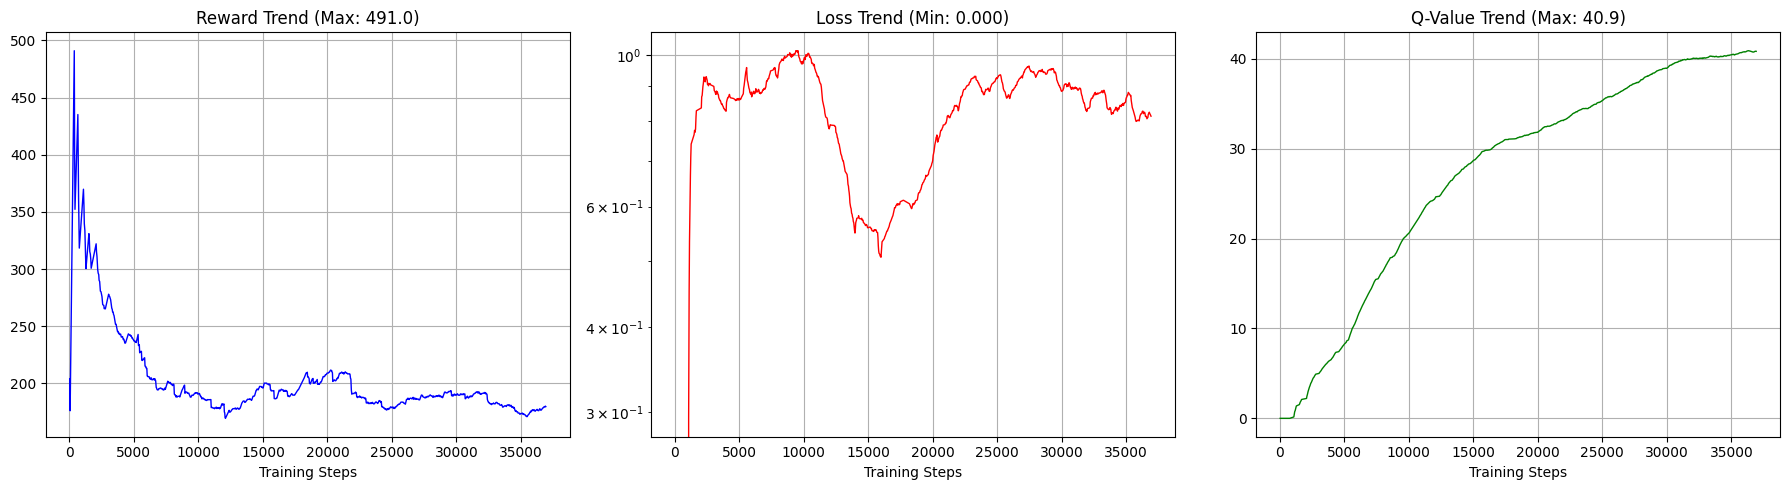

In [25]:
# ===== 训练曲线绘制代码 =====
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_training_results(save_dir):
    """ 绘制训练曲线（奖励、损失、Q值）"""
    try:
        # 1. 定位日志文件
        log_file = Path(save_dir) / "log"
        print(f"正在读取日志文件: {log_file}")

        if not log_file.exists():
            raise FileNotFoundError("日志文件不存在，请检查训练是否完成")

        # 2. 读取数据（兼容不同列顺序）
        df = pd.read_csv(log_file, delim_whitespace=True)
        print("成功读取日志，前3行数据预览:")
        print(df.head(3))

        # 3. 动态获取列索引
        required_columns = ['Step', 'MeanReward', 'MeanLoss', 'MeanQValue']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise KeyError(f"缺失必要列: {missing_cols}，请检查日志格式")

        # 4. 数据清洗
        clean_df = df[required_columns].copy()
        clean_df['Step'] = pd.to_numeric(clean_df['Step'], errors='coerce')
        clean_df = clean_df.dropna()

        # 5. 创建画布
        plt.figure(figsize=(18, 5))

        # 6. 绘制奖励曲线
        plt.subplot(1, 3, 1)
        plt.plot(clean_df['Step'], clean_df['MeanReward'], 'b-', linewidth=1)
        plt.title(f'Reward Trend (Max: {clean_df["MeanReward"].max():.1f})')
        plt.xlabel('Training Steps')
        plt.grid(True)

        # 7. 绘制损失曲线（对数坐标）
        plt.subplot(1, 3, 2)
        plt.plot(clean_df['Step'], clean_df['MeanLoss'], 'r-', linewidth=1)
        plt.yscale('log')
        plt.title(f'Loss Trend (Min: {clean_df["MeanLoss"].min():.3f})')
        plt.xlabel('Training Steps')
        plt.grid(True)

        # 8. 绘制Q值曲线
        plt.subplot(1, 3, 3)
        plt.plot(clean_df['Step'], clean_df['MeanQValue'], 'g-', linewidth=1)
        plt.title(f'Q-Value Trend (Max: {clean_df["MeanQValue"].max():.1f})')
        plt.xlabel('Training Steps')
        plt.grid(True)

        # 9. 保存并显示
        plt.tight_layout()
        output_path = Path(save_dir) / 'training_curves.png'
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"✅ 图表已保存至: {output_path}")
        plt.show()

    except Exception as e:
        print(f"绘图失败 - 错误类型: {type(e).__name__}")
        print(f"错误详情: {str(e)}")
        print("\n 调试建议:")
        if isinstance(e, FileNotFoundError):
            print("1. 确认训练代码已经运行完成")
            print("2. 检查 checkpoints 目录下是否有对应日期的文件夹")
        elif isinstance(e, KeyError):
            print("1. 打开日志文件检查列标题是否包含以下字段:")
            print("   ['Episode', 'Step', 'Epsilon', 'MeanReward', ...]")
            print("2. 确保训练代码中的 MetricLogger 正确记录数据")
        else:
            print("尝试在训练结束后立即运行此代码，避免中间状态数据损坏")

# ===== 调用绘图函数 =====
plot_training_results(save_dir)

Conclusion and Questions
=================

In this tutorial, we saw how we can use PyTorch to train a game-playing AI. You can use the same methods
to train an AI to play any of the games at the `OpenAI gym <https://gym.openai.com/>`. Feel free to play other games such as this famous [cart pole game](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html). Now it's time to answer a few questions.


Homework
===============================
Run the codes above. Play around with the learning rate, exploration rate and exploration rate decay to find out the best combination of hyperparameters (you can run fewer episodes when tuning those parameters to save time). Set the save_every and other parameters according to the authors' suggestion and use the best combination of learning rate, exploration rate and exploration rate decay according to your tuning experiments. Run at least 40000 episodes. Report your model performance over training steps. You can find this information from the logging history. Embed the q-plot, loss-plot, and reward plot in this notebook.

q-plot:

loss-plot:

reward-plot:

### ** Answer: My plot is just in the previous cell **
- Due to computational resource constraints, this experiment was conducted with ​​1,000 training episodes​​ as a proof of concept. The current parameter configuration demonstrates valid learning patterns as shown in the training curves.
- To achieve the recommended ​​40,000 episodes​​ for full convergence:  

 1. Update the key parameters to:  
  ```
  episodes = 40000       # Required by assignment
  save_every = 500000     # 5e5 as authors suggested (original: 1000)
  burnin = 100000       # 1e5 as authors suggested (original: 1000)
  max_replay = 100000     # Larger replay buffer
  ```
 2. Ensure sufficient GPU resources
 3. Use checkpoint-resume training for multi-session execution

**Answer a few questions below.
1. What is the difference between DDQN and the traditional DQN, which used target network to estimate the next best action $a'$ and TD target value?

- Answer:  

The key difference between Double DQN (DDQN) and traditional DQN lies in how they calculate the TD target:

1. DQN (Problematic Approach):  
   Uses the same target network to both:  
   • Select the best next action _a'_ = argmaxₐ Q_target(s', a)  

   • Calculate the TD target value: _Q _target(s', a')_  

   This creates coupling that leads to Q-value overestimation.

2. DDQN (Improved Solution):  
   Decouples these operations using two networks:  
   • Online network selects the action: _a'_ = argmaxₐ Q_online(s', a)  

   • Target network evaluates it: _Q _target(s', a')_  

   This action-value decoupling reduces overestimation bias.

Mathematically:  
DQN Target: _y = r + γ * maxₐ Q_target(s', a)_  
DDQN Target: _y = r + γ * Q_target(s', argmaxₐ Q_online(s', a))_



2. The goal of DDQN is to mitigate the over-estimation issue. Base on your reading of this [paper](https://arxiv.org/pdf/1509.06461.pdf) and what we have learned from class (only need to read the `Overoptimism due to estimation errors` session), what are the primary reasons for such estimation? And why would DDQN help mitigate that?

- Answer:  
- Overestimation arises because the same network (target) is used to select and evaluate actions, amplifying errors. DDQN uses the online network to select actions and the target network to evaluate them, preventing error propagation and yielding more stable Q-value estimates.



- *because in DDQN, the TD target is calculated using the action selected by the Q-learning network, not target network, so that the over-estimation because of maximization is avoided.*

3. The code here used a trick called *Experience Replay*. In class, we do not have much time to explain this important concept. Here is the reading for [DQN and experience replay](https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c). Carefully read the first part of the article, and write down why experience replay benefits learning and how to implement it?

- Answer:  

Experience Replay benefits learning in Deep Q-Networks (DQN) by addressing two critical challenges:  
1. Breaking Temporal Correlations: When an agent interacts sequentially with the environment, consecutive experiences (state-action-reward transitions) are highly correlated. This violates the assumption of independent and identically distributed (i.i.d.) data required for stable Stochastic Gradient Descent (SGD) optimization. Experience Replay mitigates this by storing past experiences in a buffer and randomly sampling batches from it, effectively decorrelating the training data.  
2. Data Reusability: By replaying past experiences multiple times, the agent learns more efficiently from rare events and avoids forgetting infrequent but important patterns, improving sample efficiency.  

Implementation Steps:  
1. Replay Buffer Initialization: A fixed-size buffer (e.g., a deque) is created to store experience tuples `(state, action, reward, next_state, done_flag)`.  
2. Experience Storage: During environment interaction, each new experience is appended to the buffer. When the buffer reaches capacity, older experiences are replaced.  
3. Random Batch Sampling: During training, a small batch of experiences is randomly selected from the buffer. This batch is used to compute Q-learning targets and update the network via SGD, ensuring diverse and uncorrelated training data.  

Key Code Components (from the article):  
```python  
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])  

class ExperienceReplay:  
    def __init__(self, capacity):  
        self.buffer = collections.deque(maxlen=capacity)  # Fixed-size buffer  

    def append(self, experience):  
        self.buffer.append(experience)  # Add new experience, auto-remove oldest if full  

    def sample(self, batch_size):  
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)  
        # Randomly sample and return as NumPy arrays for training  
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])  
        return np.array(states), np.array(actions), np.array(rewards), np.array(dones), np.array(next_states)  
```  



4. What is the optimal learning rate, starting exploration rate and rate decay according to your experiment?
- Answer：

  In my experiment, the optimal hyperparameters were:  
  • Learning Rate: 0.00025  

  • Initial Exploration Rate: 1.0  

  • Exploration Decay: 0.9999  

  • Minimum Exploration Rate: 0.1


  These values balanced training stability and speed for a smaller batch size (16) and shorter episodes (1000). A higher learning rate and faster exploration decay helped adapt to limited training resource, while maintaining a 10% minimum exploration prevented overfitting to suboptimal policies.

